# Preliminary operations

## Drive Mount

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [ ]:
cd gdrive/MyDrive/Homework2

/content/gdrive/MyDrive/Homework2


## Libraries and seed

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler,  StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import pickle
from sklearn.utils import  compute_class_weight
!pip install scikeras 
from scikeras.wrappers import KerasClassifier

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.9.2


In [ ]:
!pip install scikit-optimize
from skopt import BayesSearchCV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 9.6 MB/s 


## Functions definition

In [ ]:
def data_processing(data, target):

  X_train_val, X_test, y_train_val, y_test = train_test_split(data, target, test_size = 0.1, random_state=seed, stratify=target)
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.1, random_state=seed, stratify=y_train_val)

  scaler = StandardScaler()
  scaler = scaler.fit(X_train.reshape(-1, X_train.shape[-1]))
  pickle.dump(scaler, open('scalers/scaler.sav', 'wb'))

  ss = pickle.load(open('scalers/scaler.sav', 'rb'))
  X_train_scaled = ss.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
  X_val_scaled = ss.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
  X_test_scaled = ss.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

  y_train_cat = tf.keras.utils.to_categorical(y_train)
  y_val_cat = tf.keras.utils.to_categorical(y_val)
  y_test_cat = tf.keras.utils.to_categorical(y_test)

  print(X_train_scaled.shape, y_train.shape, y_train_cat.shape)
  print(X_val_scaled.shape, y_val.shape, y_val_cat.shape)
  print(X_test_scaled.shape, y_test.shape, y_test_cat.shape)


  return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_train_cat, y_val_cat, y_test_cat

In [ ]:
def evaluate_model_f(file_name, test_set, target, labels):

  """ Function used to evaluate model's performances on the local test set, display of confusion matrix """
  """ Loading model from file """
  
  model = tfk.models.load_model(file_name)
  predictions = model.predict(test_set)
  metrics= {
    "model": file_name,
    "predictions" : predictions,
    "target": target,
    "cm": confusion_matrix(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), normalize='true', ),
    "accuracy" : accuracy_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1)),
    "precision" : precision_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "recall" : recall_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "f1" : f1_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro')  }
  
  print("Model: "+ str(metrics["model"]))
  print("Accuracy: "+ str(metrics["accuracy"]))
  print("F1 score: "+ str(metrics["f1"]))
  cm = metrics["cm"]
  plt.figure(figsize=(10,8))
  sns.heatmap(cm.T, annot=True, fmt='.2f', xticklabels=list(labels.values()), yticklabels=list(labels.values()))
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

  return metrics

In [ ]:
def evaluate_model_m(model, test_set, target, labels):

  """ Function used to evaluate model's performances on the local test set, display of confusion matrix """
  """ Loading model from trained model variable """
  
  predictions = model.predict(test_set)
  metrics= {
    "predictions" : predictions,
    "target": target,
    "cm": confusion_matrix(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), normalize='true', ),
    "accuracy" : accuracy_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1)),
    "precision" : precision_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "recall" : recall_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "f1" : f1_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro')  }
  
  print("Accuracy: "+ str(metrics["accuracy"]))
  print("F1 score: "+ str(metrics["f1"]))
  cm = metrics["cm"]
  plt.figure(figsize=(15,15))
  sns.heatmap(cm.T, annot=True, fmt='.2f', xticklabels=list(labels.values()), yticklabels=list(labels.values()))
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

  return metrics

# Data preparation

```
Time series:
  n. observations: 2429
  observation's length: 36 samples
  n. channel per observation: 6

Number of classes: 12
```



##Exploration

In [ ]:
data = np.load('original_dataset/x_train.npy')
target = np.load('original_dataset/y_train.npy')
print(data.shape)
print(target.shape)

(2429, 36, 6)
(2429,)


In [ ]:
df = np.empty((87444,6))
df = data[0]
for i in range(0,len(target)):
  df = np.concatenate((df,data[i]),axis = 0)
print()

In [ ]:
df = pd.DataFrame(df)
df.drop_duplicates( inplace=True)
df 

In [ ]:
df = df.rename(columns={df.columns[0]: 'prima',df.columns[1]: 'sec',df.columns[2]: 'ter',df.columns[3]: 'qua',df.columns[4]: 'qui',df.columns[5]: 'sest',})

In [ ]:
df_hist=df.hist(layout=(3,2), figsize=(15,12))

In [ ]:
from sklearn.preprocessing import StandardScaler

independent_variables=df.iloc[:,:] 

scaler = StandardScaler().fit(independent_variables) 
scaled_df = pd.DataFrame(scaler.transform(independent_variables))
scaled_df.columns = independent_variables.columns 

In [ ]:
unique, counts = np.unique(target, return_counts=True)
print(unique)
print() 
print(counts)
print()
print(target.shape, '   ', data.shape)

In [ ]:
t = []
value = 0
for i in counts:
  for j in range(0,i*36):
    t.append(value)
  value+=1

len(t) 

In [ ]:
df['target'] = t
df

In [ ]:
X0 = df[df['target']==0]  
X1 = df[df['target']==1]
X2 = df[df['target']==2]  
X3 = df[df['target']==3]
X4 = df[df['target']==4]  
X5 = df[df['target']==5]
X6 = df[df['target']==6]  
X7 = df[df['target']==7]
X8 = df[df['target']==8]  
X9 = df[df['target']==9]
X10 = df[df['target']==10]  
X11 = df[df['target']==11]

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(30,10))
fig.tight_layout()

for i, ax in zip(range((df.columns.size)-1), axes.flat):
    sns.histplot(X0.iloc[:,i], color="blue", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="red", ax=ax,stat='density', element="step",  alpha=0.3)
    sns.histplot(X0.iloc[:,i], color="black", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="brown", ax=ax,stat='density', element="step",  alpha=0.3)
    sns.histplot(X0.iloc[:,i], color="yellow", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="green", ax=ax,stat='density', element="step",  alpha=0.3)
    sns.histplot(X0.iloc[:,i], color="pink", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="grey", ax=ax,stat='density', element="step",  alpha=0.3)
    sns.histplot(X0.iloc[:,i], color="violet", ax=ax, stat='density', element="step",  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="orange", ax=ax,stat='density', element="step",  alpha=0.3)
    #sns.histplot(X0.iloc[:,i], color="blue", ax=ax, stat='density', element="step",  alpha=0.3)
    #sns.histplot(X1.iloc[:,i], color="red", ax=ax,stat='density', element="step",  alpha=0.3)
plt.show()

In [ ]:
df.apply(lambda s: df.corrwith(s))

In [ ]:
df=df.drop(columns=['target'])


##PCA

In [ ]:
from sklearn.decomposition import PCA
# we can choose the number of components e.g. 10, the percentage of the total variance or set it to None (that means it automatically chooses the number of components)
pca2 = PCA()
pca2.fit(df)

In [ ]:
df2_pca = pd.DataFrame(pca2.transform(df))
df2_pca

In [ ]:
explained_var=pd.DataFrame(pca2.explained_variance_ratio_).transpose()
explained_var

In [ ]:
import seaborn as sns
ax = sns.barplot( data=explained_var)

In [ ]:
df2_pca.columns=['PC1','PC2','PC3','PC4','PC5','PC6']
df2_pca

In [ ]:
df2_pca['target'] = t
df2_pca

##ICA

In [ ]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=6)
ica.fit(df)
df_ica = pd.DataFrame(ica.transform(df))
df_ica

In [ ]:
df_ica.columns=['IC1','IC2','IC3','IC4','IC5','IC6']
df_ica['target'] = t
df_ica

In [ ]:
def build_sequences_pca(df, window=36, stride=36):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    for id in df['target'].unique():
        # Take only meaningful features
        temp = df[df['target'] == id][['PC1','PC2','PC3','PC4','PC5','PC6']].values
        # Save the label
        label = df[df['target'] == id]['target'].values[0] 
        # Compute padding length 
        padding_len = window - len(temp)%window
        # Create padding and concatenate it
        padding = np.zeros((padding_len,6), dtype='float64')
        temp = np.concatenate((temp,padding)) 
        # Build features windows with their corresponging labels
        idx = 0
        while idx+window <= len(temp):
            dataset.append(temp[idx:idx+window])
            labels.append(label)
            idx += stride
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
dati_pca, target_pca = build_sequences_pca(df2_pca)

In [ ]:
def build_sequences_ica(df, window=36, stride=36):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    for id in df['target'].unique():
        # Take only meaningful features
        temp = df[df['target'] == id][['IC1','IC2','IC3','IC4','IC5','IC6']].values
        # Save the label
        label = df[df['target'] == id]['target'].values[0] 
        # Compute padding length 
        padding_len = window - len(temp)%window
        # Create padding and concatenate it
        padding = np.zeros((padding_len,6), dtype='float64')
        temp = np.concatenate((temp,padding)) 
        # Build features windows with their corresponging labels
        idx = 0
        while idx+window <= len(temp):
            dataset.append(temp[idx:idx+window])
            labels.append(label)
            idx += stride 
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
dati_ica, target_ica = build_sequences_ica(df_ica)

In [ ]:
x=pd.DataFrame(data[36])#, columns=['f1', 'f2', 'f3', 'f4', 'f5','f6'])

axis = x.plot(subplots=False, figsize=(17, 9), title='segnali raw')

In [ ]:
x=pd.DataFrame(dati_pca[36])#, columns=['f1', 'f2', 'f3', 'f4','f5'])

axis = x.plot(subplots=False, figsize=(17, 9), title='segnali pca')

In [ ]:
x=pd.DataFrame(dati_ica[36])#, columns=['f1', 'f2', 'f3', 'f4','f5','f6'])

axis = x.plot(subplots=False, figsize=(17, 9), title='segnali ica')

##Split

In [ ]:
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_train_cat, y_val_cat, y_test_cat= data_processing(data, target)

(1967, 36, 6) (1967,) (1967, 12)
(219, 36, 6) (219,) (219, 12)
(243, 36, 6) (243,) (243, 12)


In [ ]:
classes = {
    0: "Wish",
    1: "Another",
    2: "Comfortably",
    3: "Money",
    4: "Breathe",
    5: "Time",
    6: "Brain",
    7: "Echoes",
    8: "Wearing",
    9: "Sorrow",
    10: "Hey",
    11: "Shine"
}

# Model

In [ ]:
X_train = X_train_scaled
y_train = y_train_cat
X_val = X_val_scaled
y_val = y_val_cat
X_test = X_test_scaled
y_test = y_test_cat
input_shape = X_train.shape[1:]
n_output = y_train.shape[-1]

### Convolutional Neural Network - Shallow architecture


Define the model architecture:

In [ ]:
def build_CNN(input_shape=input_shape, n_output=n_output, n1=64, n2=128, n3=256, n4=256, activation='relu', filter_size=3, dp_rate=0.3, learning_r=1e-3, lmbd=1e-5):

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    x = tfkl.Conv1D(n1,filter_size,padding='same',activation=activation)(input_layer)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Conv1D(n2,filter_size,padding='same',activation=activation)(x)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Conv1D(n3,filter_size,padding='same',activation=activation)(x)
    gap = tfkl.GlobalAveragePooling1D()(x)
    dropout = tfkl.Dropout(dp_rate, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(n4, activation=activation, kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer=tf.keras.regularizers.l2(lmbd))(dropout)
    output_layer = tfkl.Dense(n_output, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='Trad_1D_cnn')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=learning_r), metrics='accuracy')

    # Return the model
    return model

Find the best hyperparameter configuration

In [ ]:
# model class to use in the scikit parameter search CV 
model = KerasClassifier(build_fn=build_CNN,  n1=64, n2=128, n3=256, n4=256, activation='relu', filter_size=3, dp_rate=0.3, learning_r=1e-3, lmbd=1e-5)

In [ ]:
# define the hyperparameters to tune
hyperparameters = {
    'epochs': [30,50],
    'batch_size': [32, 64, 128],
    'activation': ['relu'],
    'n1': [32,64,128], 
    'n2': [64,128,256], 
    'n3': [128,256,512],
    'n4': [128,256,512],
    'filter_size': [3,4,2], 
    'learning_r': [1e-2,1e-3,1e-4,1e-5], 
    'lmbd':[1e-5],
    'dp_rate': np.arange(0, 0.5, 0.05)
}

In [ ]:
# create the random search object
rs = BayesSearchCV(estimator=model, search_spaces=hyperparameters, cv=3, n_iter=15)

In [ ]:
# fit the random search object to the training data
rs.fit(X_train, y_train)

# view the best hyperparameters
print(rs.best_params_)

Epoch 1/36


/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


21/21 [==============================] - 1s 8ms/step - loss: 2.4861 - accuracy: 0.3059
Epoch 2/36
21/21 [==============================] - 0s 5ms/step - loss: 2.4284 - accuracy: 0.3478
Epoch 3/36
21/21 [==============================] - 0s 5ms/step - loss: 2.3977 - accuracy: 0.3516
Epoch 4/36
21/21 [==============================] - 0s 5ms/step - loss: 2.3563 - accuracy: 0.3547
Epoch 5/36
21/21 [==============================] - 0s 4ms/step - loss: 2.3032 - accuracy: 0.3570
Epoch 6/36
21/21 [==============================] - 0s 4ms/step - loss: 2.2310 - accuracy: 0.3593
Epoch 7/36
21/21 [==============================] - 0s 5ms/step - loss: 2.1539 - accuracy: 0.3570
Epoch 8/36
21/21 [==============================] - 0s 4ms/step - loss: 2.0765 - accuracy: 0.3616
Epoch 9/36
21/21 [==============================] - 0s 5ms/step - loss: 2.0026 - accuracy: 0.3654
Epoch 10/36
21/21 [==============================] - 0s 5ms/step - loss: 1.9587 - accuracy: 0.3669
Epoch 11/36
21/21 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


21/21 [==============================] - 1s 5ms/step - loss: 2.4663 - accuracy: 0.2250
Epoch 2/36
21/21 [==============================] - 0s 5ms/step - loss: 2.4267 - accuracy: 0.3234
Epoch 3/36
21/21 [==============================] - 0s 5ms/step - loss: 2.3959 - accuracy: 0.3448
Epoch 4/36
21/21 [==============================] - 0s 5ms/step - loss: 2.3534 - accuracy: 0.3547
Epoch 5/36
21/21 [==============================] - 0s 5ms/step - loss: 2.3016 - accuracy: 0.3524
Epoch 6/36
21/21 [==============================] - 0s 5ms/step - loss: 2.2310 - accuracy: 0.3539
Epoch 7/36
21/21 [==============================] - 0s 5ms/step - loss: 2.1503 - accuracy: 0.3539
Epoch 8/36
21/21 [==============================] - 0s 5ms/step - loss: 2.0881 - accuracy: 0.3471
Epoch 9/36
21/21 [==============================] - 0s 5ms/step - loss: 2.0175 - accuracy: 0.3577
Epoch 10/36
21/21 [==============================] - 0s 5ms/step - loss: 1.9906 - accuracy: 0.3631
Epoch 11/36
21/21 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


21/21 [==============================] - 1s 9ms/step - loss: 2.4701 - accuracy: 0.2027
Epoch 2/36
21/21 [==============================] - 0s 5ms/step - loss: 2.4318 - accuracy: 0.3216
Epoch 3/36
21/21 [==============================] - 0s 5ms/step - loss: 2.4077 - accuracy: 0.3232
Epoch 4/36
21/21 [==============================] - 0s 5ms/step - loss: 2.3683 - accuracy: 0.3338
Epoch 5/36
21/21 [==============================] - 0s 5ms/step - loss: 2.3206 - accuracy: 0.3377
Epoch 6/36
21/21 [==============================] - 0s 4ms/step - loss: 2.2532 - accuracy: 0.3369
Epoch 7/36
21/21 [==============================] - 0s 4ms/step - loss: 2.1904 - accuracy: 0.3354
Epoch 8/36
21/21 [==============================] - 0s 5ms/step - loss: 2.1140 - accuracy: 0.3369
Epoch 9/36
21/21 [==============================] - 0s 5ms/step - loss: 2.0490 - accuracy: 0.3453
Epoch 10/36
21/21 [==============================] - 0s 4ms/step - loss: 2.0062 - accuracy: 0.3498
Epoch 11/36
21/21 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 15ms/step - loss: 2.4856 - accuracy: 0.0892
Epoch 2/49
11/11 [==============================] - 0s 5ms/step - loss: 2.4775 - accuracy: 0.1609
Epoch 3/49
11/11 [==============================] - 0s 5ms/step - loss: 2.4723 - accuracy: 0.1968
Epoch 4/49
11/11 [==============================] - 0s 5ms/step - loss: 2.4659 - accuracy: 0.2319
Epoch 5/49
11/11 [==============================] - 0s 5ms/step - loss: 2.4642 - accuracy: 0.2334
Epoch 6/49
11/11 [==============================] - 0s 7ms/step - loss: 2.4559 - accuracy: 0.2502
Epoch 7/49
11/11 [==============================] - 0s 5ms/step - loss: 2.4534 - accuracy: 0.2578
Epoch 8/49
11/11 [==============================] - 0s 5ms/step - loss: 2.4477 - accuracy: 0.2555
Epoch 9/49
11/11 [==============================] - 0s 5ms/step - loss: 2.4452 - accuracy: 0.2685
Epoch 10/49
11/11 [==============================] - 0s 5ms/step - loss: 2.4410 - accuracy: 0.2868
Epoch 11/49
11/11 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 7ms/step - loss: 2.4991 - accuracy: 0.0984
Epoch 2/49
11/11 [==============================] - 0s 6ms/step - loss: 2.4922 - accuracy: 0.1960
Epoch 3/49
11/11 [==============================] - 0s 6ms/step - loss: 2.4802 - accuracy: 0.2456
Epoch 4/49
11/11 [==============================] - 0s 6ms/step - loss: 2.4751 - accuracy: 0.2563
Epoch 5/49
11/11 [==============================] - 0s 7ms/step - loss: 2.4698 - accuracy: 0.2487
Epoch 6/49
11/11 [==============================] - 0s 7ms/step - loss: 2.4633 - accuracy: 0.2487
Epoch 7/49
11/11 [==============================] - 0s 7ms/step - loss: 2.4590 - accuracy: 0.2471
Epoch 8/49
11/11 [==============================] - 0s 6ms/step - loss: 2.4540 - accuracy: 0.2487
Epoch 9/49
11/11 [==============================] - 0s 6ms/step - loss: 2.4492 - accuracy: 0.2624
Epoch 10/49
11/11 [==============================] - 0s 6ms/step - loss: 2.4469 - accuracy: 0.2738
Epoch 11/49
11/11 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 16ms/step - loss: 2.4911 - accuracy: 0.0747
Epoch 2/49
11/11 [==============================] - 0s 7ms/step - loss: 2.4839 - accuracy: 0.1326
Epoch 3/49
11/11 [==============================] - 0s 5ms/step - loss: 2.4770 - accuracy: 0.1845
Epoch 4/49
11/11 [==============================] - 0s 6ms/step - loss: 2.4702 - accuracy: 0.2088
Epoch 5/49
11/11 [==============================] - 0s 5ms/step - loss: 2.4637 - accuracy: 0.2500
Epoch 6/49
11/11 [==============================] - 0s 6ms/step - loss: 2.4581 - accuracy: 0.2652
Epoch 7/49
11/11 [==============================] - 0s 6ms/step - loss: 2.4544 - accuracy: 0.2828
Epoch 8/49
11/11 [==============================] - 0s 6ms/step - loss: 2.4519 - accuracy: 0.2973
Epoch 9/49
11/11 [==============================] - 0s 5ms/step - loss: 2.4472 - accuracy: 0.3201
Epoch 10/49
11/11 [==============================] - 0s 6ms/step - loss: 2.4438 - accuracy: 0.3140
Epoch 11/49
11/11 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 12ms/step - loss: 2.4652 - accuracy: 0.2342
Epoch 2/39
11/11 [==============================] - 0s 5ms/step - loss: 2.4280 - accuracy: 0.2838
Epoch 3/39
11/11 [==============================] - 0s 5ms/step - loss: 2.4049 - accuracy: 0.3356
Epoch 4/39
11/11 [==============================] - 0s 5ms/step - loss: 2.3821 - accuracy: 0.3509
Epoch 5/39
11/11 [==============================] - 0s 6ms/step - loss: 2.3519 - accuracy: 0.3539
Epoch 6/39
11/11 [==============================] - 0s 5ms/step - loss: 2.3164 - accuracy: 0.3585
Epoch 7/39
11/11 [==============================] - 0s 5ms/step - loss: 2.2751 - accuracy: 0.3593
Epoch 8/39
11/11 [==============================] - 0s 5ms/step - loss: 2.2223 - accuracy: 0.3608
Epoch 9/39
11/11 [==============================] - 0s 6ms/step - loss: 2.1617 - accuracy: 0.3638
Epoch 10/39
11/11 [==============================] - 0s 5ms/step - loss: 2.1038 - accuracy: 0.3638
Epoch 11/39
11/11 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 6ms/step - loss: 2.4669 - accuracy: 0.2792
Epoch 2/39
11/11 [==============================] - 0s 6ms/step - loss: 2.4281 - accuracy: 0.3257
Epoch 3/39
11/11 [==============================] - 0s 6ms/step - loss: 2.4038 - accuracy: 0.3341
Epoch 4/39
11/11 [==============================] - 0s 6ms/step - loss: 2.3785 - accuracy: 0.3448
Epoch 5/39
11/11 [==============================] - 0s 6ms/step - loss: 2.3452 - accuracy: 0.3516
Epoch 6/39
11/11 [==============================] - 0s 6ms/step - loss: 2.3064 - accuracy: 0.3631
Epoch 7/39
11/11 [==============================] - 0s 6ms/step - loss: 2.2571 - accuracy: 0.3555
Epoch 8/39
11/11 [==============================] - 0s 6ms/step - loss: 2.2005 - accuracy: 0.3562
Epoch 9/39
11/11 [==============================] - 0s 6ms/step - loss: 2.1341 - accuracy: 0.3539
Epoch 10/39
11/11 [==============================] - 0s 6ms/step - loss: 2.0690 - accuracy: 0.3593
Epoch 11/39
11/11 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 16ms/step - loss: 2.4920 - accuracy: 0.2828
Epoch 2/39
11/11 [==============================] - 0s 8ms/step - loss: 2.4524 - accuracy: 0.3209
Epoch 3/39
11/11 [==============================] - 0s 6ms/step - loss: 2.4284 - accuracy: 0.3239
Epoch 4/39
11/11 [==============================] - 0s 6ms/step - loss: 2.4029 - accuracy: 0.3369
Epoch 5/39
11/11 [==============================] - 0s 6ms/step - loss: 2.3727 - accuracy: 0.3483
Epoch 6/39
11/11 [==============================] - 0s 7ms/step - loss: 2.3337 - accuracy: 0.3445
Epoch 7/39
11/11 [==============================] - 0s 6ms/step - loss: 2.2884 - accuracy: 0.3438
Epoch 8/39
11/11 [==============================] - 0s 6ms/step - loss: 2.2316 - accuracy: 0.3430
Epoch 9/39
11/11 [==============================] - 0s 6ms/step - loss: 2.1669 - accuracy: 0.3430
Epoch 10/39
11/11 [==============================] - 0s 6ms/step - loss: 2.1004 - accuracy: 0.3483
Epoch 11/39
11/11 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


41/41 [==============================] - 1s 6ms/step - loss: 2.4896 - accuracy: 0.0252
Epoch 2/46
41/41 [==============================] - 0s 6ms/step - loss: 2.4669 - accuracy: 0.1358
Epoch 3/46
41/41 [==============================] - 0s 7ms/step - loss: 2.4515 - accuracy: 0.2273
Epoch 4/46
41/41 [==============================] - 0s 7ms/step - loss: 2.4436 - accuracy: 0.2784
Epoch 5/46
41/41 [==============================] - 0s 7ms/step - loss: 2.4299 - accuracy: 0.3036
Epoch 6/46
41/41 [==============================] - 0s 7ms/step - loss: 2.4217 - accuracy: 0.3249
Epoch 7/46
41/41 [==============================] - 0s 7ms/step - loss: 2.4111 - accuracy: 0.3356
Epoch 8/46
41/41 [==============================] - 0s 7ms/step - loss: 2.4033 - accuracy: 0.3425
Epoch 9/46
41/41 [==============================] - 0s 5ms/step - loss: 2.3909 - accuracy: 0.3516
Epoch 10/46
41/41 [==============================] - 0s 5ms/step - loss: 2.3829 - accuracy: 0.3547
Epoch 11/46
41/41 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


41/41 [==============================] - 1s 6ms/step - loss: 2.4809 - accuracy: 0.0717
Epoch 2/46
41/41 [==============================] - 0s 6ms/step - loss: 2.4659 - accuracy: 0.1205
Epoch 3/46
41/41 [==============================] - 0s 7ms/step - loss: 2.4565 - accuracy: 0.1899
Epoch 4/46
41/41 [==============================] - 0s 9ms/step - loss: 2.4462 - accuracy: 0.2487
Epoch 5/46
41/41 [==============================] - 0s 9ms/step - loss: 2.4374 - accuracy: 0.2960
Epoch 6/46
41/41 [==============================] - 0s 6ms/step - loss: 2.4268 - accuracy: 0.3204
Epoch 7/46
41/41 [==============================] - 0s 5ms/step - loss: 2.4221 - accuracy: 0.3341
Epoch 8/46
41/41 [==============================] - 0s 7ms/step - loss: 2.4102 - accuracy: 0.3524
Epoch 9/46
41/41 [==============================] - 0s 9ms/step - loss: 2.4004 - accuracy: 0.3402
Epoch 10/46
41/41 [==============================] - 0s 9ms/step - loss: 2.3972 - accuracy: 0.3623
Epoch 11/46
41/41 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


41/41 [==============================] - 1s 5ms/step - loss: 2.4734 - accuracy: 0.0328
Epoch 2/46
41/41 [==============================] - 0s 4ms/step - loss: 2.4633 - accuracy: 0.0564
Epoch 3/46
41/41 [==============================] - 0s 4ms/step - loss: 2.4533 - accuracy: 0.1425
Epoch 4/46
41/41 [==============================] - 0s 4ms/step - loss: 2.4446 - accuracy: 0.2157
Epoch 5/46
41/41 [==============================] - 0s 4ms/step - loss: 2.4404 - accuracy: 0.2683
Epoch 6/46
41/41 [==============================] - 0s 4ms/step - loss: 2.4338 - accuracy: 0.2988
Epoch 7/46
41/41 [==============================] - 0s 4ms/step - loss: 2.4259 - accuracy: 0.3125
Epoch 8/46
41/41 [==============================] - 0s 4ms/step - loss: 2.4209 - accuracy: 0.3293
Epoch 9/46
41/41 [==============================] - 0s 4ms/step - loss: 2.4082 - accuracy: 0.3338
Epoch 10/46
41/41 [==============================] - 0s 4ms/step - loss: 2.4025 - accuracy: 0.3468
Epoch 11/46
41/41 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


21/21 [==============================] - 1s 7ms/step - loss: 2.3320 - accuracy: 0.3143
Epoch 2/44
21/21 [==============================] - 0s 5ms/step - loss: 1.9959 - accuracy: 0.3631
Epoch 3/44
21/21 [==============================] - 0s 4ms/step - loss: 1.8551 - accuracy: 0.3783
Epoch 4/44
21/21 [==============================] - 0s 5ms/step - loss: 1.7891 - accuracy: 0.3944
Epoch 5/44
21/21 [==============================] - 0s 5ms/step - loss: 1.7371 - accuracy: 0.4050
Epoch 6/44
21/21 [==============================] - 0s 5ms/step - loss: 1.6713 - accuracy: 0.4188
Epoch 7/44
21/21 [==============================] - 0s 5ms/step - loss: 1.6509 - accuracy: 0.4317
Epoch 8/44
21/21 [==============================] - 0s 5ms/step - loss: 1.5693 - accuracy: 0.4729
Epoch 9/44
21/21 [==============================] - 0s 5ms/step - loss: 1.5177 - accuracy: 0.4760
Epoch 10/44
21/21 [==============================] - 0s 5ms/step - loss: 1.4456 - accuracy: 0.5103
Epoch 11/44
21/21 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


21/21 [==============================] - 1s 5ms/step - loss: 2.3447 - accuracy: 0.3112
Epoch 2/44
21/21 [==============================] - 0s 5ms/step - loss: 2.0103 - accuracy: 0.3646
Epoch 3/44
21/21 [==============================] - 0s 5ms/step - loss: 1.9037 - accuracy: 0.3875
Epoch 4/44
21/21 [==============================] - 0s 5ms/step - loss: 1.8729 - accuracy: 0.3730
Epoch 5/44
21/21 [==============================] - 0s 5ms/step - loss: 1.7556 - accuracy: 0.4142
Epoch 6/44
21/21 [==============================] - 0s 5ms/step - loss: 1.6600 - accuracy: 0.4256
Epoch 7/44
21/21 [==============================] - 0s 6ms/step - loss: 1.6513 - accuracy: 0.4462
Epoch 8/44
21/21 [==============================] - 0s 6ms/step - loss: 1.5983 - accuracy: 0.4577
Epoch 9/44
21/21 [==============================] - 0s 5ms/step - loss: 1.5040 - accuracy: 0.4805
Epoch 10/44
21/21 [==============================] - 0s 6ms/step - loss: 1.4517 - accuracy: 0.4996
Epoch 11/44
21/21 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


21/21 [==============================] - 1s 9ms/step - loss: 2.3681 - accuracy: 0.2934
Epoch 2/44
21/21 [==============================] - 0s 6ms/step - loss: 2.0287 - accuracy: 0.3453
Epoch 3/44
21/21 [==============================] - 0s 5ms/step - loss: 1.8936 - accuracy: 0.3674
Epoch 4/44
21/21 [==============================] - 0s 5ms/step - loss: 1.8561 - accuracy: 0.3765
Epoch 5/44
21/21 [==============================] - 0s 5ms/step - loss: 1.7481 - accuracy: 0.4154
Epoch 6/44
21/21 [==============================] - 0s 5ms/step - loss: 1.6875 - accuracy: 0.4215
Epoch 7/44
21/21 [==============================] - 0s 5ms/step - loss: 1.5730 - accuracy: 0.4581
Epoch 8/44
21/21 [==============================] - 0s 5ms/step - loss: 1.5855 - accuracy: 0.4848
Epoch 9/44
21/21 [==============================] - 0s 5ms/step - loss: 1.4516 - accuracy: 0.5130
Epoch 10/44
21/21 [==============================] - 0s 5ms/step - loss: 1.4056 - accuracy: 0.5076
Epoch 11/44
21/21 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 8ms/step - loss: 2.4623 - accuracy: 0.0572
Epoch 2/34
11/11 [==============================] - 0s 8ms/step - loss: 2.4159 - accuracy: 0.1076
Epoch 3/34
11/11 [==============================] - 0s 7ms/step - loss: 2.3889 - accuracy: 0.2998
Epoch 4/34
11/11 [==============================] - 0s 7ms/step - loss: 2.3579 - accuracy: 0.3440
Epoch 5/34
11/11 [==============================] - 0s 6ms/step - loss: 2.3187 - accuracy: 0.3555
Epoch 6/34
11/11 [==============================] - 0s 6ms/step - loss: 2.2701 - accuracy: 0.3616
Epoch 7/34
11/11 [==============================] - 0s 6ms/step - loss: 2.2129 - accuracy: 0.3638
Epoch 8/34
11/11 [==============================] - 0s 7ms/step - loss: 2.1417 - accuracy: 0.3646
Epoch 9/34
11/11 [==============================] - 0s 6ms/step - loss: 2.0658 - accuracy: 0.3692
Epoch 10/34
11/11 [==============================] - 0s 6ms/step - loss: 1.9909 - accuracy: 0.3722
Epoch 11/34
11/11 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 7ms/step - loss: 2.4720 - accuracy: 0.0648
Epoch 2/34
11/11 [==============================] - 0s 6ms/step - loss: 2.4229 - accuracy: 0.2014
Epoch 3/34
11/11 [==============================] - 0s 6ms/step - loss: 2.3995 - accuracy: 0.3135
Epoch 4/34
11/11 [==============================] - 0s 6ms/step - loss: 2.3770 - accuracy: 0.3349
Epoch 5/34
11/11 [==============================] - 0s 6ms/step - loss: 2.3482 - accuracy: 0.3539
Epoch 6/34
11/11 [==============================] - 0s 6ms/step - loss: 2.3107 - accuracy: 0.3616
Epoch 7/34
11/11 [==============================] - 0s 7ms/step - loss: 2.2672 - accuracy: 0.3616
Epoch 8/34
11/11 [==============================] - 0s 7ms/step - loss: 2.2189 - accuracy: 0.3616
Epoch 9/34
11/11 [==============================] - 0s 6ms/step - loss: 2.1613 - accuracy: 0.3570
Epoch 10/34
11/11 [==============================] - 0s 6ms/step - loss: 2.1025 - accuracy: 0.3692
Epoch 11/34
11/11 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 8ms/step - loss: 2.4680 - accuracy: 0.1037
Epoch 2/34
11/11 [==============================] - 0s 8ms/step - loss: 2.4266 - accuracy: 0.3277
Epoch 3/34
11/11 [==============================] - 0s 8ms/step - loss: 2.3986 - accuracy: 0.3392
Epoch 4/34
11/11 [==============================] - 0s 7ms/step - loss: 2.3675 - accuracy: 0.3582
Epoch 5/34
11/11 [==============================] - 0s 7ms/step - loss: 2.3334 - accuracy: 0.3598
Epoch 6/34
11/11 [==============================] - 0s 7ms/step - loss: 2.2894 - accuracy: 0.3628
Epoch 7/34
11/11 [==============================] - 0s 6ms/step - loss: 2.2373 - accuracy: 0.3559
Epoch 8/34
11/11 [==============================] - 0s 8ms/step - loss: 2.1826 - accuracy: 0.3613
Epoch 9/34
11/11 [==============================] - 0s 8ms/step - loss: 2.1170 - accuracy: 0.3651
Epoch 10/34
11/11 [==============================] - 0s 6ms/step - loss: 2.0488 - accuracy: 0.3720
Epoch 11/34
11/11 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 6ms/step - loss: 2.3948 - accuracy: 0.2906
Epoch 2/47
11/11 [==============================] - 0s 5ms/step - loss: 2.1251 - accuracy: 0.3585
Epoch 3/47
11/11 [==============================] - 0s 5ms/step - loss: 1.9045 - accuracy: 0.3745
Epoch 4/47
11/11 [==============================] - 0s 5ms/step - loss: 1.8075 - accuracy: 0.4005
Epoch 5/47
11/11 [==============================] - 0s 4ms/step - loss: 1.7452 - accuracy: 0.4027
Epoch 6/47
11/11 [==============================] - 0s 5ms/step - loss: 1.6846 - accuracy: 0.4363
Epoch 7/47
11/11 [==============================] - 0s 5ms/step - loss: 1.6554 - accuracy: 0.4310
Epoch 8/47
11/11 [==============================] - 0s 5ms/step - loss: 1.5920 - accuracy: 0.4561
Epoch 9/47
11/11 [==============================] - 0s 5ms/step - loss: 1.5810 - accuracy: 0.4661
Epoch 10/47
11/11 [==============================] - 0s 5ms/step - loss: 1.5481 - accuracy: 0.4836
Epoch 11/47
11/11 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 6ms/step - loss: 2.4066 - accuracy: 0.2960
Epoch 2/47
11/11 [==============================] - 0s 7ms/step - loss: 2.1733 - accuracy: 0.3555
Epoch 3/47
11/11 [==============================] - 0s 6ms/step - loss: 1.9748 - accuracy: 0.3760
Epoch 4/47
11/11 [==============================] - 0s 6ms/step - loss: 1.8812 - accuracy: 0.3760
Epoch 5/47
11/11 [==============================] - 0s 7ms/step - loss: 1.7989 - accuracy: 0.4050
Epoch 6/47
11/11 [==============================] - 0s 6ms/step - loss: 1.7547 - accuracy: 0.4180
Epoch 7/47
11/11 [==============================] - 0s 7ms/step - loss: 1.7026 - accuracy: 0.4302
Epoch 8/47
11/11 [==============================] - 0s 6ms/step - loss: 1.6285 - accuracy: 0.4485
Epoch 9/47
11/11 [==============================] - 0s 6ms/step - loss: 1.6101 - accuracy: 0.4500
Epoch 10/47
11/11 [==============================] - 0s 6ms/step - loss: 1.5486 - accuracy: 0.4630
Epoch 11/47
11/11 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 7ms/step - loss: 2.3994 - accuracy: 0.2797
Epoch 2/47
11/11 [==============================] - 0s 7ms/step - loss: 2.1693 - accuracy: 0.3392
Epoch 3/47
11/11 [==============================] - 0s 7ms/step - loss: 1.9943 - accuracy: 0.3514
Epoch 4/47
11/11 [==============================] - 0s 6ms/step - loss: 1.8847 - accuracy: 0.3780
Epoch 5/47
11/11 [==============================] - 0s 6ms/step - loss: 1.8035 - accuracy: 0.4055
Epoch 6/47
11/11 [==============================] - 0s 6ms/step - loss: 1.7555 - accuracy: 0.3979
Epoch 7/47
11/11 [==============================] - 0s 6ms/step - loss: 1.6982 - accuracy: 0.4261
Epoch 8/47
11/11 [==============================] - 0s 7ms/step - loss: 1.6478 - accuracy: 0.4489
Epoch 9/47
11/11 [==============================] - 0s 6ms/step - loss: 1.5999 - accuracy: 0.4512
Epoch 10/47
11/11 [==============================] - 0s 6ms/step - loss: 1.5478 - accuracy: 0.4657
Epoch 11/47
11/11 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 7ms/step - loss: 2.5010 - accuracy: 0.0915
Epoch 2/47
11/11 [==============================] - 0s 6ms/step - loss: 2.4886 - accuracy: 0.1236
Epoch 3/47
11/11 [==============================] - 0s 6ms/step - loss: 2.4811 - accuracy: 0.1876
Epoch 4/47
11/11 [==============================] - 0s 5ms/step - loss: 2.4728 - accuracy: 0.2296
Epoch 5/47
11/11 [==============================] - 0s 5ms/step - loss: 2.4644 - accuracy: 0.2578
Epoch 6/47
11/11 [==============================] - 0s 6ms/step - loss: 2.4597 - accuracy: 0.2822
Epoch 7/47
11/11 [==============================] - 0s 5ms/step - loss: 2.4576 - accuracy: 0.2746
Epoch 8/47
11/11 [==============================] - 0s 5ms/step - loss: 2.4497 - accuracy: 0.2799
Epoch 9/47
11/11 [==============================] - 0s 5ms/step - loss: 2.4442 - accuracy: 0.2929
Epoch 10/47
11/11 [==============================] - 0s 5ms/step - loss: 2.4421 - accuracy: 0.2937
Epoch 11/47
11/11 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 7ms/step - loss: 2.5044 - accuracy: 0.0534
Epoch 2/47
11/11 [==============================] - 0s 7ms/step - loss: 2.4945 - accuracy: 0.0618
Epoch 3/47
11/11 [==============================] - 0s 7ms/step - loss: 2.4915 - accuracy: 0.0709
Epoch 4/47
11/11 [==============================] - 0s 6ms/step - loss: 2.4857 - accuracy: 0.0694
Epoch 5/47
11/11 [==============================] - 0s 6ms/step - loss: 2.4775 - accuracy: 0.0740
Epoch 6/47
11/11 [==============================] - 0s 6ms/step - loss: 2.4728 - accuracy: 0.0923
Epoch 7/47
11/11 [==============================] - 0s 6ms/step - loss: 2.4695 - accuracy: 0.1068
Epoch 8/47
11/11 [==============================] - 0s 6ms/step - loss: 2.4622 - accuracy: 0.1411
Epoch 9/47
11/11 [==============================] - 0s 5ms/step - loss: 2.4588 - accuracy: 0.1747
Epoch 10/47
11/11 [==============================] - 0s 6ms/step - loss: 2.4546 - accuracy: 0.1960
Epoch 11/47
11/11 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 6ms/step - loss: 2.4999 - accuracy: 0.1189
Epoch 2/47
11/11 [==============================] - 0s 7ms/step - loss: 2.4987 - accuracy: 0.1761
Epoch 3/47
11/11 [==============================] - 0s 6ms/step - loss: 2.4890 - accuracy: 0.2416
Epoch 4/47
11/11 [==============================] - 0s 6ms/step - loss: 2.4879 - accuracy: 0.2607
Epoch 5/47
11/11 [==============================] - 0s 7ms/step - loss: 2.4835 - accuracy: 0.3034
Epoch 6/47
11/11 [==============================] - 0s 6ms/step - loss: 2.4792 - accuracy: 0.3041
Epoch 7/47
11/11 [==============================] - 0s 7ms/step - loss: 2.4737 - accuracy: 0.3239
Epoch 8/47
11/11 [==============================] - 0s 6ms/step - loss: 2.4708 - accuracy: 0.3354
Epoch 9/47
11/11 [==============================] - 0s 7ms/step - loss: 2.4687 - accuracy: 0.3209
Epoch 10/47
11/11 [==============================] - 0s 7ms/step - loss: 2.4658 - accuracy: 0.3277
Epoch 11/47
11/11 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


21/21 [==============================] - 1s 5ms/step - loss: 2.5115 - accuracy: 0.1785
Epoch 2/38
21/21 [==============================] - 0s 5ms/step - loss: 2.4444 - accuracy: 0.3379
Epoch 3/38
21/21 [==============================] - 0s 5ms/step - loss: 2.4125 - accuracy: 0.3494
Epoch 4/38
21/21 [==============================] - 0s 5ms/step - loss: 2.3716 - accuracy: 0.3516
Epoch 5/38
21/21 [==============================] - 0s 5ms/step - loss: 2.3223 - accuracy: 0.3539
Epoch 6/38
21/21 [==============================] - 0s 5ms/step - loss: 2.2585 - accuracy: 0.3555
Epoch 7/38
21/21 [==============================] - 0s 5ms/step - loss: 2.1816 - accuracy: 0.3577
Epoch 8/38
21/21 [==============================] - 0s 5ms/step - loss: 2.0877 - accuracy: 0.3570
Epoch 9/38
21/21 [==============================] - 0s 5ms/step - loss: 2.0109 - accuracy: 0.3600
Epoch 10/38
21/21 [==============================] - 0s 5ms/step - loss: 1.9533 - accuracy: 0.3661
Epoch 11/38
21/21 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


21/21 [==============================] - 1s 6ms/step - loss: 2.4745 - accuracy: 0.2029
Epoch 2/38
21/21 [==============================] - 0s 5ms/step - loss: 2.4326 - accuracy: 0.3280
Epoch 3/38
21/21 [==============================] - 0s 5ms/step - loss: 2.4029 - accuracy: 0.3425
Epoch 4/38
21/21 [==============================] - 0s 5ms/step - loss: 2.3627 - accuracy: 0.3524
Epoch 5/38
21/21 [==============================] - 0s 5ms/step - loss: 2.3266 - accuracy: 0.3501
Epoch 6/38
21/21 [==============================] - 0s 6ms/step - loss: 2.2605 - accuracy: 0.3516
Epoch 7/38
21/21 [==============================] - 0s 5ms/step - loss: 2.1842 - accuracy: 0.3524
Epoch 8/38
21/21 [==============================] - 0s 5ms/step - loss: 2.1055 - accuracy: 0.3455
Epoch 9/38
21/21 [==============================] - 0s 5ms/step - loss: 2.0333 - accuracy: 0.3562
Epoch 10/38
21/21 [==============================] - 0s 5ms/step - loss: 2.0010 - accuracy: 0.3555
Epoch 11/38
21/21 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


21/21 [==============================] - 1s 5ms/step - loss: 2.4723 - accuracy: 0.1075
Epoch 2/38
21/21 [==============================] - 0s 5ms/step - loss: 2.4310 - accuracy: 0.3110
Epoch 3/38
21/21 [==============================] - 0s 5ms/step - loss: 2.3973 - accuracy: 0.3354
Epoch 4/38
21/21 [==============================] - 0s 5ms/step - loss: 2.3584 - accuracy: 0.3438
Epoch 5/38
21/21 [==============================] - 0s 5ms/step - loss: 2.3076 - accuracy: 0.3445
Epoch 6/38
21/21 [==============================] - 0s 5ms/step - loss: 2.2559 - accuracy: 0.3430
Epoch 7/38
21/21 [==============================] - 0s 5ms/step - loss: 2.1849 - accuracy: 0.3438
Epoch 8/38
21/21 [==============================] - 0s 5ms/step - loss: 2.1268 - accuracy: 0.3377
Epoch 9/38
21/21 [==============================] - 0s 5ms/step - loss: 2.0791 - accuracy: 0.3445
Epoch 10/38
21/21 [==============================] - 0s 5ms/step - loss: 2.0177 - accuracy: 0.3491
Epoch 11/38
21/21 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 12ms/step - loss: 2.4614 - accuracy: 0.0435
Epoch 2/35
11/11 [==============================] - 0s 6ms/step - loss: 2.4163 - accuracy: 0.2143
Epoch 3/35
11/11 [==============================] - 0s 6ms/step - loss: 2.3858 - accuracy: 0.3387
Epoch 4/35
11/11 [==============================] - 0s 6ms/step - loss: 2.3554 - accuracy: 0.3555
Epoch 5/35
11/11 [==============================] - 0s 5ms/step - loss: 2.3143 - accuracy: 0.3585
Epoch 6/35
11/11 [==============================] - 0s 6ms/step - loss: 2.2671 - accuracy: 0.3616
Epoch 7/35
11/11 [==============================] - 0s 5ms/step - loss: 2.2020 - accuracy: 0.3616
Epoch 8/35
11/11 [==============================] - 0s 5ms/step - loss: 2.1256 - accuracy: 0.3616
Epoch 9/35
11/11 [==============================] - 0s 6ms/step - loss: 2.0531 - accuracy: 0.3692
Epoch 10/35
11/11 [==============================] - 0s 5ms/step - loss: 1.9791 - accuracy: 0.3715
Epoch 11/35
11/11 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 7ms/step - loss: 2.4760 - accuracy: 0.1732
Epoch 2/35
11/11 [==============================] - 0s 7ms/step - loss: 2.4319 - accuracy: 0.2868
Epoch 3/35
11/11 [==============================] - 0s 7ms/step - loss: 2.4058 - accuracy: 0.3356
Epoch 4/35
11/11 [==============================] - 0s 7ms/step - loss: 2.3837 - accuracy: 0.3463
Epoch 5/35
11/11 [==============================] - 0s 6ms/step - loss: 2.3467 - accuracy: 0.3494
Epoch 6/35
11/11 [==============================] - 0s 6ms/step - loss: 2.3035 - accuracy: 0.3509
Epoch 7/35
11/11 [==============================] - 0s 7ms/step - loss: 2.2490 - accuracy: 0.3516
Epoch 8/35
11/11 [==============================] - 0s 7ms/step - loss: 2.1856 - accuracy: 0.3471
Epoch 9/35
11/11 [==============================] - 0s 6ms/step - loss: 2.1079 - accuracy: 0.3562
Epoch 10/35
11/11 [==============================] - 0s 6ms/step - loss: 2.0421 - accuracy: 0.3577
Epoch 11/35
11/11 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 11ms/step - loss: 2.4755 - accuracy: 0.0564
Epoch 2/35
11/11 [==============================] - 0s 8ms/step - loss: 2.4369 - accuracy: 0.2591
Epoch 3/35
11/11 [==============================] - 0s 7ms/step - loss: 2.4093 - accuracy: 0.3331
Epoch 4/35
11/11 [==============================] - 0s 6ms/step - loss: 2.3814 - accuracy: 0.3453
Epoch 5/35
11/11 [==============================] - 0s 6ms/step - loss: 2.3492 - accuracy: 0.3491
Epoch 6/35
11/11 [==============================] - 0s 8ms/step - loss: 2.3108 - accuracy: 0.3430
Epoch 7/35
11/11 [==============================] - 0s 6ms/step - loss: 2.2566 - accuracy: 0.3445
Epoch 8/35
11/11 [==============================] - 0s 7ms/step - loss: 2.2030 - accuracy: 0.3445
Epoch 9/35
11/11 [==============================] - 0s 7ms/step - loss: 2.1404 - accuracy: 0.3483
Epoch 10/35
11/11 [==============================] - 0s 6ms/step - loss: 2.0817 - accuracy: 0.3498
Epoch 11/35
11/11 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


41/41 [==============================] - 1s 6ms/step - loss: 2.1919 - accuracy: 0.3448
Epoch 2/30
41/41 [==============================] - 0s 5ms/step - loss: 1.8706 - accuracy: 0.3753
Epoch 3/30
41/41 [==============================] - 0s 5ms/step - loss: 1.7968 - accuracy: 0.4020
Epoch 4/30
41/41 [==============================] - 0s 5ms/step - loss: 1.6723 - accuracy: 0.4317
Epoch 5/30
41/41 [==============================] - 0s 5ms/step - loss: 1.6199 - accuracy: 0.4500
Epoch 6/30
41/41 [==============================] - 0s 5ms/step - loss: 1.6259 - accuracy: 0.4561
Epoch 7/30
41/41 [==============================] - 0s 5ms/step - loss: 1.5178 - accuracy: 0.4790
Epoch 8/30
41/41 [==============================] - 0s 5ms/step - loss: 1.4814 - accuracy: 0.4905
Epoch 9/30
41/41 [==============================] - 0s 5ms/step - loss: 1.4873 - accuracy: 0.4844
Epoch 10/30
41/41 [==============================] - 0s 5ms/step - loss: 1.3894 - accuracy: 0.5057
Epoch 11/30
41/41 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


41/41 [==============================] - 1s 5ms/step - loss: 2.1968 - accuracy: 0.3333
Epoch 2/30
41/41 [==============================] - 0s 5ms/step - loss: 1.9120 - accuracy: 0.3699
Epoch 3/30
41/41 [==============================] - 0s 5ms/step - loss: 1.8054 - accuracy: 0.3989
Epoch 4/30
41/41 [==============================] - 0s 5ms/step - loss: 1.7384 - accuracy: 0.4180
Epoch 5/30
41/41 [==============================] - 0s 5ms/step - loss: 1.6518 - accuracy: 0.4470
Epoch 6/30
41/41 [==============================] - 0s 5ms/step - loss: 1.5831 - accuracy: 0.4577
Epoch 7/30
41/41 [==============================] - 0s 5ms/step - loss: 1.4789 - accuracy: 0.4981
Epoch 8/30
41/41 [==============================] - 0s 5ms/step - loss: 1.4311 - accuracy: 0.5095
Epoch 9/30
41/41 [==============================] - 0s 5ms/step - loss: 1.4170 - accuracy: 0.5141
Epoch 10/30
41/41 [==============================] - 0s 5ms/step - loss: 1.3261 - accuracy: 0.5393
Epoch 11/30
41/41 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


41/41 [==============================] - 1s 4ms/step - loss: 2.2233 - accuracy: 0.3308
Epoch 2/30
41/41 [==============================] - 0s 4ms/step - loss: 1.9186 - accuracy: 0.3598
Epoch 3/30
41/41 [==============================] - 0s 4ms/step - loss: 1.8190 - accuracy: 0.3986
Epoch 4/30
41/41 [==============================] - 0s 4ms/step - loss: 1.8242 - accuracy: 0.3880
Epoch 5/30
41/41 [==============================] - 0s 4ms/step - loss: 1.6839 - accuracy: 0.4322
Epoch 6/30
41/41 [==============================] - 0s 4ms/step - loss: 1.6286 - accuracy: 0.4527
Epoch 7/30
41/41 [==============================] - 0s 4ms/step - loss: 1.5685 - accuracy: 0.4672
Epoch 8/30
41/41 [==============================] - 0s 4ms/step - loss: 1.4888 - accuracy: 0.4893
Epoch 9/30
41/41 [==============================] - 0s 4ms/step - loss: 1.4162 - accuracy: 0.5053
Epoch 10/30
41/41 [==============================] - 0s 4ms/step - loss: 1.3462 - accuracy: 0.5343
Epoch 11/30
41/41 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 11ms/step - loss: 2.3963 - accuracy: 0.2990
Epoch 2/50
11/11 [==============================] - 0s 5ms/step - loss: 2.1688 - accuracy: 0.3532
Epoch 3/50
11/11 [==============================] - 0s 6ms/step - loss: 1.9270 - accuracy: 0.3677
Epoch 4/50
11/11 [==============================] - 0s 6ms/step - loss: 1.8447 - accuracy: 0.3867
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 1.7839 - accuracy: 0.3966
Epoch 6/50
11/11 [==============================] - 0s 6ms/step - loss: 1.7485 - accuracy: 0.4096
Epoch 7/50
11/11 [==============================] - 0s 5ms/step - loss: 1.7115 - accuracy: 0.4119
Epoch 8/50
11/11 [==============================] - 0s 5ms/step - loss: 1.6558 - accuracy: 0.4386
Epoch 9/50
11/11 [==============================] - 0s 5ms/step - loss: 1.6345 - accuracy: 0.4432
Epoch 10/50
11/11 [==============================] - 0s 5ms/step - loss: 1.5917 - accuracy: 0.4470
Epoch 11/50
11/11 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 7ms/step - loss: 2.3984 - accuracy: 0.2715
Epoch 2/50
11/11 [==============================] - 0s 7ms/step - loss: 2.1974 - accuracy: 0.3524
Epoch 3/50
11/11 [==============================] - 0s 6ms/step - loss: 1.9998 - accuracy: 0.3616
Epoch 4/50
11/11 [==============================] - 0s 6ms/step - loss: 1.8956 - accuracy: 0.3760
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 1.8312 - accuracy: 0.4043
Epoch 6/50
11/11 [==============================] - 0s 6ms/step - loss: 1.7803 - accuracy: 0.4081
Epoch 7/50
11/11 [==============================] - 0s 6ms/step - loss: 1.7214 - accuracy: 0.4233
Epoch 8/50
11/11 [==============================] - 0s 6ms/step - loss: 1.6975 - accuracy: 0.4287
Epoch 9/50
11/11 [==============================] - 0s 7ms/step - loss: 1.6415 - accuracy: 0.4409
Epoch 10/50
11/11 [==============================] - 0s 6ms/step - loss: 1.5907 - accuracy: 0.4531
Epoch 11/50
11/11 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 19ms/step - loss: 2.4260 - accuracy: 0.2820
Epoch 2/50
11/11 [==============================] - 0s 9ms/step - loss: 2.2759 - accuracy: 0.3399
Epoch 3/50
11/11 [==============================] - 0s 8ms/step - loss: 2.0417 - accuracy: 0.3476
Epoch 4/50
11/11 [==============================] - 0s 8ms/step - loss: 1.9612 - accuracy: 0.3559
Epoch 5/50
11/11 [==============================] - 0s 8ms/step - loss: 1.8836 - accuracy: 0.3765
Epoch 6/50
11/11 [==============================] - 0s 7ms/step - loss: 1.8355 - accuracy: 0.4009
Epoch 7/50
11/11 [==============================] - 0s 9ms/step - loss: 1.7879 - accuracy: 0.4017
Epoch 8/50
11/11 [==============================] - 0s 8ms/step - loss: 1.7516 - accuracy: 0.4245
Epoch 9/50
11/11 [==============================] - 0s 8ms/step - loss: 1.6706 - accuracy: 0.4367
Epoch 10/50
11/11 [==============================] - 0s 8ms/step - loss: 1.6406 - accuracy: 0.4428
Epoch 11/50
11/11 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 13ms/step - loss: 2.4082 - accuracy: 0.1953
Epoch 2/50
11/11 [==============================] - 0s 7ms/step - loss: 2.2200 - accuracy: 0.3516
Epoch 3/50
11/11 [==============================] - 0s 6ms/step - loss: 1.9472 - accuracy: 0.3631
Epoch 4/50
11/11 [==============================] - 0s 6ms/step - loss: 1.8517 - accuracy: 0.3844
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 1.7913 - accuracy: 0.3959
Epoch 6/50
11/11 [==============================] - 0s 6ms/step - loss: 1.7460 - accuracy: 0.4188
Epoch 7/50
11/11 [==============================] - 0s 7ms/step - loss: 1.7662 - accuracy: 0.4119
Epoch 8/50
11/11 [==============================] - 0s 6ms/step - loss: 1.6669 - accuracy: 0.4394
Epoch 9/50
11/11 [==============================] - 0s 6ms/step - loss: 1.6026 - accuracy: 0.4615
Epoch 10/50
11/11 [==============================] - 0s 6ms/step - loss: 1.5687 - accuracy: 0.4645
Epoch 11/50
11/11 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 8ms/step - loss: 2.4129 - accuracy: 0.2464
Epoch 2/50
11/11 [==============================] - 0s 8ms/step - loss: 2.2284 - accuracy: 0.3509
Epoch 3/50
11/11 [==============================] - 0s 7ms/step - loss: 1.9894 - accuracy: 0.3699
Epoch 4/50
11/11 [==============================] - 0s 7ms/step - loss: 1.8740 - accuracy: 0.3944
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 1.7989 - accuracy: 0.4005
Epoch 6/50
11/11 [==============================] - 0s 7ms/step - loss: 1.7607 - accuracy: 0.4088
Epoch 7/50
11/11 [==============================] - 0s 7ms/step - loss: 1.7157 - accuracy: 0.4294
Epoch 8/50
11/11 [==============================] - 0s 7ms/step - loss: 1.6322 - accuracy: 0.4622
Epoch 9/50
11/11 [==============================] - 0s 6ms/step - loss: 1.5896 - accuracy: 0.4600
Epoch 10/50
11/11 [==============================] - 0s 6ms/step - loss: 1.5370 - accuracy: 0.4760
Epoch 11/50
11/11 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 10ms/step - loss: 2.4275 - accuracy: 0.2424
Epoch 2/50
11/11 [==============================] - 0s 7ms/step - loss: 2.1681 - accuracy: 0.3399
Epoch 3/50
11/11 [==============================] - 0s 6ms/step - loss: 1.9716 - accuracy: 0.3544
Epoch 4/50
11/11 [==============================] - 0s 7ms/step - loss: 1.9086 - accuracy: 0.3819
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 1.8412 - accuracy: 0.3979
Epoch 6/50
11/11 [==============================] - 0s 6ms/step - loss: 1.8048 - accuracy: 0.4009
Epoch 7/50
11/11 [==============================] - 0s 6ms/step - loss: 1.7316 - accuracy: 0.4253
Epoch 8/50
11/11 [==============================] - 0s 6ms/step - loss: 1.6999 - accuracy: 0.4558
Epoch 9/50
11/11 [==============================] - 0s 6ms/step - loss: 1.6421 - accuracy: 0.4512
Epoch 10/50
11/11 [==============================] - 0s 9ms/step - loss: 1.5526 - accuracy: 0.4680
Epoch 11/50
11/11 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 7ms/step - loss: 2.4487 - accuracy: 0.3059
Epoch 2/32
11/11 [==============================] - 0s 6ms/step - loss: 2.3085 - accuracy: 0.3509
Epoch 3/32
11/11 [==============================] - 0s 5ms/step - loss: 2.1119 - accuracy: 0.3448
Epoch 4/32
11/11 [==============================] - 0s 5ms/step - loss: 1.9486 - accuracy: 0.3585
Epoch 5/32
11/11 [==============================] - 0s 6ms/step - loss: 1.8951 - accuracy: 0.3707
Epoch 6/32
11/11 [==============================] - 0s 5ms/step - loss: 1.8659 - accuracy: 0.3791
Epoch 7/32
11/11 [==============================] - 0s 5ms/step - loss: 1.8356 - accuracy: 0.3875
Epoch 8/32
11/11 [==============================] - 0s 5ms/step - loss: 1.8139 - accuracy: 0.3928
Epoch 9/32
11/11 [==============================] - 0s 5ms/step - loss: 1.7913 - accuracy: 0.3944
Epoch 10/32
11/11 [==============================] - 0s 6ms/step - loss: 1.7920 - accuracy: 0.4050
Epoch 11/32
11/11 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 5ms/step - loss: 2.4550 - accuracy: 0.2586
Epoch 2/32
11/11 [==============================] - 0s 5ms/step - loss: 2.3439 - accuracy: 0.3509
Epoch 3/32
11/11 [==============================] - 0s 6ms/step - loss: 2.2061 - accuracy: 0.3455
Epoch 4/32
11/11 [==============================] - 0s 5ms/step - loss: 2.0794 - accuracy: 0.3425
Epoch 5/32
11/11 [==============================] - 0s 5ms/step - loss: 1.9767 - accuracy: 0.3654
Epoch 6/32
11/11 [==============================] - 0s 5ms/step - loss: 1.9172 - accuracy: 0.3684
Epoch 7/32
11/11 [==============================] - 0s 5ms/step - loss: 1.8831 - accuracy: 0.3883
Epoch 8/32
11/11 [==============================] - 0s 5ms/step - loss: 1.8632 - accuracy: 0.3951
Epoch 9/32
11/11 [==============================] - 0s 6ms/step - loss: 1.8431 - accuracy: 0.3921
Epoch 10/32
11/11 [==============================] - 0s 5ms/step - loss: 1.8054 - accuracy: 0.4096
Epoch 11/32
11/11 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


11/11 [==============================] - 1s 7ms/step - loss: 2.4417 - accuracy: 0.2683
Epoch 2/32
11/11 [==============================] - 0s 5ms/step - loss: 2.3268 - accuracy: 0.3430
Epoch 3/32
11/11 [==============================] - 0s 5ms/step - loss: 2.1659 - accuracy: 0.3392
Epoch 4/32
11/11 [==============================] - 0s 5ms/step - loss: 2.0230 - accuracy: 0.3506
Epoch 5/32
11/11 [==============================] - 0s 6ms/step - loss: 1.9534 - accuracy: 0.3636
Epoch 6/32
11/11 [==============================] - 0s 6ms/step - loss: 1.9195 - accuracy: 0.3742
Epoch 7/32
11/11 [==============================] - 0s 5ms/step - loss: 1.8947 - accuracy: 0.3720
Epoch 8/32
11/11 [==============================] - 0s 5ms/step - loss: 1.8546 - accuracy: 0.3849
Epoch 9/32
11/11 [==============================] - 0s 6ms/step - loss: 1.8176 - accuracy: 0.3849
Epoch 10/32
11/11 [==============================] - 0s 5ms/step - loss: 1.7954 - accuracy: 0.4032
Epoch 11/32
11/11 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


41/41 [==============================] - 1s 5ms/step - loss: 2.0542 - accuracy: 0.3539
Epoch 2/33
41/41 [==============================] - 0s 5ms/step - loss: 1.7462 - accuracy: 0.4134
Epoch 3/33
41/41 [==============================] - 0s 5ms/step - loss: 1.7268 - accuracy: 0.4325
Epoch 4/33
41/41 [==============================] - 0s 5ms/step - loss: 1.5893 - accuracy: 0.4813
Epoch 5/33
41/41 [==============================] - 0s 4ms/step - loss: 1.4259 - accuracy: 0.5217
Epoch 6/33
41/41 [==============================] - 0s 5ms/step - loss: 1.5038 - accuracy: 0.5141
Epoch 7/33
41/41 [==============================] - 0s 5ms/step - loss: 1.3613 - accuracy: 0.5355
Epoch 8/33
41/41 [==============================] - 0s 5ms/step - loss: 1.3378 - accuracy: 0.5301
Epoch 9/33
41/41 [==============================] - 0s 5ms/step - loss: 1.2901 - accuracy: 0.5637
Epoch 10/33
41/41 [==============================] - 0s 5ms/step - loss: 1.2527 - accuracy: 0.5889
Epoch 11/33
41/41 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


41/41 [==============================] - 1s 5ms/step - loss: 2.0843 - accuracy: 0.3501
Epoch 2/33
41/41 [==============================] - 0s 5ms/step - loss: 1.8455 - accuracy: 0.3997
Epoch 3/33
41/41 [==============================] - 0s 5ms/step - loss: 1.7649 - accuracy: 0.4264
Epoch 4/33
41/41 [==============================] - 0s 5ms/step - loss: 1.6647 - accuracy: 0.4546
Epoch 5/33
41/41 [==============================] - 0s 5ms/step - loss: 1.5807 - accuracy: 0.4744
Epoch 6/33
41/41 [==============================] - 0s 4ms/step - loss: 1.4789 - accuracy: 0.5042
Epoch 7/33
41/41 [==============================] - 0s 5ms/step - loss: 1.4273 - accuracy: 0.5217
Epoch 8/33
41/41 [==============================] - 0s 5ms/step - loss: 1.4119 - accuracy: 0.5271
Epoch 9/33
41/41 [==============================] - 0s 5ms/step - loss: 1.3608 - accuracy: 0.5393
Epoch 10/33
41/41 [==============================] - 0s 5ms/step - loss: 1.3454 - accuracy: 0.5484
Epoch 11/33
41/41 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


41/41 [==============================] - 1s 4ms/step - loss: 2.1196 - accuracy: 0.3316
Epoch 2/33
41/41 [==============================] - 0s 4ms/step - loss: 1.8435 - accuracy: 0.3979
Epoch 3/33
41/41 [==============================] - 0s 4ms/step - loss: 1.7231 - accuracy: 0.4253
Epoch 4/33
41/41 [==============================] - 0s 4ms/step - loss: 1.6578 - accuracy: 0.4466
Epoch 5/33
41/41 [==============================] - 0s 4ms/step - loss: 1.6215 - accuracy: 0.4649
Epoch 6/33
41/41 [==============================] - 0s 4ms/step - loss: 1.5569 - accuracy: 0.4817
Epoch 7/33
41/41 [==============================] - 0s 4ms/step - loss: 1.6395 - accuracy: 0.4672
Epoch 8/33
41/41 [==============================] - 0s 4ms/step - loss: 1.6051 - accuracy: 0.4931
Epoch 9/33
41/41 [==============================] - 0s 4ms/step - loss: 1.5217 - accuracy: 0.4878
Epoch 10/33
41/41 [==============================] - 0s 4ms/step - loss: 1.3996 - accuracy: 0.5274
Epoch 11/33
41/41 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


31/31 [==============================] - 1s 9ms/step - loss: 2.2785 - accuracy: 0.3274
Epoch 2/44
31/31 [==============================] - 0s 5ms/step - loss: 1.9477 - accuracy: 0.3635
Epoch 3/44
31/31 [==============================] - 0s 5ms/step - loss: 1.8126 - accuracy: 0.3945
Epoch 4/44
31/31 [==============================] - 0s 5ms/step - loss: 1.7067 - accuracy: 0.4311
Epoch 5/44
31/31 [==============================] - 0s 5ms/step - loss: 1.6045 - accuracy: 0.4718
Epoch 6/44
31/31 [==============================] - 0s 5ms/step - loss: 1.5305 - accuracy: 0.4936
Epoch 7/44
31/31 [==============================] - 0s 5ms/step - loss: 1.4460 - accuracy: 0.5109
Epoch 8/44
31/31 [==============================] - 0s 5ms/step - loss: 1.3597 - accuracy: 0.5272
Epoch 9/44
31/31 [==============================] - 0s 5ms/step - loss: 1.3462 - accuracy: 0.5404
Epoch 10/44
31/31 [==============================] - 0s 5ms/step - loss: 1.2990 - accuracy: 0.5562
Epoch 11/44
31/31 [===========

Build the model using the best hyperparameter configuration just found



```
'n1': 64, 
'n2': 128, 
'n3': 256, 
'n4': 256, 
'activation': 'relu'
'filter_size': 4, 
'dp_rate': 0.25, 
'lmbd': 1e-05, 
'learning_r': 0.001, 
'epochs': 50, 
'batch_size': 64, 

```



In [ ]:
batch_size = 64
epochs = 200
model = build_CNN(input_shape=input_shape, n_output=n_output, n1=64, n2=128, n3=256, n4=256, activation='relu', filter_size=4, dp_rate=0.25, learning_r=1e-3, lmbd=1e-5)
model.summary()

Model: "Trad_1D_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_333 (Conv1D)         (None, 36, 64)            1600      
                                                                 
 max_pooling1d_222 (MaxPooli  (None, 18, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_334 (Conv1D)         (None, 18, 128)           32896     
                                                                 
 max_pooling1d_223 (MaxPooli  (None, 9, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_335 (Conv1D)         (None, 9, 256)            

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data= (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-8)
    ]
).history

Epoch 1/200
31/31 [==============================] - 1s 13ms/step - loss: 2.2698 - accuracy: 0.3279 - val_loss: 1.9734 - val_accuracy: 0.3562 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 0s 7ms/step - loss: 1.9222 - accuracy: 0.3676 - val_loss: 1.8334 - val_accuracy: 0.3699 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 1.8142 - accuracy: 0.3920 - val_loss: 1.7703 - val_accuracy: 0.4384 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 1.6911 - accuracy: 0.4311 - val_loss: 1.6268 - val_accuracy: 0.4384 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 0s 8ms/step - loss: 1.6199 - accuracy: 0.4550 - val_loss: 1.6161 - val_accuracy: 0.4703 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 0s 6ms/step - loss: 1.5289 - accuracy: 0.4830 - val_loss: 1.4566 - val_accuracy: 0.5023 - lr: 0.0010
Epoch 7/200
31/31 [==============================] - 0s 6ms/step - loss: 1.

8/8 [==============================] - 0s 9ms/step
Accuracy: 0.6460905349794238
F1 score: 0.5218288494036528


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


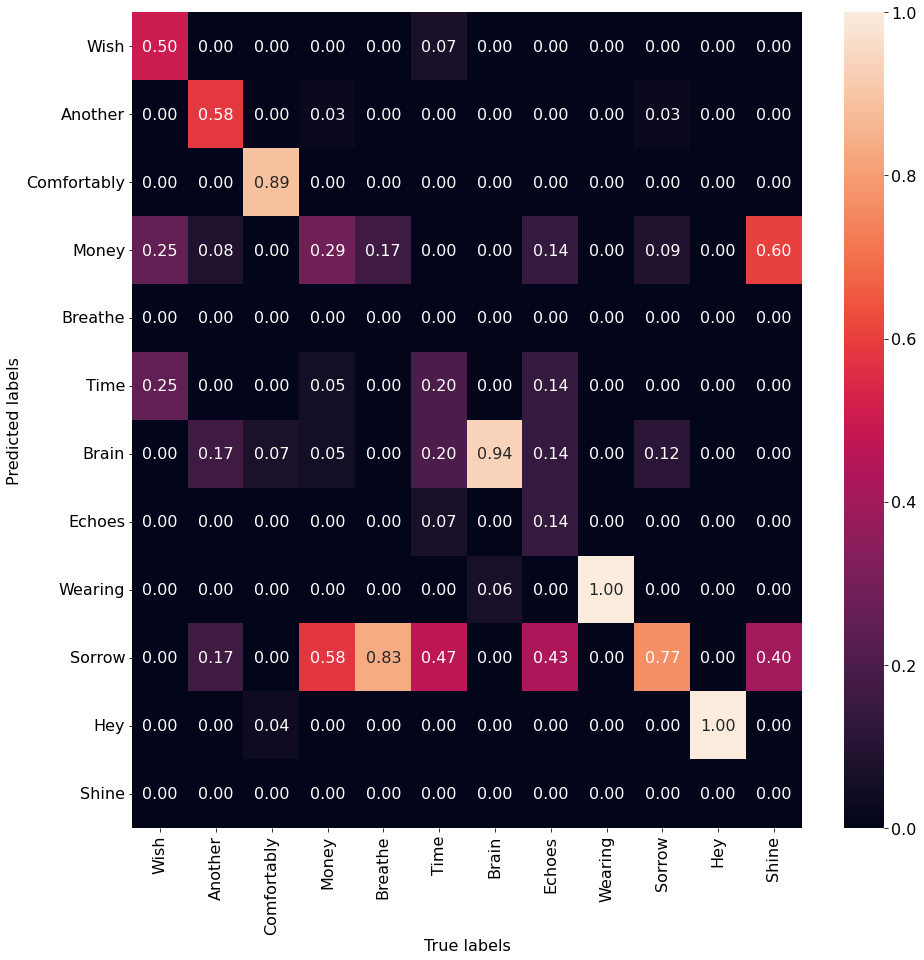

In [ ]:
ret = evaluate_model_m(model, X_test, y_test, classes)

In [ ]:
model.save('models/CNN1')
# model = tfk.models.load_model('1DCNN')

### Convolutional Neural Network - Medium depth architecture (Adam optimizer)


Define the model architecture:

In [ ]:
def build_CNN3(input_shape=input_shape, n_output=n_output, n1=64, n2=128, n3=256, n4=512, n5=512, nc=256, activation='relu', filter_size=3, dp_rate=0.3, dp_rate1=0.3, dp_rate2=0.3, learning_r=1e-3, lmbd=1e-5):

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    x = tfkl.Conv1D(n1,filter_size,padding='same',activation=activation)(input_layer)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Conv1D(n2,filter_size,padding='same',activation=activation)(x)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Dropout(dp_rate1, seed=seed)(x)
    x = tfkl.Conv1D(n3,filter_size,padding='same',activation=activation)(x)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Conv1D(n4,filter_size,padding='same',activation=activation)(x)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Dropout(dp_rate2, seed=seed)(x)
    x = tfkl.Conv1D(n5,filter_size,padding='same',activation=activation)(x)
    #x = tfkl.GlobalAveragePooling1D()(x)
    x = tfkl.Flatten()(x)
    dropout = tfkl.Dropout(dp_rate, seed=seed)(x)

    # Classifier
    classifier = tfkl.Dense(nc, activation=activation, kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer=tf.keras.regularizers.l2(lmbd))(dropout)
    output_layer = tfkl.Dense(n_output, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='Trad_1D_cnn')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=learning_r), metrics='accuracy')

    # Return the model
    return model

Find the best hyperparameter configuration

In [ ]:
# model class to use in the scikit parameter search CV 
model = KerasClassifier(build_fn=build_CNN3,  n1=64, n2=128, n3=256, n4=512, n5=512, nc=256, activation='relu', filter_size=3, dp_rate=0.3, dp_rate1=0.3, dp_rate2=0.3, learning_r=1e-3, lmbd=1e-5)

In [ ]:
# define the hyperparameters to tune
hyperparameters = {
    'epochs': [50,70],
    'batch_size': [32, 64, 128],
    'activation': ['relu'],
    'n1': np.arange(64, 256, 20), 
    'n2': np.arange(64, 256, 20), 
    'n3': np.arange(64, 512, 20), 
    'n4': np.arange(64, 512, 20), 
    'n5': np.arange(64, 1124, 20), 
    'nc': np.arange(64, 512, 20), 
    'filter_size': [3,4,2], 
    'learning_r': [1e-2,1e-3,1e-4,1e-5], 
    'lmbd':[1e-1,1e-2,1e-3,1e-4,1e-5],
    'dp_rate': np.arange(0, 0.5, 0.05),
    'dp_rate1': np.arange(0, 0.5, 0.05),
    'dp_rate2': np.arange(0, 0.5, 0.05)
}

In [ ]:
# create the random search object
rs = BayesSearchCV(estimator=model, search_spaces=hyperparameters, cv=5, n_iter=10)

In [ ]:
# fit the random search object to the training data
rs.fit(X_train, y_train)

# view the best hyperparameters
print(rs.best_params_)
print(rs.best_score_)

Epoch 1/69


/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 11ms/step - loss: 2.4560 - accuracy: 0.2422
Epoch 2/69
25/25 [==============================] - 0s 5ms/step - loss: 2.4002 - accuracy: 0.3363
Epoch 3/69
25/25 [==============================] - 0s 5ms/step - loss: 2.3094 - accuracy: 0.3535
Epoch 4/69
25/25 [==============================] - 0s 5ms/step - loss: 2.1607 - accuracy: 0.3490
Epoch 5/69
25/25 [==============================] - 0s 6ms/step - loss: 1.9928 - accuracy: 0.3605
Epoch 6/69
25/25 [==============================] - 0s 5ms/step - loss: 1.9218 - accuracy: 0.3732
Epoch 7/69
25/25 [==============================] - 0s 6ms/step - loss: 1.8907 - accuracy: 0.3776
Epoch 8/69
25/25 [==============================] - 0s 6ms/step - loss: 1.8669 - accuracy: 0.3795
Epoch 9/69
25/25 [==============================] - 0s 5ms/step - loss: 1.8432 - accuracy: 0.3884
Epoch 10/69
25/25 [==============================] - 0s 5ms/step - loss: 1.8185 - accuracy: 0.3961
Epoch 11/69
25/25 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 7ms/step - loss: 2.4541 - accuracy: 0.3045
Epoch 2/69
25/25 [==============================] - 0s 6ms/step - loss: 2.4063 - accuracy: 0.3261
Epoch 3/69
25/25 [==============================] - 0s 6ms/step - loss: 2.3287 - accuracy: 0.3516
Epoch 4/69
25/25 [==============================] - 0s 6ms/step - loss: 2.1924 - accuracy: 0.3465
Epoch 5/69
25/25 [==============================] - 0s 6ms/step - loss: 2.0243 - accuracy: 0.3528
Epoch 6/69
25/25 [==============================] - 0s 6ms/step - loss: 1.9430 - accuracy: 0.3649
Epoch 7/69
25/25 [==============================] - 0s 6ms/step - loss: 1.8974 - accuracy: 0.3732
Epoch 8/69
25/25 [==============================] - 0s 6ms/step - loss: 1.8790 - accuracy: 0.3751
Epoch 9/69
25/25 [==============================] - 0s 6ms/step - loss: 1.8576 - accuracy: 0.3859
Epoch 10/69
25/25 [==============================] - 0s 6ms/step - loss: 1.8363 - accuracy: 0.3903
Epoch 11/69
25/25 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 13ms/step - loss: 2.4617 - accuracy: 0.2370
Epoch 2/69
25/25 [==============================] - 0s 6ms/step - loss: 2.4074 - accuracy: 0.3361
Epoch 3/69
25/25 [==============================] - 0s 5ms/step - loss: 2.3519 - accuracy: 0.3431
Epoch 4/69
25/25 [==============================] - 0s 5ms/step - loss: 2.2383 - accuracy: 0.3412
Epoch 5/69
25/25 [==============================] - 0s 5ms/step - loss: 2.0809 - accuracy: 0.3532
Epoch 6/69
25/25 [==============================] - 0s 5ms/step - loss: 1.9831 - accuracy: 0.3558
Epoch 7/69
25/25 [==============================] - 0s 5ms/step - loss: 1.9311 - accuracy: 0.3679
Epoch 8/69
25/25 [==============================] - 0s 5ms/step - loss: 1.8960 - accuracy: 0.3717
Epoch 9/69
25/25 [==============================] - 0s 6ms/step - loss: 1.9037 - accuracy: 0.3704
Epoch 10/69
25/25 [==============================] - 0s 5ms/step - loss: 1.8589 - accuracy: 0.3837
Epoch 11/69
25/25 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 8ms/step - loss: 2.4678 - accuracy: 0.2649
Epoch 2/69
25/25 [==============================] - 0s 7ms/step - loss: 2.4140 - accuracy: 0.3418
Epoch 3/69
25/25 [==============================] - 0s 6ms/step - loss: 2.3448 - accuracy: 0.3418
Epoch 4/69
25/25 [==============================] - 0s 6ms/step - loss: 2.2424 - accuracy: 0.3405
Epoch 5/69
25/25 [==============================] - 0s 6ms/step - loss: 2.0899 - accuracy: 0.3494
Epoch 6/69
25/25 [==============================] - 0s 6ms/step - loss: 1.9954 - accuracy: 0.3520
Epoch 7/69
25/25 [==============================] - 0s 5ms/step - loss: 1.9404 - accuracy: 0.3640
Epoch 8/69
25/25 [==============================] - 0s 5ms/step - loss: 1.9111 - accuracy: 0.3679
Epoch 9/69
25/25 [==============================] - 0s 6ms/step - loss: 1.8697 - accuracy: 0.3787
Epoch 10/69
25/25 [==============================] - 0s 5ms/step - loss: 1.8573 - accuracy: 0.3825
Epoch 11/69
25/25 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 5ms/step - loss: 2.4635 - accuracy: 0.2859
Epoch 2/69
25/25 [==============================] - 0s 5ms/step - loss: 2.3942 - accuracy: 0.3348
Epoch 3/69
25/25 [==============================] - 0s 6ms/step - loss: 2.3207 - accuracy: 0.3412
Epoch 4/69
25/25 [==============================] - 0s 5ms/step - loss: 2.1916 - accuracy: 0.3405
Epoch 5/69
25/25 [==============================] - 0s 6ms/step - loss: 2.0404 - accuracy: 0.3526
Epoch 6/69
25/25 [==============================] - 0s 5ms/step - loss: 1.9654 - accuracy: 0.3640
Epoch 7/69
25/25 [==============================] - 0s 5ms/step - loss: 1.9240 - accuracy: 0.3666
Epoch 8/69
25/25 [==============================] - 0s 5ms/step - loss: 1.8977 - accuracy: 0.3717
Epoch 9/69
25/25 [==============================] - 0s 6ms/step - loss: 1.8807 - accuracy: 0.3812
Epoch 10/69
25/25 [==============================] - 0s 5ms/step - loss: 1.8654 - accuracy: 0.3748
Epoch 11/69
25/25 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 11ms/step - loss: 3.3810 - accuracy: 0.2816
Epoch 2/69
25/25 [==============================] - 0s 5ms/step - loss: 3.2874 - accuracy: 0.3401
Epoch 3/69
25/25 [==============================] - 0s 6ms/step - loss: 3.2131 - accuracy: 0.3477
Epoch 4/69
25/25 [==============================] - 0s 5ms/step - loss: 3.1029 - accuracy: 0.3439
Epoch 5/69
25/25 [==============================] - 0s 6ms/step - loss: 2.9615 - accuracy: 0.3446
Epoch 6/69
25/25 [==============================] - 0s 5ms/step - loss: 2.8228 - accuracy: 0.3522
Epoch 7/69
25/25 [==============================] - 0s 5ms/step - loss: 2.7396 - accuracy: 0.3605
Epoch 8/69
25/25 [==============================] - 0s 6ms/step - loss: 2.6821 - accuracy: 0.3668
Epoch 9/69
25/25 [==============================] - 0s 6ms/step - loss: 2.6402 - accuracy: 0.3630
Epoch 10/69
25/25 [==============================] - 0s 6ms/step - loss: 2.5954 - accuracy: 0.3770
Epoch 11/69
25/25 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 6ms/step - loss: 3.3659 - accuracy: 0.3147
Epoch 2/69
25/25 [==============================] - 0s 6ms/step - loss: 3.2863 - accuracy: 0.3350
Epoch 3/69
25/25 [==============================] - 0s 7ms/step - loss: 3.2188 - accuracy: 0.3465
Epoch 4/69
25/25 [==============================] - 0s 6ms/step - loss: 3.1157 - accuracy: 0.3458
Epoch 5/69
25/25 [==============================] - 0s 6ms/step - loss: 2.9702 - accuracy: 0.3516
Epoch 6/69
25/25 [==============================] - 0s 6ms/step - loss: 2.8119 - accuracy: 0.3503
Epoch 7/69
25/25 [==============================] - 0s 6ms/step - loss: 2.7271 - accuracy: 0.3700
Epoch 8/69
25/25 [==============================] - 0s 6ms/step - loss: 2.6852 - accuracy: 0.3662
Epoch 9/69
25/25 [==============================] - 0s 6ms/step - loss: 2.6310 - accuracy: 0.3725
Epoch 10/69
25/25 [==============================] - 0s 5ms/step - loss: 2.5910 - accuracy: 0.3764
Epoch 11/69
25/25 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 14ms/step - loss: 3.3655 - accuracy: 0.1900
Epoch 2/69
25/25 [==============================] - 0s 6ms/step - loss: 3.2875 - accuracy: 0.3259
Epoch 3/69
25/25 [==============================] - 0s 5ms/step - loss: 3.2115 - accuracy: 0.3367
Epoch 4/69
25/25 [==============================] - 0s 5ms/step - loss: 3.1142 - accuracy: 0.3348
Epoch 5/69
25/25 [==============================] - 0s 5ms/step - loss: 2.9704 - accuracy: 0.3386
Epoch 6/69
25/25 [==============================] - 0s 5ms/step - loss: 2.8453 - accuracy: 0.3431
Epoch 7/69
25/25 [==============================] - 0s 5ms/step - loss: 2.7453 - accuracy: 0.3520
Epoch 8/69
25/25 [==============================] - 0s 6ms/step - loss: 2.6991 - accuracy: 0.3532
Epoch 9/69
25/25 [==============================] - 0s 6ms/step - loss: 2.6570 - accuracy: 0.3596
Epoch 10/69
25/25 [==============================] - 0s 5ms/step - loss: 2.6169 - accuracy: 0.3640
Epoch 11/69
25/25 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 6ms/step - loss: 3.3819 - accuracy: 0.3011
Epoch 2/69
25/25 [==============================] - 0s 6ms/step - loss: 3.3072 - accuracy: 0.3361
Epoch 3/69
25/25 [==============================] - 0s 6ms/step - loss: 3.2339 - accuracy: 0.3463
Epoch 4/69
25/25 [==============================] - 0s 6ms/step - loss: 3.1331 - accuracy: 0.3412
Epoch 5/69
25/25 [==============================] - 0s 6ms/step - loss: 3.0183 - accuracy: 0.3361
Epoch 6/69
25/25 [==============================] - 0s 6ms/step - loss: 2.8709 - accuracy: 0.3399
Epoch 7/69
25/25 [==============================] - 0s 6ms/step - loss: 2.7772 - accuracy: 0.3520
Epoch 8/69
25/25 [==============================] - 0s 5ms/step - loss: 2.7213 - accuracy: 0.3602
Epoch 9/69
25/25 [==============================] - 0s 6ms/step - loss: 2.6828 - accuracy: 0.3672
Epoch 10/69
25/25 [==============================] - 0s 5ms/step - loss: 2.6388 - accuracy: 0.3615
Epoch 11/69
25/25 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 6ms/step - loss: 3.3687 - accuracy: 0.3018
Epoch 2/69
25/25 [==============================] - 0s 6ms/step - loss: 3.2746 - accuracy: 0.3463
Epoch 3/69
25/25 [==============================] - 0s 6ms/step - loss: 3.1868 - accuracy: 0.3405
Epoch 4/69
25/25 [==============================] - 0s 6ms/step - loss: 3.0630 - accuracy: 0.3374
Epoch 5/69
25/25 [==============================] - 0s 5ms/step - loss: 2.9043 - accuracy: 0.3393
Epoch 6/69
25/25 [==============================] - 0s 6ms/step - loss: 2.7782 - accuracy: 0.3539
Epoch 7/69
25/25 [==============================] - 0s 6ms/step - loss: 2.7104 - accuracy: 0.3647
Epoch 8/69
25/25 [==============================] - 0s 6ms/step - loss: 2.6647 - accuracy: 0.3640
Epoch 9/69
25/25 [==============================] - 0s 6ms/step - loss: 2.6331 - accuracy: 0.3717
Epoch 10/69
25/25 [==============================] - 0s 6ms/step - loss: 2.5932 - accuracy: 0.3659
Epoch 11/69
25/25 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


50/50 [==============================] - 1s 8ms/step - loss: 3.1742 - accuracy: 0.3115
Epoch 2/51
50/50 [==============================] - 0s 5ms/step - loss: 2.9270 - accuracy: 0.3452
Epoch 3/51
50/50 [==============================] - 0s 5ms/step - loss: 2.6276 - accuracy: 0.3535
Epoch 4/51
50/50 [==============================] - 0s 5ms/step - loss: 2.4818 - accuracy: 0.3706
Epoch 5/51
50/50 [==============================] - 0s 5ms/step - loss: 2.4094 - accuracy: 0.3840
Epoch 6/51
50/50 [==============================] - 0s 5ms/step - loss: 2.3538 - accuracy: 0.3884
Epoch 7/51
50/50 [==============================] - 0s 5ms/step - loss: 2.3034 - accuracy: 0.3967
Epoch 8/51
50/50 [==============================] - 0s 5ms/step - loss: 2.2618 - accuracy: 0.3967
Epoch 9/51
50/50 [==============================] - 0s 5ms/step - loss: 2.2247 - accuracy: 0.4050
Epoch 10/51
50/50 [==============================] - 0s 5ms/step - loss: 2.1870 - accuracy: 0.4088
Epoch 11/51
50/50 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


50/50 [==============================] - 1s 6ms/step - loss: 3.1715 - accuracy: 0.3446
Epoch 2/51
50/50 [==============================] - 0s 5ms/step - loss: 2.9110 - accuracy: 0.3439
Epoch 3/51
50/50 [==============================] - 0s 5ms/step - loss: 2.6001 - accuracy: 0.3617
Epoch 4/51
50/50 [==============================] - 0s 6ms/step - loss: 2.4428 - accuracy: 0.3764
Epoch 5/51
50/50 [==============================] - 0s 6ms/step - loss: 2.3588 - accuracy: 0.3910
Epoch 6/51
50/50 [==============================] - 0s 6ms/step - loss: 2.3063 - accuracy: 0.3929
Epoch 7/51
50/50 [==============================] - 0s 5ms/step - loss: 2.2509 - accuracy: 0.4043
Epoch 8/51
50/50 [==============================] - 0s 6ms/step - loss: 2.2408 - accuracy: 0.3980
Epoch 9/51
50/50 [==============================] - 0s 5ms/step - loss: 2.1951 - accuracy: 0.4050
Epoch 10/51
50/50 [==============================] - 0s 5ms/step - loss: 2.1201 - accuracy: 0.4247
Epoch 11/51
50/50 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


50/50 [==============================] - 1s 9ms/step - loss: 3.1900 - accuracy: 0.3075
Epoch 2/51
50/50 [==============================] - 0s 5ms/step - loss: 2.9577 - accuracy: 0.3450
Epoch 3/51
50/50 [==============================] - 0s 5ms/step - loss: 2.6545 - accuracy: 0.3463
Epoch 4/51
50/50 [==============================] - 0s 5ms/step - loss: 2.5101 - accuracy: 0.3640
Epoch 5/51
50/50 [==============================] - 0s 5ms/step - loss: 2.4392 - accuracy: 0.3717
Epoch 6/51
50/50 [==============================] - 0s 5ms/step - loss: 2.3826 - accuracy: 0.3812
Epoch 7/51
50/50 [==============================] - 0s 5ms/step - loss: 2.3199 - accuracy: 0.3926
Epoch 8/51
50/50 [==============================] - 0s 5ms/step - loss: 2.2717 - accuracy: 0.3971
Epoch 9/51
50/50 [==============================] - 0s 5ms/step - loss: 2.2287 - accuracy: 0.3996
Epoch 10/51
50/50 [==============================] - 0s 5ms/step - loss: 2.1901 - accuracy: 0.4149
Epoch 11/51
50/50 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


50/50 [==============================] - 1s 5ms/step - loss: 3.2039 - accuracy: 0.2764
Epoch 2/51
50/50 [==============================] - 0s 5ms/step - loss: 2.9951 - accuracy: 0.3418
Epoch 3/51
50/50 [==============================] - 0s 6ms/step - loss: 2.7130 - accuracy: 0.3469
Epoch 4/51
50/50 [==============================] - 0s 5ms/step - loss: 2.5385 - accuracy: 0.3628
Epoch 5/51
50/50 [==============================] - 0s 5ms/step - loss: 2.4525 - accuracy: 0.3710
Epoch 6/51
50/50 [==============================] - 0s 5ms/step - loss: 2.3910 - accuracy: 0.3755
Epoch 7/51
50/50 [==============================] - 0s 5ms/step - loss: 2.3443 - accuracy: 0.3875
Epoch 8/51
50/50 [==============================] - 0s 5ms/step - loss: 2.2710 - accuracy: 0.4015
Epoch 9/51
50/50 [==============================] - 0s 5ms/step - loss: 2.2553 - accuracy: 0.4091
Epoch 10/51
50/50 [==============================] - 0s 5ms/step - loss: 2.1912 - accuracy: 0.4098
Epoch 11/51
50/50 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


50/50 [==============================] - 1s 5ms/step - loss: 3.1834 - accuracy: 0.3259
Epoch 2/51
50/50 [==============================] - 0s 5ms/step - loss: 2.9307 - accuracy: 0.3424
Epoch 3/51
50/50 [==============================] - 0s 6ms/step - loss: 2.6223 - accuracy: 0.3501
Epoch 4/51
50/50 [==============================] - 0s 5ms/step - loss: 2.4765 - accuracy: 0.3685
Epoch 5/51
50/50 [==============================] - 0s 5ms/step - loss: 2.3915 - accuracy: 0.3799
Epoch 6/51
50/50 [==============================] - 0s 5ms/step - loss: 2.3267 - accuracy: 0.4047
Epoch 7/51
50/50 [==============================] - 0s 5ms/step - loss: 2.2885 - accuracy: 0.3958
Epoch 8/51
50/50 [==============================] - 0s 5ms/step - loss: 2.2062 - accuracy: 0.4219
Epoch 9/51
50/50 [==============================] - 0s 5ms/step - loss: 2.1561 - accuracy: 0.4333
Epoch 10/51
50/50 [==============================] - 0s 5ms/step - loss: 2.1264 - accuracy: 0.4257
Epoch 11/51
50/50 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 12ms/step - loss: 2.2784 - accuracy: 0.3325
Epoch 2/58
25/25 [==============================] - 0s 6ms/step - loss: 1.9703 - accuracy: 0.3713
Epoch 3/58
25/25 [==============================] - 0s 6ms/step - loss: 1.8594 - accuracy: 0.3916
Epoch 4/58
25/25 [==============================] - 0s 6ms/step - loss: 1.8055 - accuracy: 0.4113
Epoch 5/58
25/25 [==============================] - 0s 6ms/step - loss: 1.6684 - accuracy: 0.4355
Epoch 6/58
25/25 [==============================] - 0s 6ms/step - loss: 1.5942 - accuracy: 0.4641
Epoch 7/58
25/25 [==============================] - 0s 6ms/step - loss: 1.4483 - accuracy: 0.5156
Epoch 8/58
25/25 [==============================] - 0s 7ms/step - loss: 1.3893 - accuracy: 0.5474
Epoch 9/58
25/25 [==============================] - 0s 6ms/step - loss: 1.3975 - accuracy: 0.5404
Epoch 10/58
25/25 [==============================] - 0s 6ms/step - loss: 1.2600 - accuracy: 0.5785
Epoch 11/58
25/25 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 7ms/step - loss: 2.2612 - accuracy: 0.3293
Epoch 2/58
25/25 [==============================] - 0s 7ms/step - loss: 1.9322 - accuracy: 0.3738
Epoch 3/58
25/25 [==============================] - 0s 6ms/step - loss: 1.8364 - accuracy: 0.3916
Epoch 4/58
25/25 [==============================] - 0s 6ms/step - loss: 1.7480 - accuracy: 0.4183
Epoch 5/58
25/25 [==============================] - 0s 6ms/step - loss: 1.6579 - accuracy: 0.4374
Epoch 6/58
25/25 [==============================] - 0s 6ms/step - loss: 1.6287 - accuracy: 0.4571
Epoch 7/58
25/25 [==============================] - 0s 6ms/step - loss: 1.4978 - accuracy: 0.4908
Epoch 8/58
25/25 [==============================] - 0s 6ms/step - loss: 1.3733 - accuracy: 0.5302
Epoch 9/58
25/25 [==============================] - 0s 6ms/step - loss: 1.3300 - accuracy: 0.5594
Epoch 10/58
25/25 [==============================] - 0s 6ms/step - loss: 1.2638 - accuracy: 0.5900
Epoch 11/58
25/25 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 14ms/step - loss: 2.3236 - accuracy: 0.2713
Epoch 2/58
25/25 [==============================] - 0s 6ms/step - loss: 1.9798 - accuracy: 0.3609
Epoch 3/58
25/25 [==============================] - 0s 6ms/step - loss: 1.9057 - accuracy: 0.3787
Epoch 4/58
25/25 [==============================] - 0s 6ms/step - loss: 1.8198 - accuracy: 0.4009
Epoch 5/58
25/25 [==============================] - 0s 6ms/step - loss: 1.7490 - accuracy: 0.4155
Epoch 6/58
25/25 [==============================] - 0s 6ms/step - loss: 1.6569 - accuracy: 0.4314
Epoch 7/58
25/25 [==============================] - 0s 6ms/step - loss: 1.5719 - accuracy: 0.4670
Epoch 8/58
25/25 [==============================] - 0s 6ms/step - loss: 1.4729 - accuracy: 0.5000
Epoch 9/58
25/25 [==============================] - 0s 6ms/step - loss: 1.4708 - accuracy: 0.5064
Epoch 10/58
25/25 [==============================] - 0s 6ms/step - loss: 1.3722 - accuracy: 0.5438
Epoch 11/58
25/25 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 6ms/step - loss: 2.3220 - accuracy: 0.3132
Epoch 2/58
25/25 [==============================] - 0s 6ms/step - loss: 1.9725 - accuracy: 0.3539
Epoch 3/58
25/25 [==============================] - 0s 6ms/step - loss: 1.8769 - accuracy: 0.3901
Epoch 4/58
25/25 [==============================] - 0s 6ms/step - loss: 1.7791 - accuracy: 0.4123
Epoch 5/58
25/25 [==============================] - 0s 6ms/step - loss: 1.6689 - accuracy: 0.4314
Epoch 6/58
25/25 [==============================] - 0s 6ms/step - loss: 1.5501 - accuracy: 0.4803
Epoch 7/58
25/25 [==============================] - 0s 6ms/step - loss: 1.5036 - accuracy: 0.4975
Epoch 8/58
25/25 [==============================] - 0s 6ms/step - loss: 1.4308 - accuracy: 0.5152
Epoch 9/58
25/25 [==============================] - 0s 6ms/step - loss: 1.2962 - accuracy: 0.5693
Epoch 10/58
25/25 [==============================] - 0s 6ms/step - loss: 1.2649 - accuracy: 0.5794
Epoch 11/58
25/25 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 7ms/step - loss: 2.2857 - accuracy: 0.3247
Epoch 2/58
25/25 [==============================] - 0s 6ms/step - loss: 1.9695 - accuracy: 0.3628
Epoch 3/58
25/25 [==============================] - 0s 6ms/step - loss: 1.8747 - accuracy: 0.3907
Epoch 4/58
25/25 [==============================] - 0s 6ms/step - loss: 1.8252 - accuracy: 0.4174
Epoch 5/58
25/25 [==============================] - 0s 6ms/step - loss: 1.7373 - accuracy: 0.4314
Epoch 6/58
25/25 [==============================] - 0s 6ms/step - loss: 1.6314 - accuracy: 0.4371
Epoch 7/58
25/25 [==============================] - 0s 6ms/step - loss: 1.6153 - accuracy: 0.4606
Epoch 8/58
25/25 [==============================] - 0s 6ms/step - loss: 1.5668 - accuracy: 0.4790
Epoch 9/58
25/25 [==============================] - 0s 6ms/step - loss: 1.3536 - accuracy: 0.5496
Epoch 10/58
25/25 [==============================] - 0s 6ms/step - loss: 1.2631 - accuracy: 0.5762
Epoch 11/58
25/25 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 2s 17ms/step - loss: 2.2350 - accuracy: 0.3414
Epoch 2/59
25/25 [==============================] - 0s 8ms/step - loss: 1.9723 - accuracy: 0.3783
Epoch 3/59
25/25 [==============================] - 0s 8ms/step - loss: 1.8544 - accuracy: 0.4075
Epoch 4/59
25/25 [==============================] - 0s 8ms/step - loss: 1.7712 - accuracy: 0.4113
Epoch 5/59
25/25 [==============================] - 0s 8ms/step - loss: 1.6446 - accuracy: 0.4679
Epoch 6/59
25/25 [==============================] - 0s 8ms/step - loss: 1.5561 - accuracy: 0.4971
Epoch 7/59
25/25 [==============================] - 0s 8ms/step - loss: 1.5212 - accuracy: 0.5048
Epoch 8/59
25/25 [==============================] - 0s 8ms/step - loss: 1.3282 - accuracy: 0.5613
Epoch 9/59
25/25 [==============================] - 0s 8ms/step - loss: 1.3010 - accuracy: 0.5645
Epoch 10/59
25/25 [==============================] - 0s 8ms/step - loss: 1.3141 - accuracy: 0.5715
Epoch 11/59
25/25 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 11ms/step - loss: 2.2166 - accuracy: 0.3452
Epoch 2/59
25/25 [==============================] - 0s 8ms/step - loss: 1.9420 - accuracy: 0.3954
Epoch 3/59
25/25 [==============================] - 0s 8ms/step - loss: 1.8235 - accuracy: 0.4170
Epoch 4/59
25/25 [==============================] - 0s 8ms/step - loss: 1.7404 - accuracy: 0.4298
Epoch 5/59
25/25 [==============================] - 0s 8ms/step - loss: 1.6995 - accuracy: 0.4482
Epoch 6/59
25/25 [==============================] - 0s 8ms/step - loss: 1.5295 - accuracy: 0.4927
Epoch 7/59
25/25 [==============================] - 0s 8ms/step - loss: 1.4803 - accuracy: 0.5111
Epoch 8/59
25/25 [==============================] - 0s 8ms/step - loss: 1.3168 - accuracy: 0.5785
Epoch 9/59
25/25 [==============================] - 0s 8ms/step - loss: 1.3760 - accuracy: 0.5518
Epoch 10/59
25/25 [==============================] - 0s 8ms/step - loss: 1.2281 - accuracy: 0.5969
Epoch 11/59
25/25 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 21ms/step - loss: 2.2881 - accuracy: 0.3094
Epoch 2/59
25/25 [==============================] - 0s 8ms/step - loss: 2.0010 - accuracy: 0.3698
Epoch 3/59
25/25 [==============================] - 0s 8ms/step - loss: 1.9111 - accuracy: 0.3895
Epoch 4/59
25/25 [==============================] - 0s 8ms/step - loss: 1.7807 - accuracy: 0.4149
Epoch 5/59
25/25 [==============================] - 0s 8ms/step - loss: 1.6263 - accuracy: 0.4536
Epoch 6/59
25/25 [==============================] - 0s 8ms/step - loss: 1.5779 - accuracy: 0.4873
Epoch 7/59
25/25 [==============================] - 0s 8ms/step - loss: 1.4436 - accuracy: 0.5235
Epoch 8/59
25/25 [==============================] - 0s 8ms/step - loss: 1.3234 - accuracy: 0.5743
Epoch 9/59
25/25 [==============================] - 0s 8ms/step - loss: 1.3235 - accuracy: 0.5584
Epoch 10/59
25/25 [==============================] - 0s 8ms/step - loss: 1.2474 - accuracy: 0.5928
Epoch 11/59
25/25 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 11ms/step - loss: 2.3070 - accuracy: 0.3094
Epoch 2/59
25/25 [==============================] - 0s 9ms/step - loss: 1.9840 - accuracy: 0.3717
Epoch 3/59
25/25 [==============================] - 0s 8ms/step - loss: 1.8852 - accuracy: 0.3914
Epoch 4/59
25/25 [==============================] - 0s 8ms/step - loss: 1.7824 - accuracy: 0.4091
Epoch 5/59
25/25 [==============================] - 0s 8ms/step - loss: 1.6771 - accuracy: 0.4435
Epoch 6/59
25/25 [==============================] - 0s 8ms/step - loss: 1.5555 - accuracy: 0.4867
Epoch 7/59
25/25 [==============================] - 0s 8ms/step - loss: 1.4859 - accuracy: 0.4975
Epoch 8/59
25/25 [==============================] - 0s 8ms/step - loss: 1.3528 - accuracy: 0.5502
Epoch 9/59
25/25 [==============================] - 0s 8ms/step - loss: 1.2677 - accuracy: 0.5858
Epoch 10/59
25/25 [==============================] - 0s 8ms/step - loss: 1.2314 - accuracy: 0.5928
Epoch 11/59
25/25 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 12ms/step - loss: 2.2425 - accuracy: 0.3113
Epoch 2/59
25/25 [==============================] - 0s 9ms/step - loss: 1.9789 - accuracy: 0.3837
Epoch 3/59
25/25 [==============================] - 0s 8ms/step - loss: 1.8940 - accuracy: 0.3920
Epoch 4/59
25/25 [==============================] - 0s 8ms/step - loss: 1.7581 - accuracy: 0.4180
Epoch 5/59
25/25 [==============================] - 0s 8ms/step - loss: 1.5785 - accuracy: 0.4822
Epoch 6/59
25/25 [==============================] - 0s 8ms/step - loss: 1.6137 - accuracy: 0.4790
Epoch 7/59
25/25 [==============================] - 0s 8ms/step - loss: 1.4507 - accuracy: 0.5152
Epoch 8/59
25/25 [==============================] - 0s 8ms/step - loss: 1.3025 - accuracy: 0.5667
Epoch 9/59
25/25 [==============================] - 0s 8ms/step - loss: 1.2340 - accuracy: 0.6023
Epoch 10/59
25/25 [==============================] - 0s 8ms/step - loss: 1.2304 - accuracy: 0.5978
Epoch 11/59
25/25 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 25ms/step - loss: 5.8268 - accuracy: 0.2835
Epoch 2/53
13/13 [==============================] - 0s 8ms/step - loss: 4.2403 - accuracy: 0.3579
Epoch 3/53
13/13 [==============================] - 0s 9ms/step - loss: 3.4585 - accuracy: 0.3662
Epoch 4/53
13/13 [==============================] - 0s 8ms/step - loss: 2.8828 - accuracy: 0.3764
Epoch 5/53
13/13 [==============================] - 0s 8ms/step - loss: 2.4498 - accuracy: 0.4050
Epoch 6/53
13/13 [==============================] - 0s 8ms/step - loss: 2.1932 - accuracy: 0.4126
Epoch 7/53
13/13 [==============================] - 0s 8ms/step - loss: 2.0443 - accuracy: 0.4107
Epoch 8/53
13/13 [==============================] - 0s 8ms/step - loss: 1.9370 - accuracy: 0.4145
Epoch 9/53
13/13 [==============================] - 0s 8ms/step - loss: 2.0700 - accuracy: 0.3808
Epoch 10/53
13/13 [==============================] - 0s 8ms/step - loss: 1.9233 - accuracy: 0.4050
Epoch 11/53
13/13 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 12ms/step - loss: 5.2125 - accuracy: 0.2066
Epoch 2/53
13/13 [==============================] - 0s 12ms/step - loss: 3.9694 - accuracy: 0.3229
Epoch 3/53
13/13 [==============================] - 0s 9ms/step - loss: 3.2873 - accuracy: 0.3229
Epoch 4/53
13/13 [==============================] - 0s 8ms/step - loss: 2.7991 - accuracy: 0.3229
Epoch 5/53
13/13 [==============================] - 0s 8ms/step - loss: 2.5067 - accuracy: 0.3229
Epoch 6/53
13/13 [==============================] - 0s 9ms/step - loss: 2.3697 - accuracy: 0.3280
Epoch 7/53
13/13 [==============================] - 0s 9ms/step - loss: 2.2271 - accuracy: 0.3427
Epoch 8/53
13/13 [==============================] - 0s 8ms/step - loss: 2.1496 - accuracy: 0.3592
Epoch 9/53
13/13 [==============================] - 0s 8ms/step - loss: 2.0687 - accuracy: 0.3700
Epoch 10/53
13/13 [==============================] - 0s 8ms/step - loss: 1.9757 - accuracy: 0.3884
Epoch 11/53
13/13 [=========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 24ms/step - loss: 6.2895 - accuracy: 0.2643
Epoch 2/53
13/13 [==============================] - 0s 8ms/step - loss: 3.7655 - accuracy: 0.3488
Epoch 3/53
13/13 [==============================] - 0s 8ms/step - loss: 3.1889 - accuracy: 0.3507
Epoch 4/53
13/13 [==============================] - 0s 8ms/step - loss: 2.6771 - accuracy: 0.3888
Epoch 5/53
13/13 [==============================] - 0s 8ms/step - loss: 2.4143 - accuracy: 0.3914
Epoch 6/53
13/13 [==============================] - 0s 8ms/step - loss: 2.1929 - accuracy: 0.3977
Epoch 7/53
13/13 [==============================] - 0s 8ms/step - loss: 2.0675 - accuracy: 0.4098
Epoch 8/53
13/13 [==============================] - 0s 8ms/step - loss: 1.9759 - accuracy: 0.4053
Epoch 9/53
13/13 [==============================] - 0s 8ms/step - loss: 1.9178 - accuracy: 0.4072
Epoch 10/53
13/13 [==============================] - 0s 8ms/step - loss: 1.9096 - accuracy: 0.4123
Epoch 11/53
13/13 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 8ms/step - loss: 7.1334 - accuracy: 0.2706
Epoch 2/53
13/13 [==============================] - 0s 8ms/step - loss: 4.2574 - accuracy: 0.3335
Epoch 3/53
13/13 [==============================] - 0s 8ms/step - loss: 3.6175 - accuracy: 0.3634
Epoch 4/53
13/13 [==============================] - 0s 8ms/step - loss: 3.0419 - accuracy: 0.3818
Epoch 5/53
13/13 [==============================] - 0s 8ms/step - loss: 2.6675 - accuracy: 0.3882
Epoch 6/53
13/13 [==============================] - 0s 7ms/step - loss: 2.4002 - accuracy: 0.3825
Epoch 7/53
13/13 [==============================] - 0s 8ms/step - loss: 2.1879 - accuracy: 0.4022
Epoch 8/53
13/13 [==============================] - 0s 9ms/step - loss: 2.0584 - accuracy: 0.4034
Epoch 9/53
13/13 [==============================] - 0s 9ms/step - loss: 2.0881 - accuracy: 0.3869
Epoch 10/53
13/13 [==============================] - 0s 10ms/step - loss: 1.9932 - accuracy: 0.4028
Epoch 11/53
13/13 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 14ms/step - loss: 6.6425 - accuracy: 0.2421
Epoch 2/53
13/13 [==============================] - 0s 12ms/step - loss: 4.0669 - accuracy: 0.3456
Epoch 3/53
13/13 [==============================] - 0s 10ms/step - loss: 3.3706 - accuracy: 0.3653
Epoch 4/53
13/13 [==============================] - 0s 8ms/step - loss: 2.8186 - accuracy: 0.3907
Epoch 5/53
13/13 [==============================] - 0s 8ms/step - loss: 2.4636 - accuracy: 0.4079
Epoch 6/53
13/13 [==============================] - 0s 9ms/step - loss: 2.2638 - accuracy: 0.4053
Epoch 7/53
13/13 [==============================] - 0s 8ms/step - loss: 2.1150 - accuracy: 0.4130
Epoch 8/53
13/13 [==============================] - 0s 8ms/step - loss: 2.0821 - accuracy: 0.3990
Epoch 9/53
13/13 [==============================] - 0s 8ms/step - loss: 1.9402 - accuracy: 0.4111
Epoch 10/53
13/13 [==============================] - 0s 8ms/step - loss: 1.9082 - accuracy: 0.4193
Epoch 11/53
13/13 [========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 25ms/step - loss: 3.0412 - accuracy: 0.2772
Epoch 2/62
13/13 [==============================] - 0s 10ms/step - loss: 2.5053 - accuracy: 0.3579
Epoch 3/62
13/13 [==============================] - 0s 9ms/step - loss: 2.2840 - accuracy: 0.3725
Epoch 4/62
13/13 [==============================] - 0s 9ms/step - loss: 2.1566 - accuracy: 0.3814
Epoch 5/62
13/13 [==============================] - 0s 10ms/step - loss: 2.0166 - accuracy: 0.4043
Epoch 6/62
13/13 [==============================] - 0s 10ms/step - loss: 1.9129 - accuracy: 0.4202
Epoch 7/62
13/13 [==============================] - 0s 10ms/step - loss: 1.8389 - accuracy: 0.4412
Epoch 8/62
13/13 [==============================] - 0s 10ms/step - loss: 1.6906 - accuracy: 0.4774
Epoch 9/62
13/13 [==============================] - 0s 11ms/step - loss: 1.6657 - accuracy: 0.4889
Epoch 10/62
13/13 [==============================] - 0s 9ms/step - loss: 1.5431 - accuracy: 0.5226
Epoch 11/62
13/13 [====

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 10ms/step - loss: 3.0632 - accuracy: 0.3115
Epoch 2/62
13/13 [==============================] - 0s 9ms/step - loss: 2.5161 - accuracy: 0.3592
Epoch 3/62
13/13 [==============================] - 0s 9ms/step - loss: 2.2848 - accuracy: 0.3751
Epoch 4/62
13/13 [==============================] - 0s 9ms/step - loss: 2.1427 - accuracy: 0.4037
Epoch 5/62
13/13 [==============================] - 0s 11ms/step - loss: 2.0135 - accuracy: 0.4215
Epoch 6/62
13/13 [==============================] - 0s 11ms/step - loss: 1.8639 - accuracy: 0.4526
Epoch 7/62
13/13 [==============================] - 0s 10ms/step - loss: 1.7775 - accuracy: 0.4641
Epoch 8/62
13/13 [==============================] - 0s 10ms/step - loss: 1.6625 - accuracy: 0.5073
Epoch 9/62
13/13 [==============================] - 0s 9ms/step - loss: 1.6199 - accuracy: 0.4978
Epoch 10/62
13/13 [==============================] - 0s 9ms/step - loss: 1.6390 - accuracy: 0.5251
Epoch 11/62
13/13 [======

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 34ms/step - loss: 3.0581 - accuracy: 0.2916
Epoch 2/62
13/13 [==============================] - 0s 10ms/step - loss: 2.4840 - accuracy: 0.3621
Epoch 3/62
13/13 [==============================] - 0s 9ms/step - loss: 2.2968 - accuracy: 0.3742
Epoch 4/62
13/13 [==============================] - 0s 9ms/step - loss: 2.0950 - accuracy: 0.4022
Epoch 5/62
13/13 [==============================] - 0s 9ms/step - loss: 1.9572 - accuracy: 0.4155
Epoch 6/62
13/13 [==============================] - 0s 10ms/step - loss: 1.8932 - accuracy: 0.4301
Epoch 7/62
13/13 [==============================] - 0s 9ms/step - loss: 1.7598 - accuracy: 0.4625
Epoch 8/62
13/13 [==============================] - 0s 10ms/step - loss: 1.6260 - accuracy: 0.5076
Epoch 9/62
13/13 [==============================] - 0s 10ms/step - loss: 1.5276 - accuracy: 0.5280
Epoch 10/62
13/13 [==============================] - 0s 9ms/step - loss: 1.4787 - accuracy: 0.5559
Epoch 11/62
13/13 [======

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 17ms/step - loss: 3.0764 - accuracy: 0.2897
Epoch 2/62
13/13 [==============================] - 0s 11ms/step - loss: 2.5116 - accuracy: 0.3577
Epoch 3/62
13/13 [==============================] - 0s 10ms/step - loss: 2.3279 - accuracy: 0.3806
Epoch 4/62
13/13 [==============================] - 0s 10ms/step - loss: 2.1461 - accuracy: 0.4034
Epoch 5/62
13/13 [==============================] - 0s 9ms/step - loss: 2.0297 - accuracy: 0.4111
Epoch 6/62
13/13 [==============================] - 0s 10ms/step - loss: 1.8828 - accuracy: 0.4466
Epoch 7/62
13/13 [==============================] - 0s 9ms/step - loss: 1.7863 - accuracy: 0.4454
Epoch 8/62
13/13 [==============================] - 0s 9ms/step - loss: 1.7422 - accuracy: 0.4765
Epoch 9/62
13/13 [==============================] - 0s 10ms/step - loss: 1.5832 - accuracy: 0.5064
Epoch 10/62
13/13 [==============================] - 0s 10ms/step - loss: 1.4763 - accuracy: 0.5540
Epoch 11/62
13/13 [====

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 17ms/step - loss: 3.0689 - accuracy: 0.2980
Epoch 2/62
13/13 [==============================] - 0s 12ms/step - loss: 2.4683 - accuracy: 0.3653
Epoch 3/62
13/13 [==============================] - 0s 11ms/step - loss: 2.2742 - accuracy: 0.3780
Epoch 4/62
13/13 [==============================] - 0s 10ms/step - loss: 2.0870 - accuracy: 0.3983
Epoch 5/62
13/13 [==============================] - 0s 10ms/step - loss: 1.9478 - accuracy: 0.4206
Epoch 6/62
13/13 [==============================] - 0s 10ms/step - loss: 1.8701 - accuracy: 0.4422
Epoch 7/62
13/13 [==============================] - 0s 10ms/step - loss: 1.7185 - accuracy: 0.4828
Epoch 8/62
13/13 [==============================] - 0s 10ms/step - loss: 1.6437 - accuracy: 0.5051
Epoch 9/62
13/13 [==============================] - 0s 10ms/step - loss: 1.4881 - accuracy: 0.5635
Epoch 10/62
13/13 [==============================] - 0s 10ms/step - loss: 1.4295 - accuracy: 0.5705
Epoch 11/62
13/13 [=

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 2s 16ms/step - loss: 2.4778 - accuracy: 0.1024
Epoch 2/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4559 - accuracy: 0.1049
Epoch 3/62
25/25 [==============================] - 0s 7ms/step - loss: 2.4464 - accuracy: 0.1532
Epoch 4/62
25/25 [==============================] - 0s 7ms/step - loss: 2.4320 - accuracy: 0.2498
Epoch 5/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4229 - accuracy: 0.3001
Epoch 6/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4162 - accuracy: 0.3242
Epoch 7/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4050 - accuracy: 0.3427
Epoch 8/62
25/25 [==============================] - 0s 7ms/step - loss: 2.3905 - accuracy: 0.3484
Epoch 9/62
25/25 [==============================] - 0s 8ms/step - loss: 2.3834 - accuracy: 0.3477
Epoch 10/62
25/25 [==============================] - 0s 8ms/step - loss: 2.3607 - accuracy: 0.3535
Epoch 11/62
25/25 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 11ms/step - loss: 2.4817 - accuracy: 0.1786
Epoch 2/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4598 - accuracy: 0.2009
Epoch 3/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4497 - accuracy: 0.2187
Epoch 4/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4391 - accuracy: 0.2727
Epoch 5/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4286 - accuracy: 0.3077
Epoch 6/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4148 - accuracy: 0.3210
Epoch 7/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4067 - accuracy: 0.3363
Epoch 8/62
25/25 [==============================] - 0s 8ms/step - loss: 2.3940 - accuracy: 0.3433
Epoch 9/62
25/25 [==============================] - 0s 8ms/step - loss: 2.3807 - accuracy: 0.3471
Epoch 10/62
25/25 [==============================] - 0s 7ms/step - loss: 2.3682 - accuracy: 0.3509
Epoch 11/62
25/25 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 2s 22ms/step - loss: 2.4775 - accuracy: 0.0616
Epoch 2/62
25/25 [==============================] - 0s 9ms/step - loss: 2.4568 - accuracy: 0.0591
Epoch 3/62
25/25 [==============================] - 0s 10ms/step - loss: 2.4483 - accuracy: 0.1220
Epoch 4/62
25/25 [==============================] - 0s 9ms/step - loss: 2.4415 - accuracy: 0.2027
Epoch 5/62
25/25 [==============================] - 0s 9ms/step - loss: 2.4302 - accuracy: 0.2573
Epoch 6/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4220 - accuracy: 0.2910
Epoch 7/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4155 - accuracy: 0.3081
Epoch 8/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4077 - accuracy: 0.3227
Epoch 9/62
25/25 [==============================] - 0s 8ms/step - loss: 2.3936 - accuracy: 0.3361
Epoch 10/62
25/25 [==============================] - 0s 8ms/step - loss: 2.3838 - accuracy: 0.3335
Epoch 11/62
25/25 [=========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 8ms/step - loss: 2.4832 - accuracy: 0.0680
Epoch 2/62
25/25 [==============================] - 0s 7ms/step - loss: 2.4665 - accuracy: 0.1283
Epoch 3/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4553 - accuracy: 0.1779
Epoch 4/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4466 - accuracy: 0.2421
Epoch 5/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4400 - accuracy: 0.2783
Epoch 6/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4323 - accuracy: 0.3062
Epoch 7/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4244 - accuracy: 0.3215
Epoch 8/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4155 - accuracy: 0.3355
Epoch 9/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4042 - accuracy: 0.3335
Epoch 10/62
25/25 [==============================] - 0s 8ms/step - loss: 2.3953 - accuracy: 0.3418
Epoch 11/62
25/25 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 7ms/step - loss: 2.4818 - accuracy: 0.1252
Epoch 2/62
25/25 [==============================] - 0s 7ms/step - loss: 2.4608 - accuracy: 0.2116
Epoch 3/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4481 - accuracy: 0.2154
Epoch 4/62
25/25 [==============================] - 0s 7ms/step - loss: 2.4405 - accuracy: 0.2637
Epoch 5/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4279 - accuracy: 0.2973
Epoch 6/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4209 - accuracy: 0.3278
Epoch 7/62
25/25 [==============================] - 0s 8ms/step - loss: 2.4064 - accuracy: 0.3437
Epoch 8/62
25/25 [==============================] - 0s 8ms/step - loss: 2.3952 - accuracy: 0.3450
Epoch 9/62
25/25 [==============================] - 0s 8ms/step - loss: 2.3866 - accuracy: 0.3405
Epoch 10/62
25/25 [==============================] - 0s 8ms/step - loss: 2.3707 - accuracy: 0.3507
Epoch 11/62
25/25 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


50/50 [==============================] - 1s 9ms/step - loss: 2.5305 - accuracy: 0.3020
Epoch 2/69
50/50 [==============================] - 0s 5ms/step - loss: 2.2088 - accuracy: 0.3541
Epoch 3/69
50/50 [==============================] - 0s 6ms/step - loss: 2.0823 - accuracy: 0.3814
Epoch 4/69
50/50 [==============================] - 0s 6ms/step - loss: 1.9098 - accuracy: 0.3986
Epoch 5/69
50/50 [==============================] - 0s 6ms/step - loss: 1.8490 - accuracy: 0.4100
Epoch 6/69
50/50 [==============================] - 0s 6ms/step - loss: 1.8484 - accuracy: 0.3954
Epoch 7/69
50/50 [==============================] - 0s 6ms/step - loss: 1.8922 - accuracy: 0.3973
Epoch 8/69
50/50 [==============================] - 0s 6ms/step - loss: 1.9686 - accuracy: 0.3802
Epoch 9/69
50/50 [==============================] - 0s 5ms/step - loss: 1.8303 - accuracy: 0.3903
Epoch 10/69
50/50 [==============================] - 0s 6ms/step - loss: 1.7417 - accuracy: 0.4139
Epoch 11/69
50/50 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


50/50 [==============================] - 1s 6ms/step - loss: 2.4923 - accuracy: 0.3217
Epoch 2/69
50/50 [==============================] - 0s 5ms/step - loss: 2.1125 - accuracy: 0.3859
Epoch 3/69
50/50 [==============================] - 0s 6ms/step - loss: 2.1095 - accuracy: 0.3713
Epoch 4/69
50/50 [==============================] - 0s 6ms/step - loss: 2.0412 - accuracy: 0.3566
Epoch 5/69
50/50 [==============================] - 0s 6ms/step - loss: 1.9036 - accuracy: 0.3853
Epoch 6/69
50/50 [==============================] - 0s 6ms/step - loss: 1.9066 - accuracy: 0.3922
Epoch 7/69
50/50 [==============================] - 0s 6ms/step - loss: 1.9317 - accuracy: 0.3846
Epoch 8/69
50/50 [==============================] - 0s 6ms/step - loss: 1.9815 - accuracy: 0.3980
Epoch 9/69
50/50 [==============================] - 0s 6ms/step - loss: 1.9842 - accuracy: 0.3910
Epoch 10/69
50/50 [==============================] - 0s 6ms/step - loss: 1.8667 - accuracy: 0.4011
Epoch 11/69
50/50 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


50/50 [==============================] - 1s 8ms/step - loss: 2.7071 - accuracy: 0.3177
Epoch 2/69
50/50 [==============================] - 0s 6ms/step - loss: 2.1215 - accuracy: 0.3672
Epoch 3/69
50/50 [==============================] - 0s 6ms/step - loss: 2.0728 - accuracy: 0.3507
Epoch 4/69
50/50 [==============================] - 0s 6ms/step - loss: 1.9452 - accuracy: 0.3748
Epoch 5/69
50/50 [==============================] - 0s 6ms/step - loss: 1.9008 - accuracy: 0.3875
Epoch 6/69
50/50 [==============================] - 0s 6ms/step - loss: 1.8081 - accuracy: 0.4003
Epoch 7/69
50/50 [==============================] - 0s 6ms/step - loss: 1.8590 - accuracy: 0.4041
Epoch 8/69
50/50 [==============================] - 0s 6ms/step - loss: 2.0081 - accuracy: 0.3818
Epoch 9/69
50/50 [==============================] - 0s 6ms/step - loss: 1.9309 - accuracy: 0.3895
Epoch 10/69
50/50 [==============================] - 0s 6ms/step - loss: 1.8757 - accuracy: 0.3933
Epoch 11/69
50/50 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


50/50 [==============================] - 1s 6ms/step - loss: 2.7026 - accuracy: 0.3310
Epoch 2/69
50/50 [==============================] - 0s 5ms/step - loss: 2.1839 - accuracy: 0.3571
Epoch 3/69
50/50 [==============================] - 0s 5ms/step - loss: 2.0956 - accuracy: 0.3602
Epoch 4/69
50/50 [==============================] - 0s 6ms/step - loss: 1.9761 - accuracy: 0.3888
Epoch 5/69
50/50 [==============================] - 0s 6ms/step - loss: 1.9670 - accuracy: 0.3933
Epoch 6/69
50/50 [==============================] - 0s 5ms/step - loss: 1.8842 - accuracy: 0.3914
Epoch 7/69
50/50 [==============================] - 0s 5ms/step - loss: 1.9219 - accuracy: 0.3856
Epoch 8/69
50/50 [==============================] - 0s 6ms/step - loss: 1.9632 - accuracy: 0.3920
Epoch 9/69
50/50 [==============================] - 0s 6ms/step - loss: 1.8569 - accuracy: 0.3958
Epoch 10/69
50/50 [==============================] - 0s 6ms/step - loss: 1.8103 - accuracy: 0.4015
Epoch 11/69
50/50 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


50/50 [==============================] - 1s 7ms/step - loss: 2.8719 - accuracy: 0.3088
Epoch 2/69
50/50 [==============================] - 0s 6ms/step - loss: 2.2370 - accuracy: 0.3590
Epoch 3/69
50/50 [==============================] - 0s 6ms/step - loss: 2.0100 - accuracy: 0.3888
Epoch 4/69
50/50 [==============================] - 0s 6ms/step - loss: 1.9535 - accuracy: 0.3933
Epoch 5/69
50/50 [==============================] - 0s 6ms/step - loss: 1.8450 - accuracy: 0.4072
Epoch 6/69
50/50 [==============================] - 0s 6ms/step - loss: 1.9286 - accuracy: 0.3875
Epoch 7/69
50/50 [==============================] - 0s 6ms/step - loss: 1.9226 - accuracy: 0.3939
Epoch 8/69
50/50 [==============================] - 0s 6ms/step - loss: 1.8689 - accuracy: 0.3983
Epoch 9/69
50/50 [==============================] - 0s 6ms/step - loss: 2.0227 - accuracy: 0.3704
Epoch 10/69
50/50 [==============================] - 0s 6ms/step - loss: 1.8680 - accuracy: 0.4015
Epoch 11/69
50/50 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 11ms/step - loss: 4.3248 - accuracy: 0.3166
Epoch 2/64
25/25 [==============================] - 0s 6ms/step - loss: 2.9671 - accuracy: 0.3694
Epoch 3/64
25/25 [==============================] - 0s 6ms/step - loss: 2.4481 - accuracy: 0.3725
Epoch 4/64
25/25 [==============================] - 0s 5ms/step - loss: 2.1884 - accuracy: 0.3922
Epoch 5/64
25/25 [==============================] - 0s 6ms/step - loss: 1.9917 - accuracy: 0.4056
Epoch 6/64
25/25 [==============================] - 0s 6ms/step - loss: 1.9115 - accuracy: 0.4215
Epoch 7/64
25/25 [==============================] - 0s 6ms/step - loss: 1.8047 - accuracy: 0.4450
Epoch 8/64
25/25 [==============================] - 0s 6ms/step - loss: 1.6810 - accuracy: 0.4692
Epoch 9/64
25/25 [==============================] - 0s 6ms/step - loss: 1.5986 - accuracy: 0.4971
Epoch 10/64
25/25 [==============================] - 0s 6ms/step - loss: 1.5716 - accuracy: 0.5137
Epoch 11/64
25/25 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 8ms/step - loss: 4.3889 - accuracy: 0.3249
Epoch 2/64
25/25 [==============================] - 0s 6ms/step - loss: 3.0283 - accuracy: 0.3617
Epoch 3/64
25/25 [==============================] - 0s 6ms/step - loss: 2.4845 - accuracy: 0.3802
Epoch 4/64
25/25 [==============================] - 0s 6ms/step - loss: 2.2074 - accuracy: 0.4037
Epoch 5/64
25/25 [==============================] - 0s 6ms/step - loss: 2.0677 - accuracy: 0.4024
Epoch 6/64
25/25 [==============================] - 0s 6ms/step - loss: 1.9546 - accuracy: 0.4348
Epoch 7/64
25/25 [==============================] - 0s 7ms/step - loss: 1.8333 - accuracy: 0.4387
Epoch 8/64
25/25 [==============================] - 0s 6ms/step - loss: 1.7974 - accuracy: 0.4501
Epoch 9/64
25/25 [==============================] - 0s 6ms/step - loss: 1.6710 - accuracy: 0.4704
Epoch 10/64
25/25 [==============================] - 0s 6ms/step - loss: 1.5705 - accuracy: 0.5073
Epoch 11/64
25/25 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 15ms/step - loss: 4.4066 - accuracy: 0.2999
Epoch 2/64
25/25 [==============================] - 0s 6ms/step - loss: 3.0221 - accuracy: 0.3545
Epoch 3/64
25/25 [==============================] - 0s 6ms/step - loss: 2.4890 - accuracy: 0.3812
Epoch 4/64
25/25 [==============================] - 0s 6ms/step - loss: 2.2027 - accuracy: 0.3920
Epoch 5/64
25/25 [==============================] - 0s 6ms/step - loss: 2.0440 - accuracy: 0.4085
Epoch 6/64
25/25 [==============================] - 0s 6ms/step - loss: 1.8892 - accuracy: 0.4320
Epoch 7/64
25/25 [==============================] - 0s 6ms/step - loss: 1.8084 - accuracy: 0.4320
Epoch 8/64
25/25 [==============================] - 0s 6ms/step - loss: 1.7088 - accuracy: 0.4682
Epoch 9/64
25/25 [==============================] - 0s 6ms/step - loss: 1.5740 - accuracy: 0.5184
Epoch 10/64
25/25 [==============================] - 0s 6ms/step - loss: 1.4724 - accuracy: 0.5356
Epoch 11/64
25/25 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 7ms/step - loss: 4.3700 - accuracy: 0.3119
Epoch 2/64
25/25 [==============================] - 0s 7ms/step - loss: 2.9983 - accuracy: 0.3602
Epoch 3/64
25/25 [==============================] - 0s 6ms/step - loss: 2.4853 - accuracy: 0.3761
Epoch 4/64
25/25 [==============================] - 0s 6ms/step - loss: 2.1939 - accuracy: 0.4003
Epoch 5/64
25/25 [==============================] - 0s 6ms/step - loss: 2.0439 - accuracy: 0.4028
Epoch 6/64
25/25 [==============================] - 0s 6ms/step - loss: 1.9039 - accuracy: 0.4244
Epoch 7/64
25/25 [==============================] - 0s 6ms/step - loss: 1.7748 - accuracy: 0.4511
Epoch 8/64
25/25 [==============================] - 0s 6ms/step - loss: 1.6461 - accuracy: 0.4962
Epoch 9/64
25/25 [==============================] - 0s 6ms/step - loss: 1.5316 - accuracy: 0.5210
Epoch 10/64
25/25 [==============================] - 0s 6ms/step - loss: 1.4524 - accuracy: 0.5432
Epoch 11/64
25/25 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 6ms/step - loss: 4.3489 - accuracy: 0.3183
Epoch 2/64
25/25 [==============================] - 0s 6ms/step - loss: 2.9171 - accuracy: 0.3634
Epoch 3/64
25/25 [==============================] - 0s 6ms/step - loss: 2.3903 - accuracy: 0.3793
Epoch 4/64
25/25 [==============================] - 0s 6ms/step - loss: 2.1358 - accuracy: 0.4009
Epoch 5/64
25/25 [==============================] - 0s 6ms/step - loss: 1.9899 - accuracy: 0.4091
Epoch 6/64
25/25 [==============================] - 0s 6ms/step - loss: 1.9099 - accuracy: 0.4161
Epoch 7/64
25/25 [==============================] - 0s 6ms/step - loss: 1.8084 - accuracy: 0.4511
Epoch 8/64
25/25 [==============================] - 0s 6ms/step - loss: 1.7254 - accuracy: 0.4473
Epoch 9/64
25/25 [==============================] - 0s 6ms/step - loss: 1.5629 - accuracy: 0.5083
Epoch 10/64
25/25 [==============================] - 0s 6ms/step - loss: 1.4855 - accuracy: 0.5235
Epoch 11/64
25/25 [===========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


16/16 [==============================] - 1s 33ms/step - loss: 3.0016 - accuracy: 0.2949
Epoch 2/62
16/16 [==============================] - 0s 9ms/step - loss: 2.4193 - accuracy: 0.3716
Epoch 3/62
16/16 [==============================] - 0s 9ms/step - loss: 2.1861 - accuracy: 0.3884
Epoch 4/62
16/16 [==============================] - 0s 10ms/step - loss: 2.0337 - accuracy: 0.4032
Epoch 5/62
16/16 [==============================] - 0s 10ms/step - loss: 1.9127 - accuracy: 0.4372
Epoch 6/62
16/16 [==============================] - 0s 10ms/step - loss: 1.7653 - accuracy: 0.4677
Epoch 7/62
16/16 [==============================] - 0s 10ms/step - loss: 1.5803 - accuracy: 0.5247
Epoch 8/62
16/16 [==============================] - 0s 10ms/step - loss: 1.5913 - accuracy: 0.5043
Epoch 9/62
16/16 [==============================] - 0s 10ms/step - loss: 1.5079 - accuracy: 0.5475
Epoch 10/62
16/16 [==============================] - 0s 9ms/step - loss: 1.3982 - accuracy: 0.5765
Epoch 11/62
16/16 [====

Build the model using the best hyperparameter configuration just found



```
'n1': 184, 
'n2': 64, 
'n3': 504, 
'n4': 444, 
'n5': 704, 
'nc': 424, 
'activation': 'relu'
'filter_size': 4, 
'dp_rate': 0.45,
'dp_rate1': 0.15,  
'dp_rate2': 0.25, 
'lmbd': 0.001, 
'learning_r': 0.001, 
'epochs': 70, 
'batch_size': 128, 

```



In [ ]:
batch_size = 128
epochs = 200
model = build_CNN3(input_shape=input_shape, n_output=n_output, n1=184, n2=256, n3=504, n4=520, n5=704, nc=500, activation='relu', filter_size=4, dp_rate=0.35, dp_rate1=0.1, dp_rate2=0.1, learning_r=0.001, lmbd=0.2)
model.summary()

Model: "Trad_1D_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d (Conv1D)             (None, 36, 184)           4600      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 184)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 256)           188672    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 9, 256)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 9, 256)            

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data= (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-8)
    ]
).history

Epoch 1/200
16/16 [==============================] - 18s 1s/step - loss: 146.1562 - accuracy: 0.2847 - val_loss: 90.1804 - val_accuracy: 0.3470 - lr: 0.0010
Epoch 2/200
16/16 [==============================] - 12s 724ms/step - loss: 61.5409 - accuracy: 0.3635 - val_loss: 34.9208 - val_accuracy: 0.3562 - lr: 0.0010
Epoch 3/200
16/16 [==============================] - 12s 720ms/step - loss: 22.8990 - accuracy: 0.3747 - val_loss: 12.5080 - val_accuracy: 0.3196 - lr: 0.0010
Epoch 4/200
16/16 [==============================] - 12s 725ms/step - loss: 8.1510 - accuracy: 0.3884 - val_loss: 4.6784 - val_accuracy: 0.3973 - lr: 0.0010
Epoch 5/200
16/16 [==============================] - 12s 743ms/step - loss: 3.4014 - accuracy: 0.3976 - val_loss: 2.3999 - val_accuracy: 0.4110 - lr: 0.0010
Epoch 6/200
16/16 [==============================] - 12s 728ms/step - loss: 2.1605 - accuracy: 0.4148 - val_loss: 1.9169 - val_accuracy: 0.4247 - lr: 0.0010
Epoch 7/200
16/16 [==============================] - 1

8/8 [==============================] - 0s 18ms/step
Accuracy: 0.6790123456790124
F1 score: 0.5742683342449284


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


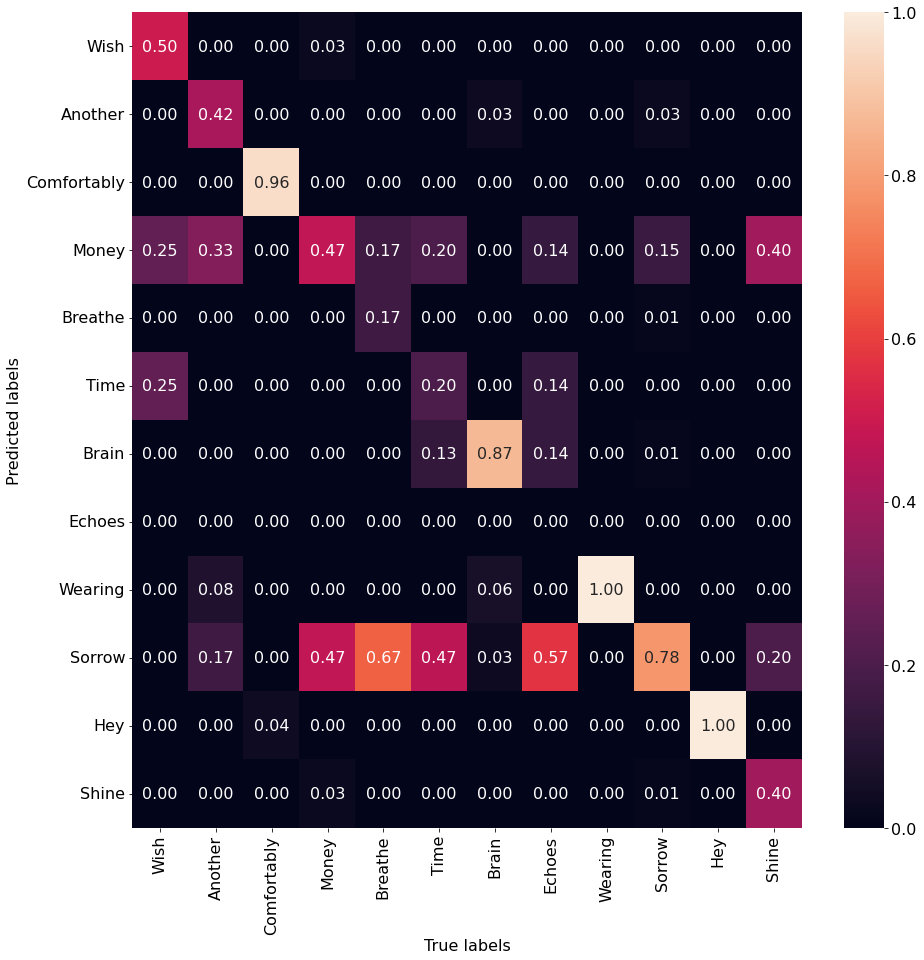

In [ ]:
ret = evaluate_model_m(model, X_test, y_test, classes)

In [ ]:
model.save('models/CNN4')
# model = tfk.models.load_model('1DCNN')

### Convolutional Neural Network - Deep architecture (with weightedd loss function)

---




Define the model architecture:

In [ ]:
def build_CNN4(input_shape=input_shape, n_output=n_output, n1=64, n2=128, n3=256, n4=512, n5=512, nc=256, activation='relu', filter_size=3, dp_rate=0.3, dp_rate1=0.3, dp_rate2=0.3, dp_rate3=0.3, learning_r=1e-3, lmbd=1e-5):

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    x = tfkl.Conv1D(n1,filter_size,padding='same',activation=activation)(input_layer)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Conv1D(n1,filter_size,padding='same',activation=activation)(x)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Dropout(dp_rate1, seed=seed)(x)

    x = tfkl.Conv1D(n2,filter_size,padding='same',activation=activation)(input_layer)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Conv1D(n2,filter_size,padding='same',activation=activation)(x)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Dropout(dp_rate2, seed=seed)(x)

    x = tfkl.Conv1D(n3,filter_size,padding='same',activation=activation)(input_layer)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Conv1D(n3,filter_size,padding='same',activation=activation)(x)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Dropout(dp_rate3, seed=seed)(x)

    x = tfkl.Conv1D(n4,filter_size,padding='same',activation=activation)(x)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Conv1D(n5,filter_size,padding='same',activation=activation)(x)
    x = tfkl.MaxPooling1D()(x)
    #x = tfkl.GlobalAveragePooling1D()(x)
    x = tfkl.Flatten()(x)
    dropout = tfkl.Dropout(dp_rate, seed=seed)(x)

    # Classifier
    classifier = tfkl.Dense(nc, activation=activation, kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer=tf.keras.regularizers.l2(lmbd))(dropout)
    output_layer = tfkl.Dense(n_output, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='Trad_1D_cnn')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=learning_r), metrics='accuracy')

    # Return the model
    return model

In [ ]:
class_weights =  dict(zip(np.unique(y_train_l), compute_class_weight(class_weight = "balanced", classes = np.unique(y_train_l), y = y_train_l)))
class_weights

{0: 6.070987654320987,
 1: 1.6391666666666667,
 2: 0.7484779299847792,
 3: 0.5304746494066882,
 4: 3.2783333333333333,
 5: 1.3219086021505377,
 6: 0.6453412073490814,
 7: 2.9803030303030305,
 8: 1.6898625429553265,
 9: 0.2605988341282459,
 10: 2.6438172043010755,
 11: 3.997967479674797}

Find the best hyperparameter configuration

In [ ]:
# model class to use in the scikit parameter search CV 
model = KerasClassifier(build_fn=build_CNN4,  n1=64, n2=128, n3=256, n4=512, n5=512, nc=256, activation='relu', filter_size=3, dp_rate=0.3, dp_rate1=0.3, dp_rate2=0.3, dp_rate3=0.3, learning_r=1e-3, lmbd=1e-5)

In [ ]:
# define the hyperparameters to tune
hyperparameters = {
    'epochs': [50,70],
    'batch_size': [32, 64, 128],
    'activation': ['relu'],
    'n1': np.arange(64, 256, 20), 
    'n2': np.arange(64, 256, 20), 
    'n3': np.arange(64, 512, 20), 
    'n4': np.arange(64, 512, 20), 
    'n5': np.arange(64, 1124, 20), 
    'nc': np.arange(64, 512, 20), 
    'filter_size': [3,4,2], 
    'learning_r': [1e-2,1e-3,1e-4,1e-5], 
    'lmbd':[1e-1,1e-2,1e-3,1e-4,1e-5],
    'dp_rate': np.arange(0, 0.5, 0.05),
    'dp_rate1': np.arange(0, 0.5, 0.05),
    'dp_rate2': np.arange(0, 0.5, 0.05),
    'dp_rate3': np.arange(0, 0.5, 0.05)
}

In [ ]:
# create the random search object
rs = BayesSearchCV(estimator=model, search_spaces=hyperparameters, cv=5, n_iter=10)

In [ ]:
# fit the random search object to the training data
rs.fit(X_train, y_train, class_weight = class_weights)

# view the best hyperparameters
print(rs.best_params_)
print(rs.best_score_)

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/57
25/25 [==============================] - 1s 11ms/step - loss: 90.1897 - accuracy: 0.0757
Epoch 2/57
25/25 [==============================] - 0s 6ms/step - loss: 39.8237 - accuracy: 0.0553
Epoch 3/57
25/25 [==============================] - 0s 6ms/step - loss: 33.3176 - accuracy: 0.0661
Epoch 4/57
25/25 [==============================] - 0s 6ms/step - loss: 34.9557 - accuracy: 0.0655
Epoch 5/57
25/25 [==============================] - 0s 6ms/step - loss: 25.4570 - accuracy: 0.0718
Epoch 6/57
25/25 [==============================] - 0s 6ms/step - loss: 29.3537 - accuracy: 0.0731
Epoch 7/57
25/25 [==============================] - 0s 5ms/step - loss: 23.1586 - accuracy: 0.0979
Epoch 8/57
25/25 [==============================] - 0s 6ms/step - loss: 21.9194 - accuracy: 0.0801
Epoch 9/57
25/25 [==============================] - 0s 6ms/step - loss: 22.6844 - accuracy: 0.0846
Epoch 10/57
25/25 [==============================] - 0s 6ms/step - loss: 22.3688 - accuracy: 0.0871
Epoch 11

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 7ms/step - loss: 69.9821 - accuracy: 0.0915
Epoch 2/57
25/25 [==============================] - 0s 6ms/step - loss: 66.8821 - accuracy: 0.0623
Epoch 3/57
25/25 [==============================] - 0s 6ms/step - loss: 37.9624 - accuracy: 0.0591
Epoch 4/57
25/25 [==============================] - 0s 7ms/step - loss: 32.8041 - accuracy: 0.0725
Epoch 5/57
25/25 [==============================] - 0s 8ms/step - loss: 37.7669 - accuracy: 0.0725
Epoch 6/57
25/25 [==============================] - 0s 9ms/step - loss: 32.2955 - accuracy: 0.0661
Epoch 7/57
25/25 [==============================] - 0s 8ms/step - loss: 35.3086 - accuracy: 0.0579
Epoch 8/57
25/25 [==============================] - 0s 8ms/step - loss: 25.6034 - accuracy: 0.0629
Epoch 9/57
25/25 [==============================] - 0s 8ms/step - loss: 23.3852 - accuracy: 0.0801
Epoch 10/57
25/25 [==============================] - 0s 8ms/step - loss: 21.5702 - accuracy: 0.0858
Epoch 11/57
25/25 [=

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 13ms/step - loss: 142.3884 - accuracy: 0.0559
Epoch 2/57
25/25 [==============================] - 0s 6ms/step - loss: 60.8013 - accuracy: 0.0673
Epoch 3/57
25/25 [==============================] - 0s 6ms/step - loss: 41.2979 - accuracy: 0.0572
Epoch 4/57
25/25 [==============================] - 0s 5ms/step - loss: 36.9087 - accuracy: 0.0699
Epoch 5/57
25/25 [==============================] - 0s 6ms/step - loss: 29.4305 - accuracy: 0.0610
Epoch 6/57
25/25 [==============================] - 0s 5ms/step - loss: 33.7340 - accuracy: 0.0661
Epoch 7/57
25/25 [==============================] - 0s 5ms/step - loss: 25.0572 - accuracy: 0.0737
Epoch 8/57
25/25 [==============================] - 0s 5ms/step - loss: 21.2608 - accuracy: 0.0959
Epoch 9/57
25/25 [==============================] - 0s 5ms/step - loss: 24.9965 - accuracy: 0.0801
Epoch 10/57
25/25 [==============================] - 0s 5ms/step - loss: 23.4413 - accuracy: 0.0826
Epoch 11/57
25/25 

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/57
25/25 [==============================] - 1s 8ms/step - loss: 89.7757 - accuracy: 0.0673
Epoch 2/57
25/25 [==============================] - 0s 7ms/step - loss: 42.3572 - accuracy: 0.0686
Epoch 3/57
25/25 [==============================] - 0s 7ms/step - loss: 44.9203 - accuracy: 0.0597
Epoch 4/57
25/25 [==============================] - 0s 6ms/step - loss: 41.9048 - accuracy: 0.0565
Epoch 5/57
25/25 [==============================] - 0s 6ms/step - loss: 31.2652 - accuracy: 0.0616
Epoch 6/57
25/25 [==============================] - 0s 6ms/step - loss: 27.6940 - accuracy: 0.0661
Epoch 7/57
25/25 [==============================] - 0s 6ms/step - loss: 22.8227 - accuracy: 0.0654
Epoch 8/57
25/25 [==============================] - 0s 6ms/step - loss: 22.2648 - accuracy: 0.0845
Epoch 9/57
25/25 [==============================] - 0s 6ms/step - loss: 20.7351 - accuracy: 0.0953
Epoch 10/57
25/25 [==============================] - 0s 5ms/step - loss: 24.1615 - accuracy: 0.0820
Epoch 11/

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/57
25/25 [==============================] - 1s 7ms/step - loss: 68.6846 - accuracy: 0.0680
Epoch 2/57
25/25 [==============================] - 0s 8ms/step - loss: 44.1136 - accuracy: 0.0521
Epoch 3/57
25/25 [==============================] - 0s 7ms/step - loss: 32.7352 - accuracy: 0.0731
Epoch 4/57
25/25 [==============================] - 0s 6ms/step - loss: 29.6552 - accuracy: 0.0718
Epoch 5/57
25/25 [==============================] - 0s 6ms/step - loss: 24.2166 - accuracy: 0.0870
Epoch 6/57
25/25 [==============================] - 0s 6ms/step - loss: 25.9125 - accuracy: 0.0851
Epoch 7/57
25/25 [==============================] - 0s 6ms/step - loss: 21.5547 - accuracy: 0.0781
Epoch 8/57
25/25 [==============================] - 0s 6ms/step - loss: 19.0961 - accuracy: 0.0934
Epoch 9/57
25/25 [==============================] - 0s 5ms/step - loss: 18.2785 - accuracy: 0.0966
Epoch 10/57
25/25 [==============================] - 0s 5ms/step - loss: 17.8622 - accuracy: 0.0909
Epoch 11/

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/53
13/13 [==============================] - 1s 31ms/step - loss: 75.0442 - accuracy: 0.0483
Epoch 2/53
13/13 [==============================] - 0s 11ms/step - loss: 34.1694 - accuracy: 0.0572
Epoch 3/53
13/13 [==============================] - 0s 10ms/step - loss: 23.6624 - accuracy: 0.0782
Epoch 4/53
13/13 [==============================] - 0s 10ms/step - loss: 20.0314 - accuracy: 0.1494
Epoch 5/53
13/13 [==============================] - 0s 10ms/step - loss: 17.5903 - accuracy: 0.1545
Epoch 6/53
13/13 [==============================] - 0s 11ms/step - loss: 16.6611 - accuracy: 0.2053
Epoch 7/53
13/13 [==============================] - 0s 10ms/step - loss: 15.9045 - accuracy: 0.2270
Epoch 8/53
13/13 [==============================] - 0s 10ms/step - loss: 15.9976 - accuracy: 0.1844
Epoch 9/53
13/13 [==============================] - 0s 10ms/step - loss: 17.2142 - accuracy: 0.1348
Epoch 10/53
13/13 [==============================] - 0s 10ms/step - loss: 14.7889 - accuracy: 0.1462

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 10ms/step - loss: 113.5515 - accuracy: 0.0617
Epoch 2/53
13/13 [==============================] - 0s 10ms/step - loss: 38.2965 - accuracy: 0.0788
Epoch 3/53
13/13 [==============================] - 0s 10ms/step - loss: 24.4248 - accuracy: 0.0782
Epoch 4/53
13/13 [==============================] - 0s 10ms/step - loss: 21.4843 - accuracy: 0.1144
Epoch 5/53
13/13 [==============================] - 0s 10ms/step - loss: 18.4540 - accuracy: 0.2289
Epoch 6/53
13/13 [==============================] - 0s 10ms/step - loss: 17.5506 - accuracy: 0.1647
Epoch 7/53
13/13 [==============================] - 0s 10ms/step - loss: 17.1249 - accuracy: 0.2206
Epoch 8/53
13/13 [==============================] - 0s 11ms/step - loss: 15.9278 - accuracy: 0.2969
Epoch 9/53
13/13 [==============================] - 0s 10ms/step - loss: 15.2419 - accuracy: 0.2117
Epoch 10/53
13/13 [==============================] - 0s 10ms/step - loss: 15.0415 - accuracy: 0.2200
Epoch 11/

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/53
13/13 [==============================] - 1s 39ms/step - loss: 117.9762 - accuracy: 0.0654
Epoch 2/53
13/13 [==============================] - 0s 10ms/step - loss: 35.2493 - accuracy: 0.0546
Epoch 3/53
13/13 [==============================] - 0s 10ms/step - loss: 25.1828 - accuracy: 0.0451
Epoch 4/53
13/13 [==============================] - 0s 10ms/step - loss: 21.9147 - accuracy: 0.0851
Epoch 5/53
13/13 [==============================] - 0s 10ms/step - loss: 19.2716 - accuracy: 0.1480
Epoch 6/53
13/13 [==============================] - 0s 11ms/step - loss: 18.3628 - accuracy: 0.1086
Epoch 7/53
13/13 [==============================] - 0s 11ms/step - loss: 17.6489 - accuracy: 0.2395
Epoch 8/53
13/13 [==============================] - 0s 10ms/step - loss: 16.8502 - accuracy: 0.1156
Epoch 9/53
13/13 [==============================] - 0s 10ms/step - loss: 15.9050 - accuracy: 0.2255
Epoch 10/53
13/13 [==============================] - 0s 11ms/step - loss: 15.1566 - accuracy: 0.304

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 16ms/step - loss: 98.9302 - accuracy: 0.0553
Epoch 2/53
13/13 [==============================] - 0s 12ms/step - loss: 29.7839 - accuracy: 0.0648
Epoch 3/53
13/13 [==============================] - 0s 11ms/step - loss: 24.7018 - accuracy: 0.0870
Epoch 4/53
13/13 [==============================] - 0s 10ms/step - loss: 24.9084 - accuracy: 0.0864
Epoch 5/53
13/13 [==============================] - 0s 10ms/step - loss: 21.7978 - accuracy: 0.2001
Epoch 6/53
13/13 [==============================] - 0s 9ms/step - loss: 19.1158 - accuracy: 0.1061
Epoch 7/53
13/13 [==============================] - 0s 9ms/step - loss: 18.0467 - accuracy: 0.1537
Epoch 8/53
13/13 [==============================] - 0s 10ms/step - loss: 17.1443 - accuracy: 0.1620
Epoch 9/53
13/13 [==============================] - 0s 10ms/step - loss: 16.0403 - accuracy: 0.2605
Epoch 10/53
13/13 [==============================] - 0s 9ms/step - loss: 15.3920 - accuracy: 0.3208
Epoch 11/53
1

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 16ms/step - loss: 69.1440 - accuracy: 0.0623
Epoch 2/53
13/13 [==============================] - 0s 11ms/step - loss: 30.8001 - accuracy: 0.0756
Epoch 3/53
13/13 [==============================] - 0s 11ms/step - loss: 22.8969 - accuracy: 0.0801
Epoch 4/53
13/13 [==============================] - 0s 10ms/step - loss: 20.0687 - accuracy: 0.1258
Epoch 5/53
13/13 [==============================] - 0s 10ms/step - loss: 18.5686 - accuracy: 0.2262
Epoch 6/53
13/13 [==============================] - 0s 10ms/step - loss: 17.4911 - accuracy: 0.2033
Epoch 7/53
13/13 [==============================] - 0s 10ms/step - loss: 16.3916 - accuracy: 0.2446
Epoch 8/53
13/13 [==============================] - 0s 10ms/step - loss: 15.5266 - accuracy: 0.2967
Epoch 9/53
13/13 [==============================] - 0s 11ms/step - loss: 14.8055 - accuracy: 0.3158
Epoch 10/53
13/13 [==============================] - 0s 10ms/step - loss: 14.3171 - accuracy: 0.2656
Epoch 11/5

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 18ms/step - loss: 97.8764 - accuracy: 0.0528
Epoch 2/53
13/13 [==============================] - 0s 8ms/step - loss: 48.1874 - accuracy: 0.1189
Epoch 3/53
13/13 [==============================] - 0s 7ms/step - loss: 38.7607 - accuracy: 0.0820
Epoch 4/53
13/13 [==============================] - 0s 7ms/step - loss: 34.5978 - accuracy: 0.0960
Epoch 5/53
13/13 [==============================] - 0s 7ms/step - loss: 30.6166 - accuracy: 0.1399
Epoch 6/53
13/13 [==============================] - 0s 7ms/step - loss: 28.4523 - accuracy: 0.1748
Epoch 7/53
13/13 [==============================] - 0s 8ms/step - loss: 26.4731 - accuracy: 0.2746
Epoch 8/53
13/13 [==============================] - 0s 7ms/step - loss: 24.9127 - accuracy: 0.3255
Epoch 9/53
13/13 [==============================] - 0s 7ms/step - loss: 23.7160 - accuracy: 0.2587
Epoch 10/53
13/13 [==============================] - 0s 7ms/step - loss: 22.9535 - accuracy: 0.2206
Epoch 11/53
13/13 [

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/53
13/13 [==============================] - 1s 12ms/step - loss: 105.8270 - accuracy: 0.0426
Epoch 2/53
13/13 [==============================] - 0s 11ms/step - loss: 52.9989 - accuracy: 0.1227
Epoch 3/53
13/13 [==============================] - 0s 9ms/step - loss: 44.3612 - accuracy: 0.0407
Epoch 4/53
13/13 [==============================] - 0s 8ms/step - loss: 34.6506 - accuracy: 0.1087
Epoch 5/53
13/13 [==============================] - 0s 7ms/step - loss: 30.8446 - accuracy: 0.1462
Epoch 6/53
13/13 [==============================] - 0s 7ms/step - loss: 28.4392 - accuracy: 0.2320
Epoch 7/53
13/13 [==============================] - 0s 8ms/step - loss: 27.7467 - accuracy: 0.1392
Epoch 8/53
13/13 [==============================] - 0s 7ms/step - loss: 26.4413 - accuracy: 0.2104
Epoch 9/53
13/13 [==============================] - 0s 7ms/step - loss: 25.1640 - accuracy: 0.2104
Epoch 10/53
13/13 [==============================] - 0s 7ms/step - loss: 23.6562 - accuracy: 0.2441
Epoch 

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/53
13/13 [==============================] - 1s 27ms/step - loss: 222.9094 - accuracy: 0.0737
Epoch 2/53
13/13 [==============================] - 0s 9ms/step - loss: 49.9829 - accuracy: 0.0521
Epoch 3/53
13/13 [==============================] - 0s 8ms/step - loss: 39.3518 - accuracy: 0.0813
Epoch 4/53
13/13 [==============================] - 0s 8ms/step - loss: 37.9888 - accuracy: 0.0508
Epoch 5/53
13/13 [==============================] - 0s 7ms/step - loss: 33.6339 - accuracy: 0.0737
Epoch 6/53
13/13 [==============================] - 0s 8ms/step - loss: 31.2426 - accuracy: 0.1233
Epoch 7/53
13/13 [==============================] - 0s 8ms/step - loss: 29.6628 - accuracy: 0.1264
Epoch 8/53
13/13 [==============================] - 0s 8ms/step - loss: 28.5788 - accuracy: 0.1506
Epoch 9/53
13/13 [==============================] - 0s 7ms/step - loss: 27.5581 - accuracy: 0.1341
Epoch 10/53
13/13 [==============================] - 0s 7ms/step - loss: 26.5461 - accuracy: 0.1595
Epoch 1

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/53
13/13 [==============================] - 1s 12ms/step - loss: 194.3195 - accuracy: 0.0451
Epoch 2/53
13/13 [==============================] - 0s 11ms/step - loss: 46.1807 - accuracy: 0.0464
Epoch 3/53
13/13 [==============================] - 0s 9ms/step - loss: 39.1709 - accuracy: 0.0921
Epoch 4/53
13/13 [==============================] - 0s 8ms/step - loss: 34.6937 - accuracy: 0.1245
Epoch 5/53
13/13 [==============================] - 0s 7ms/step - loss: 31.2619 - accuracy: 0.1201
Epoch 6/53
13/13 [==============================] - 0s 7ms/step - loss: 29.8068 - accuracy: 0.1588
Epoch 7/53
13/13 [==============================] - 0s 7ms/step - loss: 27.7402 - accuracy: 0.1728
Epoch 8/53
13/13 [==============================] - 0s 7ms/step - loss: 26.1860 - accuracy: 0.2624
Epoch 9/53
13/13 [==============================] - 0s 9ms/step - loss: 25.1503 - accuracy: 0.1855
Epoch 10/53
13/13 [==============================] - 0s 7ms/step - loss: 24.2442 - accuracy: 0.1671
Epoch 

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/53
13/13 [==============================] - 1s 7ms/step - loss: 129.1202 - accuracy: 0.0781
Epoch 2/53
13/13 [==============================] - 0s 7ms/step - loss: 42.8053 - accuracy: 0.0470
Epoch 3/53
13/13 [==============================] - 0s 8ms/step - loss: 36.3154 - accuracy: 0.1036
Epoch 4/53
13/13 [==============================] - 0s 7ms/step - loss: 32.0000 - accuracy: 0.1487
Epoch 5/53
13/13 [==============================] - 0s 7ms/step - loss: 29.5785 - accuracy: 0.1379
Epoch 6/53
13/13 [==============================] - 0s 7ms/step - loss: 27.1937 - accuracy: 0.2732
Epoch 7/53
13/13 [==============================] - 0s 7ms/step - loss: 25.3950 - accuracy: 0.2903
Epoch 8/53
13/13 [==============================] - 0s 8ms/step - loss: 24.0770 - accuracy: 0.2541
Epoch 9/53
13/13 [==============================] - 0s 7ms/step - loss: 22.8189 - accuracy: 0.3043
Epoch 10/53
13/13 [==============================] - 0s 7ms/step - loss: 21.6651 - accuracy: 0.3355
Epoch 11

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


50/50 [==============================] - 1s 9ms/step - loss: 105.4888 - accuracy: 0.0343
Epoch 2/65
50/50 [==============================] - 0s 6ms/step - loss: 5.0505 - accuracy: 0.0890
Epoch 3/65
50/50 [==============================] - 0s 6ms/step - loss: 4.3989 - accuracy: 0.0312
Epoch 4/65
50/50 [==============================] - 0s 6ms/step - loss: 3.7082 - accuracy: 0.0305
Epoch 5/65
50/50 [==============================] - 0s 6ms/step - loss: 4.1987 - accuracy: 0.0305
Epoch 6/65
50/50 [==============================] - 0s 6ms/step - loss: 3.5645 - accuracy: 0.0280
Epoch 7/65
50/50 [==============================] - 0s 5ms/step - loss: 3.4882 - accuracy: 0.0223
Epoch 8/65
50/50 [==============================] - 0s 6ms/step - loss: 3.4297 - accuracy: 0.0413
Epoch 9/65
50/50 [==============================] - 0s 6ms/step - loss: 3.3774 - accuracy: 0.0299
Epoch 10/65
50/50 [==============================] - 0s 6ms/step - loss: 3.3309 - accuracy: 0.0324
Epoch 11/65
50/50 [=========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


50/50 [==============================] - 1s 6ms/step - loss: 70.5673 - accuracy: 0.0432
Epoch 2/65
50/50 [==============================] - 0s 6ms/step - loss: 4.0147 - accuracy: 0.0477
Epoch 3/65
50/50 [==============================] - 0s 6ms/step - loss: 4.0346 - accuracy: 0.0356
Epoch 4/65
50/50 [==============================] - 0s 6ms/step - loss: 3.7863 - accuracy: 0.0585
Epoch 5/65
50/50 [==============================] - 0s 6ms/step - loss: 3.7073 - accuracy: 0.0642
Epoch 6/65
50/50 [==============================] - 0s 7ms/step - loss: 3.6472 - accuracy: 0.0223
Epoch 7/65
50/50 [==============================] - 0s 7ms/step - loss: 3.5976 - accuracy: 0.0261
Epoch 8/65
50/50 [==============================] - 0s 6ms/step - loss: 3.5562 - accuracy: 0.1863
Epoch 9/65
50/50 [==============================] - 0s 6ms/step - loss: 3.5190 - accuracy: 0.0388
Epoch 10/65
50/50 [==============================] - 0s 7ms/step - loss: 3.4846 - accuracy: 0.0331
Epoch 11/65
50/50 [==========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/65
50/50 [==============================] - 2s 9ms/step - loss: 286.8333 - accuracy: 0.0407
Epoch 2/65
50/50 [==============================] - 0s 6ms/step - loss: 4.0993 - accuracy: 0.0178
Epoch 3/65
50/50 [==============================] - 0s 6ms/step - loss: 3.9198 - accuracy: 0.0146
Epoch 4/65
50/50 [==============================] - 0s 6ms/step - loss: 3.8271 - accuracy: 0.0254
Epoch 5/65
50/50 [==============================] - 0s 6ms/step - loss: 3.7569 - accuracy: 0.0235
Epoch 6/65
50/50 [==============================] - 0s 6ms/step - loss: 3.7009 - accuracy: 0.0235
Epoch 7/65
50/50 [==============================] - 0s 6ms/step - loss: 3.6533 - accuracy: 0.0489
Epoch 8/65
50/50 [==============================] - 0s 6ms/step - loss: 3.6115 - accuracy: 0.0248
Epoch 9/65
50/50 [==============================] - 0s 6ms/step - loss: 3.5733 - accuracy: 0.0235
Epoch 10/65
50/50 [==============================] - 0s 6ms/step - loss: 3.5386 - accuracy: 0.0229
Epoch 11/65
50/50

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/65
50/50 [==============================] - 1s 6ms/step - loss: 159.6996 - accuracy: 0.0457
Epoch 2/65
50/50 [==============================] - 0s 6ms/step - loss: 4.0218 - accuracy: 0.0191
Epoch 3/65
50/50 [==============================] - 0s 6ms/step - loss: 3.8606 - accuracy: 0.0165
Epoch 4/65
50/50 [==============================] - 0s 6ms/step - loss: 3.7467 - accuracy: 0.0133
Epoch 5/65
50/50 [==============================] - 0s 6ms/step - loss: 3.6572 - accuracy: 0.0197
Epoch 6/65
50/50 [==============================] - 0s 6ms/step - loss: 3.5883 - accuracy: 0.0299
Epoch 7/65
50/50 [==============================] - 0s 5ms/step - loss: 3.5278 - accuracy: 0.0260
Epoch 8/65
50/50 [==============================] - 0s 6ms/step - loss: 3.4759 - accuracy: 0.0286
Epoch 9/65
50/50 [==============================] - 0s 6ms/step - loss: 3.4300 - accuracy: 0.0184
Epoch 10/65
50/50 [==============================] - 0s 6ms/step - loss: 3.3889 - accuracy: 0.0210
Epoch 11/65
50/50

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


50/50 [==============================] - 1s 8ms/step - loss: 146.1748 - accuracy: 0.0654
Epoch 2/65
50/50 [==============================] - 0s 6ms/step - loss: 4.0448 - accuracy: 0.0305
Epoch 3/65
50/50 [==============================] - 0s 6ms/step - loss: 3.8116 - accuracy: 0.0146
Epoch 4/65
50/50 [==============================] - 0s 6ms/step - loss: 3.7128 - accuracy: 0.0267
Epoch 5/65
50/50 [==============================] - 0s 6ms/step - loss: 3.6739 - accuracy: 0.0407
Epoch 6/65
50/50 [==============================] - 0s 6ms/step - loss: 3.5772 - accuracy: 0.0521
Epoch 7/65
50/50 [==============================] - 0s 6ms/step - loss: 3.5187 - accuracy: 0.0191
Epoch 8/65
50/50 [==============================] - 0s 6ms/step - loss: 3.4717 - accuracy: 0.0534
Epoch 9/65
50/50 [==============================] - 0s 6ms/step - loss: 3.4213 - accuracy: 0.0368
Epoch 10/65
50/50 [==============================] - 0s 6ms/step - loss: 3.3788 - accuracy: 0.0604
Epoch 11/65
50/50 [=========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/58
25/25 [==============================] - 1s 11ms/step - loss: 46.6949 - accuracy: 0.0648
Epoch 2/58
25/25 [==============================] - 0s 6ms/step - loss: 33.9711 - accuracy: 0.0687
Epoch 3/58
25/25 [==============================] - 0s 6ms/step - loss: 31.3541 - accuracy: 0.0636
Epoch 4/58
25/25 [==============================] - 0s 6ms/step - loss: 26.0014 - accuracy: 0.0852
Epoch 5/58
25/25 [==============================] - 0s 7ms/step - loss: 24.5991 - accuracy: 0.0769
Epoch 6/58
25/25 [==============================] - 0s 7ms/step - loss: 25.4163 - accuracy: 0.1157
Epoch 7/58
25/25 [==============================] - 0s 7ms/step - loss: 20.7339 - accuracy: 0.0966
Epoch 8/58
25/25 [==============================] - 0s 7ms/step - loss: 25.7927 - accuracy: 0.1106
Epoch 9/58
25/25 [==============================] - 0s 7ms/step - loss: 21.9316 - accuracy: 0.1062
Epoch 10/58
25/25 [==============================] - 0s 7ms/step - loss: 20.2895 - accuracy: 0.1449
Epoch 11

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 7ms/step - loss: 52.6838 - accuracy: 0.0661
Epoch 2/58
25/25 [==============================] - 0s 7ms/step - loss: 45.5481 - accuracy: 0.0420
Epoch 3/58
25/25 [==============================] - 0s 7ms/step - loss: 34.2570 - accuracy: 0.0553
Epoch 4/58
25/25 [==============================] - 0s 6ms/step - loss: 25.5298 - accuracy: 0.0636
Epoch 5/58
25/25 [==============================] - 0s 6ms/step - loss: 27.2121 - accuracy: 0.0903
Epoch 6/58
25/25 [==============================] - 0s 6ms/step - loss: 23.9751 - accuracy: 0.0814
Epoch 7/58
25/25 [==============================] - 0s 7ms/step - loss: 21.1745 - accuracy: 0.0954
Epoch 8/58
25/25 [==============================] - 0s 6ms/step - loss: 23.4475 - accuracy: 0.0807
Epoch 9/58
25/25 [==============================] - 0s 6ms/step - loss: 28.1360 - accuracy: 0.0706
Epoch 10/58
25/25 [==============================] - 0s 6ms/step - loss: 21.5818 - accuracy: 0.0896
Epoch 11/58
25/25 [=

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 14ms/step - loss: 79.0282 - accuracy: 0.0756
Epoch 2/58
25/25 [==============================] - 0s 6ms/step - loss: 38.3123 - accuracy: 0.0623
Epoch 3/58
25/25 [==============================] - 0s 6ms/step - loss: 34.2176 - accuracy: 0.0559
Epoch 4/58
25/25 [==============================] - 0s 6ms/step - loss: 26.2112 - accuracy: 0.0953
Epoch 5/58
25/25 [==============================] - 0s 6ms/step - loss: 34.0940 - accuracy: 0.0642
Epoch 6/58
25/25 [==============================] - 0s 6ms/step - loss: 22.2718 - accuracy: 0.0953
Epoch 7/58
25/25 [==============================] - 0s 6ms/step - loss: 23.6113 - accuracy: 0.0972
Epoch 8/58
25/25 [==============================] - 0s 6ms/step - loss: 22.1192 - accuracy: 0.0902
Epoch 9/58
25/25 [==============================] - 0s 6ms/step - loss: 30.5432 - accuracy: 0.0991
Epoch 10/58
25/25 [==============================] - 0s 7ms/step - loss: 22.5578 - accuracy: 0.0991
Epoch 11/58
25/25 [

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/58
25/25 [==============================] - 1s 6ms/step - loss: 66.6776 - accuracy: 0.0426
Epoch 2/58
25/25 [==============================] - 0s 6ms/step - loss: 33.7976 - accuracy: 0.0750
Epoch 3/58
25/25 [==============================] - 0s 5ms/step - loss: 32.6343 - accuracy: 0.0813
Epoch 4/58
25/25 [==============================] - 0s 6ms/step - loss: 36.9784 - accuracy: 0.0737
Epoch 5/58
25/25 [==============================] - 0s 6ms/step - loss: 26.8425 - accuracy: 0.0832
Epoch 6/58
25/25 [==============================] - 0s 6ms/step - loss: 32.3779 - accuracy: 0.0667
Epoch 7/58
25/25 [==============================] - 0s 6ms/step - loss: 26.1247 - accuracy: 0.1029
Epoch 8/58
25/25 [==============================] - 0s 6ms/step - loss: 23.6912 - accuracy: 0.1042
Epoch 9/58
25/25 [==============================] - 0s 5ms/step - loss: 22.1279 - accuracy: 0.0934
Epoch 10/58
25/25 [==============================] - 0s 6ms/step - loss: 23.6324 - accuracy: 0.0921
Epoch 11/

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 6ms/step - loss: 53.6733 - accuracy: 0.0565
Epoch 2/58
25/25 [==============================] - 0s 6ms/step - loss: 34.1584 - accuracy: 0.0781
Epoch 3/58
25/25 [==============================] - 0s 6ms/step - loss: 28.1568 - accuracy: 0.0718
Epoch 4/58
25/25 [==============================] - 0s 6ms/step - loss: 24.4597 - accuracy: 0.0743
Epoch 5/58
25/25 [==============================] - 0s 6ms/step - loss: 21.4828 - accuracy: 0.0978
Epoch 6/58
25/25 [==============================] - 0s 6ms/step - loss: 22.8391 - accuracy: 0.1099
Epoch 7/58
25/25 [==============================] - 0s 6ms/step - loss: 22.1163 - accuracy: 0.0743
Epoch 8/58
25/25 [==============================] - 0s 7ms/step - loss: 20.1581 - accuracy: 0.1099
Epoch 9/58
25/25 [==============================] - 0s 6ms/step - loss: 18.7975 - accuracy: 0.1328
Epoch 10/58
25/25 [==============================] - 0s 6ms/step - loss: 18.6100 - accuracy: 0.1220
Epoch 11/58
25/25 [=

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/59
13/13 [==============================] - 1s 20ms/step - loss: 85.8182 - accuracy: 0.0585
Epoch 2/59
13/13 [==============================] - 0s 7ms/step - loss: 25.3999 - accuracy: 0.0521
Epoch 3/59
13/13 [==============================] - 0s 7ms/step - loss: 6.5709 - accuracy: 0.0655
Epoch 4/59
13/13 [==============================] - 0s 7ms/step - loss: 3.2662 - accuracy: 0.0973
Epoch 5/59
13/13 [==============================] - 0s 7ms/step - loss: 2.8001 - accuracy: 0.1697
Epoch 6/59
13/13 [==============================] - 0s 8ms/step - loss: 2.6322 - accuracy: 0.2193
Epoch 7/59
13/13 [==============================] - 0s 7ms/step - loss: 2.4099 - accuracy: 0.2339
Epoch 8/59
13/13 [==============================] - 0s 8ms/step - loss: 2.2622 - accuracy: 0.2346
Epoch 9/59
13/13 [==============================] - 0s 7ms/step - loss: 2.3008 - accuracy: 0.2378
Epoch 10/59
13/13 [==============================] - 0s 8ms/step - loss: 2.2260 - accuracy: 0.2982
Epoch 11/59
13/1

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 12ms/step - loss: 105.8412 - accuracy: 0.0369
Epoch 2/59
13/13 [==============================] - 0s 11ms/step - loss: 23.0496 - accuracy: 0.0655
Epoch 3/59
13/13 [==============================] - 0s 8ms/step - loss: 9.9922 - accuracy: 0.0954
Epoch 4/59
13/13 [==============================] - 0s 10ms/step - loss: 5.0882 - accuracy: 0.0865
Epoch 5/59
13/13 [==============================] - 0s 7ms/step - loss: 4.0914 - accuracy: 0.1182
Epoch 6/59
13/13 [==============================] - 0s 7ms/step - loss: 2.9476 - accuracy: 0.1297
Epoch 7/59
13/13 [==============================] - 0s 8ms/step - loss: 2.4681 - accuracy: 0.1627
Epoch 8/59
13/13 [==============================] - 0s 7ms/step - loss: 2.5179 - accuracy: 0.2047
Epoch 9/59
13/13 [==============================] - 0s 7ms/step - loss: 2.4757 - accuracy: 0.2645
Epoch 10/59
13/13 [==============================] - 0s 7ms/step - loss: 2.3050 - accuracy: 0.3020
Epoch 11/59
13/13 [=====

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/59
13/13 [==============================] - 1s 20ms/step - loss: 145.0611 - accuracy: 0.0343
Epoch 2/59
13/13 [==============================] - 0s 7ms/step - loss: 35.3426 - accuracy: 0.0934
Epoch 3/59
13/13 [==============================] - 0s 7ms/step - loss: 7.3520 - accuracy: 0.0915
Epoch 4/59
13/13 [==============================] - 0s 8ms/step - loss: 4.7153 - accuracy: 0.1436
Epoch 5/59
13/13 [==============================] - 0s 7ms/step - loss: 3.0733 - accuracy: 0.1989
Epoch 6/59
13/13 [==============================] - 0s 8ms/step - loss: 2.9016 - accuracy: 0.1652
Epoch 7/59
13/13 [==============================] - 0s 8ms/step - loss: 2.6826 - accuracy: 0.2605
Epoch 8/59
13/13 [==============================] - 0s 7ms/step - loss: 2.4597 - accuracy: 0.2605
Epoch 9/59
13/13 [==============================] - 0s 8ms/step - loss: 2.5428 - accuracy: 0.2217
Epoch 10/59
13/13 [==============================] - 0s 7ms/step - loss: 2.6298 - accuracy: 0.2230
Epoch 11/59
13/

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/59
13/13 [==============================] - 1s 8ms/step - loss: 177.5506 - accuracy: 0.0686
Epoch 2/59
13/13 [==============================] - 0s 7ms/step - loss: 23.4712 - accuracy: 0.0743
Epoch 3/59
13/13 [==============================] - 0s 8ms/step - loss: 7.6756 - accuracy: 0.0832
Epoch 4/59
13/13 [==============================] - 0s 9ms/step - loss: 4.8956 - accuracy: 0.1487
Epoch 5/59
13/13 [==============================] - 0s 8ms/step - loss: 3.1493 - accuracy: 0.1341
Epoch 6/59
13/13 [==============================] - 0s 7ms/step - loss: 2.9760 - accuracy: 0.1302
Epoch 7/59
13/13 [==============================] - 0s 7ms/step - loss: 2.8266 - accuracy: 0.1347
Epoch 8/59
13/13 [==============================] - 0s 8ms/step - loss: 2.6260 - accuracy: 0.1442
Epoch 9/59
13/13 [==============================] - 0s 7ms/step - loss: 2.4783 - accuracy: 0.1690
Epoch 10/59
13/13 [==============================] - 0s 8ms/step - loss: 2.2880 - accuracy: 0.2109
Epoch 11/59
13/1

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 9ms/step - loss: 65.7713 - accuracy: 0.0413
Epoch 2/59
13/13 [==============================] - 0s 8ms/step - loss: 16.7643 - accuracy: 0.0743
Epoch 3/59
13/13 [==============================] - 0s 9ms/step - loss: 8.8487 - accuracy: 0.1112
Epoch 4/59
13/13 [==============================] - 0s 9ms/step - loss: 4.1578 - accuracy: 0.1550
Epoch 5/59
13/13 [==============================] - 0s 8ms/step - loss: 2.9867 - accuracy: 0.2338
Epoch 6/59
13/13 [==============================] - 0s 9ms/step - loss: 2.5004 - accuracy: 0.3196
Epoch 7/59
13/13 [==============================] - 0s 8ms/step - loss: 2.3701 - accuracy: 0.3463
Epoch 8/59
13/13 [==============================] - 0s 8ms/step - loss: 2.3295 - accuracy: 0.3723
Epoch 9/59
13/13 [==============================] - 0s 8ms/step - loss: 2.2057 - accuracy: 0.3405
Epoch 10/59
13/13 [==============================] - 0s 7ms/step - loss: 3.0754 - accuracy: 0.3914
Epoch 11/59
13/13 [=========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 25ms/step - loss: 65.9975 - accuracy: 0.0579
Epoch 2/63
13/13 [==============================] - 0s 9ms/step - loss: 30.6937 - accuracy: 0.0680
Epoch 3/63
13/13 [==============================] - 0s 10ms/step - loss: 14.6448 - accuracy: 0.1043
Epoch 4/63
13/13 [==============================] - 0s 10ms/step - loss: 13.0662 - accuracy: 0.1055
Epoch 5/63
13/13 [==============================] - 0s 10ms/step - loss: 12.4169 - accuracy: 0.1488
Epoch 6/63
13/13 [==============================] - 0s 11ms/step - loss: 12.1052 - accuracy: 0.1538
Epoch 7/63
13/13 [==============================] - 0s 9ms/step - loss: 11.6564 - accuracy: 0.1532
Epoch 8/63
13/13 [==============================] - 0s 9ms/step - loss: 12.5231 - accuracy: 0.1672
Epoch 9/63
13/13 [==============================] - 0s 9ms/step - loss: 10.8726 - accuracy: 0.1596
Epoch 10/63
13/13 [==============================] - 0s 10ms/step - loss: 9.7569 - accuracy: 0.2022
Epoch 11/63
13/

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/63
13/13 [==============================] - 1s 17ms/step - loss: 99.7971 - accuracy: 0.0394
Epoch 2/63
13/13 [==============================] - 0s 12ms/step - loss: 30.5315 - accuracy: 0.1157
Epoch 3/63
13/13 [==============================] - 0s 10ms/step - loss: 34.8582 - accuracy: 0.0540
Epoch 4/63
13/13 [==============================] - 0s 9ms/step - loss: 21.5716 - accuracy: 0.0693
Epoch 5/63
13/13 [==============================] - 0s 9ms/step - loss: 15.9027 - accuracy: 0.0890
Epoch 6/63
13/13 [==============================] - 0s 10ms/step - loss: 11.2735 - accuracy: 0.1189
Epoch 7/63
13/13 [==============================] - 0s 9ms/step - loss: 10.9894 - accuracy: 0.1380
Epoch 8/63
13/13 [==============================] - 0s 9ms/step - loss: 12.7270 - accuracy: 0.1513
Epoch 9/63
13/13 [==============================] - 0s 10ms/step - loss: 10.2202 - accuracy: 0.1704
Epoch 10/63
13/13 [==============================] - 0s 9ms/step - loss: 9.3132 - accuracy: 0.2066
Epoch

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/63
13/13 [==============================] - 1s 34ms/step - loss: 170.1915 - accuracy: 0.0515
Epoch 2/63
13/13 [==============================] - 0s 10ms/step - loss: 41.7104 - accuracy: 0.0686
Epoch 3/63
13/13 [==============================] - 0s 9ms/step - loss: 14.7718 - accuracy: 0.0769
Epoch 4/63
13/13 [==============================] - 0s 10ms/step - loss: 11.7337 - accuracy: 0.0769
Epoch 5/63
13/13 [==============================] - 0s 10ms/step - loss: 12.4759 - accuracy: 0.1283
Epoch 6/63
13/13 [==============================] - 0s 10ms/step - loss: 11.2022 - accuracy: 0.1125
Epoch 7/63
13/13 [==============================] - 0s 10ms/step - loss: 10.8876 - accuracy: 0.1188
Epoch 8/63
13/13 [==============================] - 0s 10ms/step - loss: 11.6337 - accuracy: 0.1283
Epoch 9/63
13/13 [==============================] - 0s 10ms/step - loss: 11.8591 - accuracy: 0.1436
Epoch 10/63
13/13 [==============================] - 0s 10ms/step - loss: 11.7940 - accuracy: 0.1461

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 14ms/step - loss: 98.8578 - accuracy: 0.0769
Epoch 2/63
13/13 [==============================] - 0s 11ms/step - loss: 16.7582 - accuracy: 0.0877
Epoch 3/63
13/13 [==============================] - 0s 10ms/step - loss: 14.6646 - accuracy: 0.0718
Epoch 4/63
13/13 [==============================] - 0s 9ms/step - loss: 11.8057 - accuracy: 0.1499
Epoch 5/63
13/13 [==============================] - 0s 9ms/step - loss: 15.3521 - accuracy: 0.1264
Epoch 6/63
13/13 [==============================] - 0s 10ms/step - loss: 11.1870 - accuracy: 0.1677
Epoch 7/63
13/13 [==============================] - 0s 10ms/step - loss: 11.1363 - accuracy: 0.1080
Epoch 8/63
13/13 [==============================] - 0s 10ms/step - loss: 9.8391 - accuracy: 0.1900
Epoch 9/63
13/13 [==============================] - 0s 9ms/step - loss: 12.2669 - accuracy: 0.1468
Epoch 10/63
13/13 [==============================] - 0s 9ms/step - loss: 12.2681 - accuracy: 0.1093
Epoch 11/63
13/

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/63
13/13 [==============================] - 1s 17ms/step - loss: 68.9398 - accuracy: 0.0584
Epoch 2/63
13/13 [==============================] - 0s 13ms/step - loss: 17.5752 - accuracy: 0.0635
Epoch 3/63
13/13 [==============================] - 0s 11ms/step - loss: 13.5415 - accuracy: 0.1080
Epoch 4/63
13/13 [==============================] - 0s 9ms/step - loss: 13.4066 - accuracy: 0.0756
Epoch 5/63
13/13 [==============================] - 0s 10ms/step - loss: 10.3987 - accuracy: 0.1328
Epoch 6/63
13/13 [==============================] - 0s 10ms/step - loss: 10.5488 - accuracy: 0.1194
Epoch 7/63
13/13 [==============================] - 0s 9ms/step - loss: 10.7227 - accuracy: 0.1595
Epoch 8/63
13/13 [==============================] - 0s 10ms/step - loss: 9.5129 - accuracy: 0.1760
Epoch 9/63
13/13 [==============================] - 0s 10ms/step - loss: 9.1445 - accuracy: 0.2052
Epoch 10/63
13/13 [==============================] - 0s 10ms/step - loss: 8.8509 - accuracy: 0.2675
Epoc

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/61
13/13 [==============================] - 1s 25ms/step - loss: 48.8196 - accuracy: 0.0795
Epoch 2/61
13/13 [==============================] - 0s 8ms/step - loss: 19.5364 - accuracy: 0.0458
Epoch 3/61
13/13 [==============================] - 0s 8ms/step - loss: 17.0515 - accuracy: 0.0579
Epoch 4/61
13/13 [==============================] - 0s 9ms/step - loss: 13.6837 - accuracy: 0.0763
Epoch 5/61
13/13 [==============================] - 0s 9ms/step - loss: 12.1954 - accuracy: 0.1100
Epoch 6/61
13/13 [==============================] - 0s 10ms/step - loss: 11.7135 - accuracy: 0.1227
Epoch 7/61
13/13 [==============================] - 0s 9ms/step - loss: 10.6731 - accuracy: 0.1233
Epoch 8/61
13/13 [==============================] - 0s 9ms/step - loss: 10.0027 - accuracy: 0.1348
Epoch 9/61
13/13 [==============================] - 0s 8ms/step - loss: 9.6197 - accuracy: 0.1570
Epoch 10/61
13/13 [==============================] - 0s 9ms/step - loss: 9.3358 - accuracy: 0.1755
Epoch 11/

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 13ms/step - loss: 37.8091 - accuracy: 0.0464
Epoch 2/61
13/13 [==============================] - 0s 12ms/step - loss: 23.3300 - accuracy: 0.0490
Epoch 3/61
13/13 [==============================] - 0s 10ms/step - loss: 15.2934 - accuracy: 0.0687
Epoch 4/61
13/13 [==============================] - 0s 9ms/step - loss: 13.0253 - accuracy: 0.0814
Epoch 5/61
13/13 [==============================] - 0s 9ms/step - loss: 17.1033 - accuracy: 0.0865
Epoch 6/61
13/13 [==============================] - 0s 10ms/step - loss: 12.6358 - accuracy: 0.0833
Epoch 7/61
13/13 [==============================] - 0s 10ms/step - loss: 11.7116 - accuracy: 0.1068
Epoch 8/61
13/13 [==============================] - 0s 9ms/step - loss: 10.4525 - accuracy: 0.1469
Epoch 9/61
13/13 [==============================] - 0s 9ms/step - loss: 9.7455 - accuracy: 0.1532
Epoch 10/61
13/13 [==============================] - 0s 8ms/step - loss: 10.5977 - accuracy: 0.1564
Epoch 11/61
13/1

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/61
13/13 [==============================] - 1s 25ms/step - loss: 50.3725 - accuracy: 0.0394
Epoch 2/61
13/13 [==============================] - 0s 9ms/step - loss: 24.5971 - accuracy: 0.0724
Epoch 3/61
13/13 [==============================] - 0s 10ms/step - loss: 17.0071 - accuracy: 0.0578
Epoch 4/61
13/13 [==============================] - 0s 8ms/step - loss: 14.2918 - accuracy: 0.0826
Epoch 5/61
13/13 [==============================] - 0s 10ms/step - loss: 13.4668 - accuracy: 0.1048
Epoch 6/61
13/13 [==============================] - 0s 11ms/step - loss: 13.1405 - accuracy: 0.1099
Epoch 7/61
13/13 [==============================] - 0s 9ms/step - loss: 11.8574 - accuracy: 0.1233
Epoch 8/61
13/13 [==============================] - 0s 9ms/step - loss: 12.9623 - accuracy: 0.1086
Epoch 9/61
13/13 [==============================] - 0s 9ms/step - loss: 11.3062 - accuracy: 0.1315
Epoch 10/61
13/13 [==============================] - 0s 8ms/step - loss: 10.7323 - accuracy: 0.1360
Epoch

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 13ms/step - loss: 36.1279 - accuracy: 0.0470
Epoch 2/61
13/13 [==============================] - 0s 12ms/step - loss: 22.4526 - accuracy: 0.0559
Epoch 3/61
13/13 [==============================] - 0s 10ms/step - loss: 16.3252 - accuracy: 0.1099
Epoch 4/61
13/13 [==============================] - 0s 10ms/step - loss: 16.0052 - accuracy: 0.0928
Epoch 5/61
13/13 [==============================] - 0s 9ms/step - loss: 13.4630 - accuracy: 0.0909
Epoch 6/61
13/13 [==============================] - 0s 8ms/step - loss: 13.5377 - accuracy: 0.1341
Epoch 7/61
13/13 [==============================] - 0s 10ms/step - loss: 11.7763 - accuracy: 0.1239
Epoch 8/61
13/13 [==============================] - 0s 8ms/step - loss: 11.2636 - accuracy: 0.1391
Epoch 9/61
13/13 [==============================] - 0s 8ms/step - loss: 10.4611 - accuracy: 0.1696
Epoch 10/61
13/13 [==============================] - 0s 9ms/step - loss: 11.7367 - accuracy: 0.1792
Epoch 11/61
13/

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/61
13/13 [==============================] - 1s 13ms/step - loss: 27.1056 - accuracy: 0.0623
Epoch 2/61
13/13 [==============================] - 0s 12ms/step - loss: 15.8664 - accuracy: 0.0667
Epoch 3/61
13/13 [==============================] - 0s 10ms/step - loss: 13.7220 - accuracy: 0.0813
Epoch 4/61
13/13 [==============================] - 0s 8ms/step - loss: 11.7596 - accuracy: 0.0947
Epoch 5/61
13/13 [==============================] - 0s 9ms/step - loss: 11.0926 - accuracy: 0.1271
Epoch 6/61
13/13 [==============================] - 0s 9ms/step - loss: 11.3904 - accuracy: 0.1607
Epoch 7/61
13/13 [==============================] - 0s 9ms/step - loss: 10.1483 - accuracy: 0.1728
Epoch 8/61
13/13 [==============================] - 0s 9ms/step - loss: 9.5211 - accuracy: 0.1912
Epoch 9/61
13/13 [==============================] - 0s 9ms/step - loss: 9.5493 - accuracy: 0.1931
Epoch 10/61
13/13 [==============================] - 0s 9ms/step - loss: 9.0452 - accuracy: 0.1906
Epoch 11/

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50
25/25 [==============================] - 1s 11ms/step - loss: 36.8871 - accuracy: 0.0731
Epoch 2/50
25/25 [==============================] - 0s 7ms/step - loss: 15.7412 - accuracy: 0.0655
Epoch 3/50
25/25 [==============================] - 0s 7ms/step - loss: 9.1497 - accuracy: 0.1024
Epoch 4/50
25/25 [==============================] - 0s 7ms/step - loss: 13.8849 - accuracy: 0.1310
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 9.8323 - accuracy: 0.1259
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 4.6994 - accuracy: 0.1729
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 3.0785 - accuracy: 0.1805
Epoch 8/50
25/25 [==============================] - 0s 6ms/step - loss: 3.0276 - accuracy: 0.2244
Epoch 9/50
25/25 [==============================] - 0s 6ms/step - loss: 3.4997 - accuracy: 0.2034
Epoch 10/50
25/25 [==============================] - 0s 6ms/step - loss: 2.6371 - accuracy: 0.1983
Epoch 11/50
25/

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50
25/25 [==============================] - 1s 8ms/step - loss: 93.4263 - accuracy: 0.0502
Epoch 2/50
25/25 [==============================] - 0s 7ms/step - loss: 21.8776 - accuracy: 0.0629
Epoch 3/50
25/25 [==============================] - 0s 7ms/step - loss: 16.0258 - accuracy: 0.0979
Epoch 4/50
25/25 [==============================] - 0s 7ms/step - loss: 12.6561 - accuracy: 0.1208
Epoch 5/50
25/25 [==============================] - 0s 7ms/step - loss: 4.7885 - accuracy: 0.1322
Epoch 6/50
25/25 [==============================] - 0s 7ms/step - loss: 4.2625 - accuracy: 0.1170
Epoch 7/50
25/25 [==============================] - 0s 7ms/step - loss: 6.0633 - accuracy: 0.1335
Epoch 8/50
25/25 [==============================] - 0s 7ms/step - loss: 3.5456 - accuracy: 0.1475
Epoch 9/50
25/25 [==============================] - 0s 8ms/step - loss: 4.2765 - accuracy: 0.1322
Epoch 10/50
25/25 [==============================] - 0s 7ms/step - loss: 3.7568 - accuracy: 0.1316
Epoch 11/50
25/

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/50
25/25 [==============================] - 1s 15ms/step - loss: 103.2453 - accuracy: 0.0534
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 12.6107 - accuracy: 0.0635
Epoch 3/50
25/25 [==============================] - 0s 6ms/step - loss: 8.5495 - accuracy: 0.1175
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 7.1758 - accuracy: 0.1188
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 11.4323 - accuracy: 0.1302
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 4.2795 - accuracy: 0.1449
Epoch 7/50
25/25 [==============================] - 0s 7ms/step - loss: 4.8433 - accuracy: 0.1093
Epoch 8/50
25/25 [==============================] - 0s 7ms/step - loss: 3.4435 - accuracy: 0.1220
Epoch 9/50
25/25 [==============================] - 0s 7ms/step - loss: 2.7782 - accuracy: 0.1817
Epoch 10/50
25/25 [==============================] - 0s 7ms/step - loss: 3.0924 - accuracy: 0.2173
Epoch 11/50
25

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 7ms/step - loss: 112.1105 - accuracy: 0.0565
Epoch 2/50
25/25 [==============================] - 0s 7ms/step - loss: 13.9235 - accuracy: 0.0699
Epoch 3/50
25/25 [==============================] - 0s 7ms/step - loss: 6.8408 - accuracy: 0.1017
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 6.0121 - accuracy: 0.1639
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 12.0001 - accuracy: 0.0991
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 4.9983 - accuracy: 0.1645
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 5.5069 - accuracy: 0.1360
Epoch 8/50
25/25 [==============================] - 0s 6ms/step - loss: 3.4388 - accuracy: 0.1779
Epoch 9/50
25/25 [==============================] - 0s 6ms/step - loss: 4.3564 - accuracy: 0.1811
Epoch 10/50
25/25 [==============================] - 0s 6ms/step - loss: 2.8218 - accuracy: 0.2287
Epoch 11/50
25/25 [=======

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


25/25 [==============================] - 1s 7ms/step - loss: 55.1319 - accuracy: 0.0470
Epoch 2/50
25/25 [==============================] - 0s 7ms/step - loss: 13.1507 - accuracy: 0.1048
Epoch 3/50
25/25 [==============================] - 0s 7ms/step - loss: 9.7916 - accuracy: 0.0724
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 5.1388 - accuracy: 0.1442
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 3.6947 - accuracy: 0.1817
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 3.3182 - accuracy: 0.2116
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 4.5547 - accuracy: 0.1277
Epoch 8/50
25/25 [==============================] - 0s 6ms/step - loss: 3.6900 - accuracy: 0.1658
Epoch 9/50
25/25 [==============================] - 0s 6ms/step - loss: 3.0931 - accuracy: 0.1836
Epoch 10/50
25/25 [==============================] - 0s 6ms/step - loss: 3.0767 - accuracy: 0.1709
Epoch 11/50
25/25 [=========

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/56
13/13 [==============================] - 1s 21ms/step - loss: 203.9896 - accuracy: 0.0642
Epoch 2/56
13/13 [==============================] - 0s 8ms/step - loss: 16.5191 - accuracy: 0.0846
Epoch 3/56
13/13 [==============================] - 0s 8ms/step - loss: 17.8909 - accuracy: 0.0884
Epoch 4/56
13/13 [==============================] - 0s 8ms/step - loss: 16.0533 - accuracy: 0.1481
Epoch 5/56
13/13 [==============================] - 0s 8ms/step - loss: 15.0554 - accuracy: 0.2212
Epoch 6/56
13/13 [==============================] - 0s 8ms/step - loss: 13.1938 - accuracy: 0.1297
Epoch 7/56
13/13 [==============================] - 0s 8ms/step - loss: 12.0471 - accuracy: 0.0922
Epoch 8/56
13/13 [==============================] - 0s 8ms/step - loss: 11.6075 - accuracy: 0.0909
Epoch 9/56
13/13 [==============================] - 0s 8ms/step - loss: 10.8944 - accuracy: 0.0744
Epoch 10/56
13/13 [==============================] - 0s 8ms/step - loss: 10.3061 - accuracy: 0.0674
Epoch 1

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 14ms/step - loss: 265.1957 - accuracy: 0.0763
Epoch 2/56
13/13 [==============================] - 0s 10ms/step - loss: 17.7583 - accuracy: 0.0680
Epoch 3/56
13/13 [==============================] - 0s 9ms/step - loss: 18.4547 - accuracy: 0.1062
Epoch 4/56
13/13 [==============================] - 0s 8ms/step - loss: 17.5350 - accuracy: 0.1411
Epoch 5/56
13/13 [==============================] - 0s 10ms/step - loss: 16.3603 - accuracy: 0.1405
Epoch 6/56
13/13 [==============================] - 0s 8ms/step - loss: 15.8314 - accuracy: 0.1939
Epoch 7/56
13/13 [==============================] - 0s 8ms/step - loss: 14.1878 - accuracy: 0.2848
Epoch 8/56
13/13 [==============================] - 0s 8ms/step - loss: 12.9369 - accuracy: 0.1577
Epoch 9/56
13/13 [==============================] - 0s 8ms/step - loss: 12.5283 - accuracy: 0.0896
Epoch 10/56
13/13 [==============================] - 0s 8ms/step - loss: 12.6312 - accuracy: 0.0267
Epoch 11/56
13/1

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/56
13/13 [==============================] - 1s 31ms/step - loss: 796.4811 - accuracy: 0.0667
Epoch 2/56
13/13 [==============================] - 0s 8ms/step - loss: 21.5437 - accuracy: 0.1023
Epoch 3/56
13/13 [==============================] - 0s 8ms/step - loss: 18.4918 - accuracy: 0.0629
Epoch 4/56
13/13 [==============================] - 0s 8ms/step - loss: 17.3089 - accuracy: 0.1728
Epoch 5/56
13/13 [==============================] - 0s 8ms/step - loss: 16.2773 - accuracy: 0.3056
Epoch 6/56
13/13 [==============================] - 0s 10ms/step - loss: 14.9101 - accuracy: 0.3088
Epoch 7/56
13/13 [==============================] - 0s 10ms/step - loss: 14.0415 - accuracy: 0.0991
Epoch 8/56
13/13 [==============================] - 0s 10ms/step - loss: 13.5414 - accuracy: 0.0584
Epoch 9/56
13/13 [==============================] - 0s 9ms/step - loss: 12.9945 - accuracy: 0.0292
Epoch 10/56
13/13 [==============================] - 0s 8ms/step - loss: 12.5245 - accuracy: 0.0235
Epoc

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 13ms/step - loss: 515.2256 - accuracy: 0.0654
Epoch 2/56
13/13 [==============================] - 0s 12ms/step - loss: 16.0887 - accuracy: 0.0642
Epoch 3/56
13/13 [==============================] - 0s 9ms/step - loss: 15.9452 - accuracy: 0.0724
Epoch 4/56
13/13 [==============================] - 0s 8ms/step - loss: 14.8332 - accuracy: 0.0851
Epoch 5/56
13/13 [==============================] - 0s 8ms/step - loss: 14.1044 - accuracy: 0.0762
Epoch 6/56
13/13 [==============================] - 0s 9ms/step - loss: 13.3309 - accuracy: 0.0597
Epoch 7/56
13/13 [==============================] - 0s 8ms/step - loss: 12.5761 - accuracy: 0.0801
Epoch 8/56
13/13 [==============================] - 0s 8ms/step - loss: 11.9694 - accuracy: 0.0947
Epoch 9/56
13/13 [==============================] - 0s 8ms/step - loss: 11.7546 - accuracy: 0.0889
Epoch 10/56
13/13 [==============================] - 0s 8ms/step - loss: 11.0881 - accuracy: 0.0801
Epoch 11/56
13/13

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


13/13 [==============================] - 1s 8ms/step - loss: 381.4938 - accuracy: 0.0839
Epoch 2/56
13/13 [==============================] - 0s 8ms/step - loss: 16.2936 - accuracy: 0.0654
Epoch 3/56
13/13 [==============================] - 0s 8ms/step - loss: 17.2368 - accuracy: 0.1029
Epoch 4/56
13/13 [==============================] - 0s 8ms/step - loss: 15.1652 - accuracy: 0.1639
Epoch 5/56
13/13 [==============================] - 0s 8ms/step - loss: 14.4141 - accuracy: 0.1950
Epoch 6/56
13/13 [==============================] - 0s 9ms/step - loss: 13.5611 - accuracy: 0.3393
Epoch 7/56
13/13 [==============================] - 0s 8ms/step - loss: 12.7646 - accuracy: 0.1264
Epoch 8/56
13/13 [==============================] - 0s 8ms/step - loss: 12.1322 - accuracy: 0.1601
Epoch 9/56
13/13 [==============================] - 0s 9ms/step - loss: 11.6215 - accuracy: 0.2033
Epoch 10/56
13/13 [==============================] - 0s 10ms/step - loss: 11.1912 - accuracy: 0.2033
Epoch 11/56
13/13 

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


16/16 [==============================] - 1s 25ms/step - loss: 94.1850 - accuracy: 0.0656
Epoch 2/59
16/16 [==============================] - 0s 8ms/step - loss: 14.4590 - accuracy: 0.0503
Epoch 3/59
16/16 [==============================] - 0s 8ms/step - loss: 6.6553 - accuracy: 0.1220
Epoch 4/59
16/16 [==============================] - 0s 7ms/step - loss: 3.7694 - accuracy: 0.1657
Epoch 5/59
16/16 [==============================] - 0s 8ms/step - loss: 3.0440 - accuracy: 0.1962
Epoch 6/59
16/16 [==============================] - 0s 7ms/step - loss: 2.6177 - accuracy: 0.2191
Epoch 7/59
16/16 [==============================] - 0s 8ms/step - loss: 2.7223 - accuracy: 0.2450
Epoch 8/59
16/16 [==============================] - 0s 8ms/step - loss: 2.9700 - accuracy: 0.2288
Epoch 9/59
16/16 [==============================] - 0s 8ms/step - loss: 2.3070 - accuracy: 0.2989
Epoch 10/59
16/16 [==============================] - 0s 8ms/step - loss: 3.5726 - accuracy: 0.2725
Epoch 11/59
16/16 [========

In [ ]:
batch_size = 128
epochs = 200
model = build_CNN4(input_shape=input_shape, n_output=n_output, n1=184, n2=244, n3=404, n4=404, n5=704, nc=512, activation='relu', filter_size=5, dp_rate=0.15, dp_rate1=0.35, dp_rate2=0.3,  dp_rate3=0.15, learning_r=0.001, lmbd=0.001)
model.summary()

Model: "Trad_1D_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_36 (Conv1D)          (None, 36, 404)           12524     
                                                                 
 max_pooling1d_36 (MaxPoolin  (None, 18, 404)          0         
 g1D)                                                            
                                                                 
 conv1d_37 (Conv1D)          (None, 18, 404)           816484    
                                                                 
 max_pooling1d_37 (MaxPoolin  (None, 9, 404)           0         
 g1D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 9, 404)            

In [ ]:
from sklearn.utils import class_weight
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    class_weight = class_weights,
    validation_data= (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-8)
    ]
).history

Epoch 1/200
16/16 [==============================] - 1s 38ms/step - loss: 128.9163 - accuracy: 0.0544 - val_loss: 8.5358 - val_accuracy: 0.0274 - lr: 0.0010
Epoch 2/200
16/16 [==============================] - 0s 18ms/step - loss: 6.5294 - accuracy: 0.0783 - val_loss: 3.9346 - val_accuracy: 0.0594 - lr: 0.0010
Epoch 3/200
16/16 [==============================] - 0s 17ms/step - loss: 3.5338 - accuracy: 0.0910 - val_loss: 3.7076 - val_accuracy: 0.1279 - lr: 0.0010
Epoch 4/200
16/16 [==============================] - 0s 17ms/step - loss: 3.9946 - accuracy: 0.1337 - val_loss: 3.4017 - val_accuracy: 0.1963 - lr: 0.0010
Epoch 5/200
16/16 [==============================] - 0s 16ms/step - loss: 3.4768 - accuracy: 0.1205 - val_loss: 3.3658 - val_accuracy: 0.1963 - lr: 0.0010
Epoch 6/200
16/16 [==============================] - 0s 16ms/step - loss: 4.1088 - accuracy: 0.1205 - val_loss: 3.4381 - val_accuracy: 0.1324 - lr: 0.0010
Epoch 7/200
16/16 [==============================] - 0s 16ms/step - 

62/62 [==============================] - 1s 4ms/step
Accuracy: 0.8627351296390442
F1 score: 0.8038011993859039


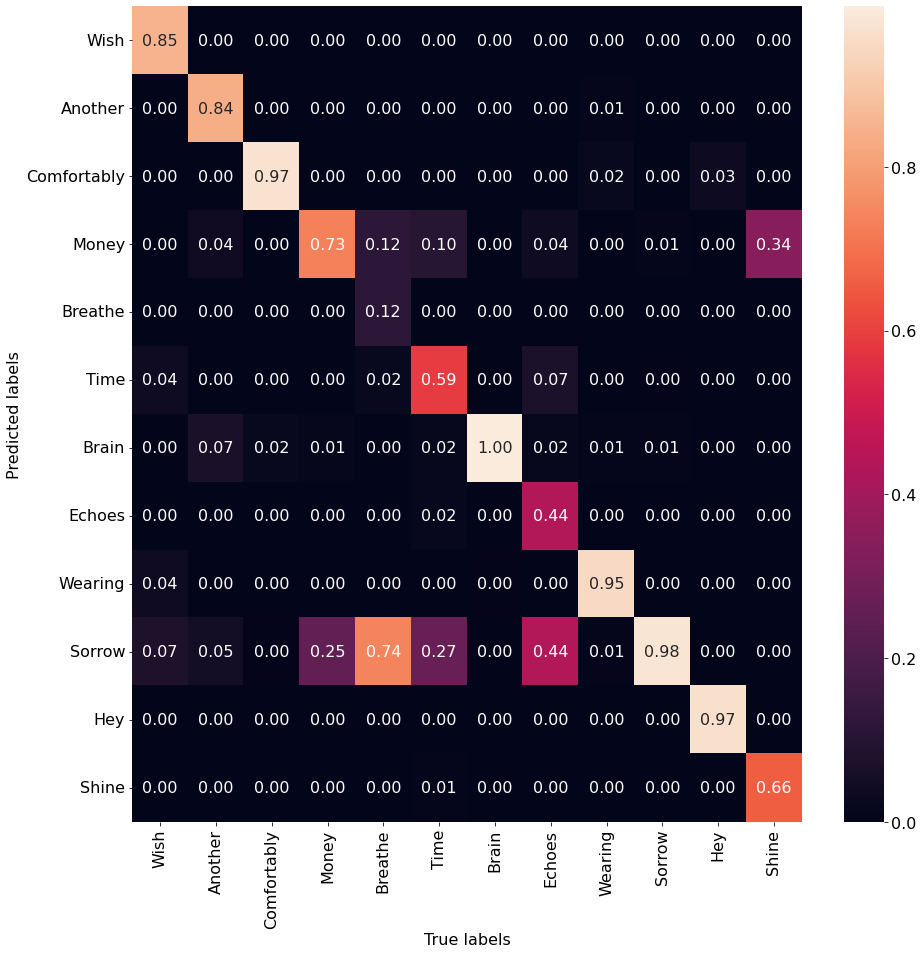

7/7 [==============================] - 0s 18ms/step
Accuracy: 0.6666666666666666
F1 score: 0.5315878076930306


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


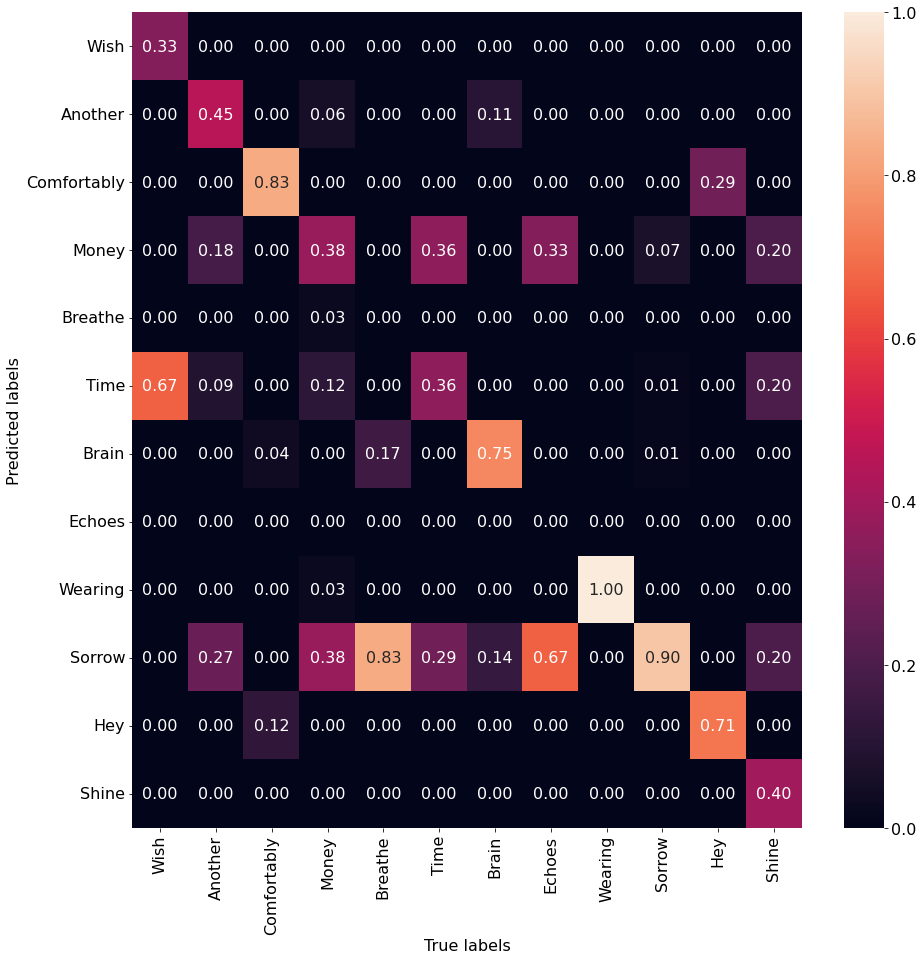

8/8 [==============================] - 0s 14ms/step
Accuracy: 0.6748971193415638
F1 score: 0.5745298220298221


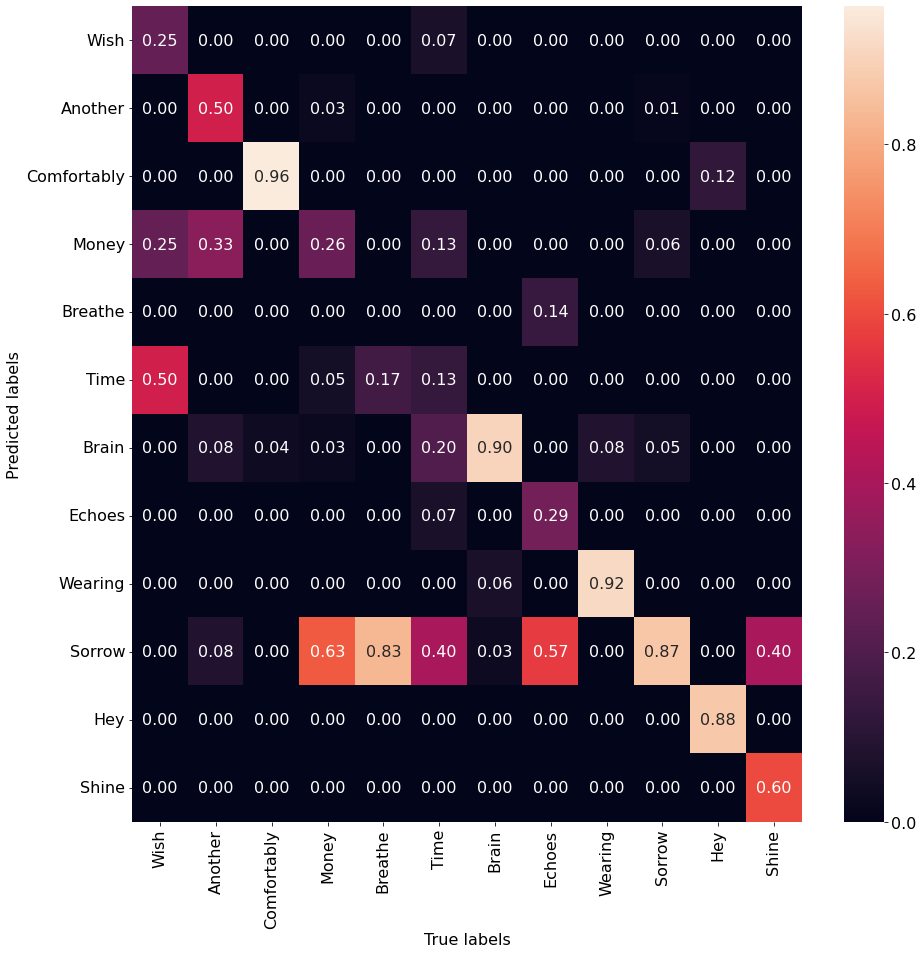

In [ ]:
ret = evaluate_model_m(model, X_train, y_train, classes)
ret = evaluate_model_m(model, X_val, y_val, classes)
ret = evaluate_model_m(model, X_test, y_test, classes)

In [ ]:
model.save('models/CNN6')
# model = tfk.models.load_model('1DCNN')

###ResNet-kind CNN

In [ ]:
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.layers import Activation

def custom_activation(x, beta = 1):
        return (K.sigmoid(beta * x) * x)

get_custom_objects().update({'custom_activation': Activation(custom_activation)})


def block(block_input, num_filters,lmbd,dp_rate):

  cnn11 = tfkl.Conv1D(num_filters,4,padding='same',activation = 'relu',kernel_initializer = tfk.initializers.HeUniform(seed),
                    kernel_regularizer=tf.keras.regularizers.L1L2(lmbd,lmbd))(block_input)
  #cnn11 = tfkl.BatchNormalization()(cnn11)
  #cnn11 = Activation(custom_activation)(cnn11)
  #cnn11 = tfkl.ELU()(cnn11)
  cnn11 = tfkl.Dropout(dp_rate)(cnn11)

  cnn12 = tfkl.Conv1D(num_filters,4,padding='same',activation = 'relu',kernel_initializer = tfk.initializers.HeUniform(seed),
                    kernel_regularizer=tf.keras.regularizers.L1L2(lmbd,lmbd))(cnn11)
  #cnn12 = tfkl.BatchNormalization()(cnn12)
  #cnn12 = Activation(custom_activation)(cnn12)
  #cnn12 = tfkl.ELU()(cnn12)
  cnn12 = tfkl.Dropout(dp_rate)(cnn12)

  cnn13 = tfkl.Conv1D(num_filters,4,padding='same', activation = 'relu',kernel_initializer = tfk.initializers.HeUniform(seed),
                    kernel_regularizer=tf.keras.regularizers.L1L2(lmbd,lmbd))(cnn12)
  #cnn13 = tfkl.BatchNormalization()(cnn13)
  #cnn13 = Activation(custom_activation)(cnn13)
  #cnn13 = tfkl.ELU()(cnn13)
  cnn13 = tfkl.Dropout(dp_rate)(cnn13)

  sum = tfkl.Add()([cnn13, cnn11])
  cnn13 = tfkl.MaxPooling1D(strides=2)(sum)

  return cnn13

In [ ]:
def build_CNN(input_shape=input_shape, n_output=n_output, n1=64, n2=128, n3=256, n4=256, n5= 256, n6=128,dp_rate1=0.3, lmbd1=1e-5,dp_rate2=0.3, lmbd2=1e-5,dp_rate3=0.3, lmbd3=1e-5,dp_rate4=0.3, lmbd4=1e-5,dp_rate5=0.3, lmbd5=1e-5, lmbd6=1e-5):

    input_layer = tfkl.Input(shape=input_shape, name='Input')
    x = tfkl.Reshape((r,1), input_shape=(input_shape))(input_layer)

    # Feature extractor
    x = block(input_layer,n1,lmbd1, dp_rate1)
    x = block(x,n2,lmbd2, dp_rate2)
    x = block(x,n3,lmbd3, dp_rate3)
    x = block(x,n4,lmbd4, dp_rate4)
    #x = block(x,1024,1e-5,0.1)

    gap = tfkl.GlobalAveragePooling1D()(x)

    # Classifier
    classifier = tfkl.Dense(n5, activation='relu', kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer=tf.keras.regularizers.l2(lmbd5))(gap)
    dropout = tfkl.Dropout(dp_rate5, seed=seed)(classifier)
    
    classifier = tfkl.Dense(n6, activation='relu', kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer=tf.keras.regularizers.l2(lmbd6))(dropout)

    output_layer = tfkl.Dense(n_output, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='Trad_1D_cnn')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.001), metrics='accuracy')

    # Return the model
    return model

In [ ]:
# model class to use in the scikit parameter search CV 
model = KerasClassifier(build_fn=build_CNN,  n1=64, n2=128, n3=256, n4=256, n5= 256, n6=128,dp_rate1=0.3, lmbd1=1e-5,dp_rate2=0.3, lmbd2=1e-5,dp_rate3=0.3, lmbd3=1e-5,dp_rate4=0.3, lmbd4=1e-5,dp_rate5=0.3, lmbd5=1e-5, lmbd6=1e-5)

In [ ]:
# define the hyperparameters to tune
hyperparameters = {
    'epochs': [30,50],
    'batch_size': [32, 64, 128],
    'n1': [32,64,128], 
    'n2': [64,128,256], 
    'n3': [128,256,512],
    'n4': [128,256,512],
    'n5': [128,256,512],
    'n6': [128,256,512], 
    'lmbd1':[1e-2,1e-3,1e-4,1e-5],
    'dp_rate1': np.arange(0, 0.5, 0.05),
    'lmbd2':[1e-2,1e-3,1e-4,1e-5],
    'dp_rate2': np.arange(0, 0.5, 0.05),
    'lmbd3':[1e-2,1e-3,1e-4,1e-5],
    'dp_rate3': np.arange(0, 0.5, 0.05),
    'lmbd4':[1e-2,1e-3,1e-4,1e-5],
    'dp_rate4': np.arange(0, 0.5, 0.05),
    'lmbd5':[1e-2,1e-3,1e-4,1e-5],
    'dp_rate5': np.arange(0, 0.5, 0.05),
    'lmbd6':[1e-2,1e-3,1e-4,1e-5],
}

In [ ]:
# create the random search object
rs = BayesSearchCV(estimator=model, search_spaces=hyperparameters, cv=3, n_iter=15)

In [ ]:
# fit the random search object to the training data
rs.fit(X_train, y_train)

# view the best hyperparameters
print(rs.best_params_)

In [ ]:
batch_size = 128
epochs = 800 

model = build_CNN(input_shape=input_shape, n_output=n_output, n1=32, n2=128, n3=256, n4=512, n5= 256, n6=128,dp_rate1=0.2, lmbd1=1e-3,dp_rate2=0.2, lmbd2=1e-4,dp_rate3=0.3, lmbd3=1e-5,dp_rate4=0.2, lmbd4=1e-3,dp_rate5=0.1, lmbd5=0.00001, lmbd6=1e-5)
model.summary() 

In [ ]:
tfk.utils.plot_model(model)

In [ ]:
# Train the model
history = model.fit(
    x = X_train, 
    y = y_train,
    batch_size = batch_size,
    #class_weight = class_weights,
    epochs = epochs,
    validation_data= (X_val, y_val),
    callbacks = [ 
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=150, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=30, factor=0.5, min_lr=1e-19)
    ] 
).history 

In [ ]:
ret = evaluate_model_m(model, X_test, y_test, classes)  